In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## WGAN

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
import gzip

In [3]:
PATH = Path('data/comix-gan')
IMG_PATH = PATH/'images/5'
CSV_PATH = PATH/'files.csv'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [6]:
files = PATH.glob("images/**/*.jpg")
with CSV_PATH.open('w') as fo:
    for f in files: fo.write(f'{f.relative_to(IMG_PATH)},0\n')

In [10]:
class SeparableConv2D(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2D, self).__init__()
        self.conv1 = nn.Conv2d(in_chan, in_chan, kernel_size, stride, padding, dilation, groups=in_chan, bias=bias)
        self.pointwise = nn.Conv2d(in_chan, out_chan, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        return self.pointwise(self.conv1(x))

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [5]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = []
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

In [6]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [7]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]

        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2

        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, input): return F.tanh(self.features(input))

In [8]:
bs,sz,nz = 64,64,100

In [9]:
tfms = tfms_from_stats(inception_stats, sz)
md = ImageClassifierData.from_csv(PATH, 'images/5', CSV_PATH, tfms=tfms, bs=128,
                                  skip_header=False, continuous=True)

In [44]:
md = md.resize(512)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [45]:
x,_ = next(iter(md.val_dl))

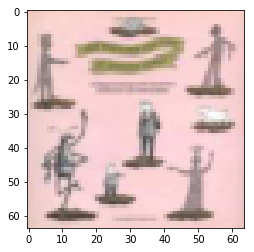

In [47]:
plt.imshow(md.trn_ds.denorm(x)[1]);

In [19]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

In [20]:
def create_noise(b): return V(torch.zeros(b, nz, 1, 1).normal_(0, 1))

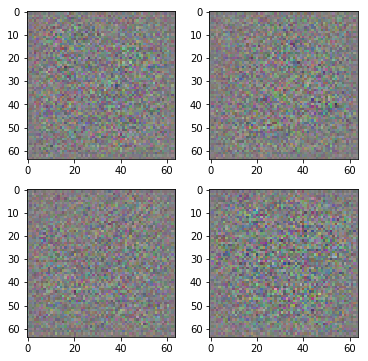

In [21]:
preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

In [22]:
def gallery(x, nc=3):
    n,h,w,c = x.shape
    nr = n//nc
    assert n == nr*nc
    return (x.reshape(nr, nc, h, w, c)
              .swapaxes(1,2)
              .reshape(h*nr, w*nc, c))

In [23]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

In [24]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        with tqdm(total=n) as pbar:
            while i < n:
                set_trainable(netD, True)
                set_trainable(netG, False)
                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
                j = 0
                while (j < d_iters) and (i < n):
                    j += 1; i += 1
                    for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    real = V(next(data_iter)[0])
                    real_loss = netD(real)
                    fake = netG(create_noise(real.size(0)))
                    fake_loss = netD(V(fake.data))
                    netD.zero_grad()
                    lossD = real_loss-fake_loss
                    lossD.backward()
                    optimizerD.step()
                    pbar.update()

                set_trainable(netD, False)
                set_trainable(netG, True)
                netG.zero_grad()
                lossG = netD(netG(create_noise(bs)))
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
            
        print(f'Loss_D {to_np(lossD)}; Loss_G {to_np(lossG)}; '
              f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')

In [25]:
torch.backends.cudnn.benchmark=True

In [ ]:
cyc = 25000
train(cyc, False)

100%|██████████| 8/8 [00:07<00:00,  1.53it/s]
Loss_D [-0.12263]; Loss_G [0.27346]; D_real [0.44141]; Loss_D_fake [0.56404]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]51s/it]
Loss_D [-0.24228]; Loss_G [0.37715]; D_real [0.20674]; Loss_D_fake [0.44902]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]51s/it]
Loss_D [-0.50547]; Loss_G [0.10529]; D_real [-0.01515]; Loss_D_fake [0.49031]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]43s/it]
Loss_D [-0.47861]; Loss_G [0.28586]; D_real [-0.02042]; Loss_D_fake [0.45819]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]40s/it]
Loss_D [-0.91659]; Loss_G [0.52909]; D_real [-0.65715]; Loss_D_fake [0.25944]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]37s/it]
Loss_D [-0.66394]; Loss_G [0.51429]; D_real [-0.5797]; Loss_D_fake [0.08424]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]36s/it]
Loss_D [-0.68723]; Loss_G [0.49402]; D_real [-0.59797]; Loss_D_fake [0.08926]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]37s/it]
Loss_D [-0.27032]; Loss_G [0.42158]; D_r

100%|██████████| 8/8 [00:06<00:00,  1.62it/s]7.20s/it]
Loss_D [-0.27547]; Loss_G [0.23745]; D_real [0.24181]; Loss_D_fake [0.51728]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]7.20s/it]
Loss_D [-1.0146]; Loss_G [0.47261]; D_real [-0.508]; Loss_D_fake [0.50661]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]7.20s/it]
Loss_D [-0.41415]; Loss_G [-0.16287]; D_real [0.07772]; Loss_D_fake [0.49187]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]7.20s/it]
Loss_D [-0.48774]; Loss_G [0.27024]; D_real [0.01306]; Loss_D_fake [0.5008]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]7.20s/it]
Loss_D [-0.87054]; Loss_G [0.37961]; D_real [-0.37847]; Loss_D_fake [0.49207]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]7.20s/it]
Loss_D [0.14645]; Loss_G [0.29469]; D_real [0.49173]; Loss_D_fake [0.34528]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]7.20s/it]
Loss_D [-0.90877]; Loss_G [0.29273]; D_real [-0.3091]; Loss_D_fake [0.59967]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]7.20s/it]
Loss_D [-0.54214]; Loss

100%|██████████| 8/8 [00:06<00:00,  1.63it/s]7.17s/it]
Loss_D [-0.23224]; Loss_G [0.30556]; D_real [0.35272]; Loss_D_fake [0.58496]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]7.17s/it]
Loss_D [-1.03595]; Loss_G [0.24841]; D_real [-0.45136]; Loss_D_fake [0.58459]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]7.17s/it]
Loss_D [-0.62229]; Loss_G [-0.09824]; D_real [-0.04026]; Loss_D_fake [0.58203]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]7.17s/it]
Loss_D [-1.07706]; Loss_G [0.55368]; D_real [-0.54209]; Loss_D_fake [0.53497]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]7.17s/it]
Loss_D [-0.44859]; Loss_G [-0.38149]; D_real [0.03696]; Loss_D_fake [0.48555]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]7.17s/it]
Loss_D [0.00307]; Loss_G [0.49645]; D_real [0.55828]; Loss_D_fake [0.55521]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]7.17s/it]
Loss_D [-0.3366]; Loss_G [0.01163]; D_real [0.19386]; Loss_D_fake [0.53047]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]7.17s/it]
Loss_D [0.00711]; 

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]7.16s/it]
Loss_D [0.0723]; Loss_G [0.46071]; D_real [0.4793]; Loss_D_fake [0.407]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]7.16s/it]
Loss_D [-0.3705]; Loss_G [0.06602]; D_real [0.18061]; Loss_D_fake [0.5511]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]7.16s/it]
Loss_D [-0.70136]; Loss_G [-0.13534]; D_real [-0.13711]; Loss_D_fake [0.56425]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]7.16s/it]
Loss_D [-0.85447]; Loss_G [0.1572]; D_real [-0.44993]; Loss_D_fake [0.40454]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]7.16s/it]
Loss_D [-0.76278]; Loss_G [0.13674]; D_real [-0.44554]; Loss_D_fake [0.31724]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]7.16s/it]
Loss_D [-0.53433]; Loss_G [-0.09631]; D_real [0.09485]; Loss_D_fake [0.62918]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]7.16s/it]
Loss_D [-0.43991]; Loss_G [-0.15956]; D_real [0.11094]; Loss_D_fake [0.55086]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]7.16s/it]
Loss_D [-0.71901]; Loss

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]7.14s/it]
Loss_D [-0.01578]; Loss_G [0.55624]; D_real [0.55954]; Loss_D_fake [0.57532]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]7.14s/it]
Loss_D [-0.83788]; Loss_G [0.6202]; D_real [-0.63255]; Loss_D_fake [0.20533]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]7.14s/it]
Loss_D [-0.58513]; Loss_G [0.41342]; D_real [-0.36009]; Loss_D_fake [0.22504]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]7.14s/it]
Loss_D [-0.39607]; Loss_G [0.09611]; D_real [0.00165]; Loss_D_fake [0.39772]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]7.14s/it]
Loss_D [-0.36139]; Loss_G [-0.02889]; D_real [0.14558]; Loss_D_fake [0.50697]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]7.14s/it]
Loss_D [-0.92086]; Loss_G [0.41001]; D_real [-0.62286]; Loss_D_fake [0.298]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]7.14s/it]
Loss_D [-0.79827]; Loss_G [0.04392]; D_real [-0.30347]; Loss_D_fake [0.4948]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]7.14s/it]
Loss_D [-0.09295]; L

100%|██████████| 8/8 [00:06<00:00,  1.62it/s]7.14s/it]
Loss_D [-0.14659]; Loss_G [0.30003]; D_real [0.3495]; Loss_D_fake [0.49609]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]7.14s/it]
Loss_D [-0.74516]; Loss_G [0.1574]; D_real [-0.20871]; Loss_D_fake [0.53646]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]7.14s/it]
Loss_D [-0.95378]; Loss_G [0.62677]; D_real [-0.65115]; Loss_D_fake [0.30264]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]7.14s/it]
Loss_D [-0.20713]; Loss_G [0.3565]; D_real [0.24092]; Loss_D_fake [0.44805]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]7.14s/it]
Loss_D [-0.19767]; Loss_G [0.44626]; D_real [0.35466]; Loss_D_fake [0.55233]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]7.14s/it]
Loss_D [-0.08837]; Loss_G [0.2167]; D_real [-0.17172]; Loss_D_fake [-0.08334]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]7.13s/it]
Loss_D [-0.30517]; Loss_G [0.28535]; D_real [0.22333]; Loss_D_fake [0.5285]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]7.14s/it]
Loss_D [-0.64173]; Los

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]7.13s/it]
Loss_D [-0.16583]; Loss_G [0.50449]; D_real [0.45197]; Loss_D_fake [0.6178]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]7.13s/it]
Loss_D [-0.29301]; Loss_G [0.20713]; D_real [-0.09056]; Loss_D_fake [0.20245]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]7.13s/it]
Loss_D [-0.24636]; Loss_G [0.04471]; D_real [0.24005]; Loss_D_fake [0.4864]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]7.13s/it]
Loss_D [-0.15363]; Loss_G [0.41817]; D_real [0.39497]; Loss_D_fake [0.5486]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]7.13s/it]
Loss_D [-0.32542]; Loss_G [-0.14272]; D_real [0.07465]; Loss_D_fake [0.40007]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]7.13s/it]
Loss_D [-0.9721]; Loss_G [0.34809]; D_real [-0.398]; Loss_D_fake [0.5741]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]7.13s/it]
Loss_D [-0.52608]; Loss_G [0.41976]; D_real [0.07943]; Loss_D_fake [0.6055]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]7.13s/it]
Loss_D [-0.79067]; Loss_G 

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]  7.12s/it]
Loss_D [-0.76849]; Loss_G [0.01825]; D_real [-0.2972]; Loss_D_fake [0.47129]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]  7.12s/it]
Loss_D [-0.7359]; Loss_G [0.41102]; D_real [-0.49087]; Loss_D_fake [0.24503]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]  7.12s/it]
Loss_D [-0.14759]; Loss_G [0.43635]; D_real [0.46415]; Loss_D_fake [0.61174]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]  7.12s/it]
Loss_D [-0.46921]; Loss_G [0.27714]; D_real [0.13877]; Loss_D_fake [0.60798]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]  7.12s/it]
Loss_D [-0.50133]; Loss_G [0.55214]; D_real [-0.5382]; Loss_D_fake [-0.03687]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]  7.12s/it]
Loss_D [-0.87593]; Loss_G [0.02419]; D_real [-0.49017]; Loss_D_fake [0.38576]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]  7.12s/it]
Loss_D [-0.1285]; Loss_G [0.528]; D_real [0.40919]; Loss_D_fake [0.53768]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]  7.12s/it]
Loss_D

100%|██████████| 8/8 [00:06<00:00,  1.61it/s]  7.12s/it]
Loss_D [-0.7168]; Loss_G [0.55366]; D_real [-0.64704]; Loss_D_fake [0.06976]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]  7.12s/it]
Loss_D [-0.15846]; Loss_G [0.53732]; D_real [0.41351]; Loss_D_fake [0.57197]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]  7.12s/it]
Loss_D [-0.52567]; Loss_G [0.60105]; D_real [-0.56972]; Loss_D_fake [-0.04405]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]  7.12s/it]
Loss_D [-0.65921]; Loss_G [0.13888]; D_real [-0.43253]; Loss_D_fake [0.22668]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]  7.12s/it]
Loss_D [-0.77852]; Loss_G [-0.10915]; D_real [-0.27451]; Loss_D_fake [0.50401]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]  7.12s/it]
Loss_D [-0.48432]; Loss_G [-0.08905]; D_real [0.04237]; Loss_D_fake [0.52669]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]  7.12s/it]
Loss_D [-0.52323]; Loss_G [0.15544]; D_real [-0.14503]; Loss_D_fake [0.3782]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]  7.12s/it]

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]  7.12s/it]
Loss_D [-0.19475]; Loss_G [0.11063]; D_real [-0.20771]; Loss_D_fake [-0.01296]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]  7.12s/it]
Loss_D [-0.81453]; Loss_G [0.55766]; D_real [-0.61522]; Loss_D_fake [0.19931]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]  7.12s/it]
Loss_D [-0.20788]; Loss_G [0.13519]; D_real [0.30022]; Loss_D_fake [0.5081]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]  7.12s/it]
Loss_D [-0.51701]; Loss_G [0.47698]; D_real [-0.48894]; Loss_D_fake [0.02807]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]  7.12s/it]
Loss_D [-0.75919]; Loss_G [0.22276]; D_real [-0.35705]; Loss_D_fake [0.40214]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]  7.12s/it]
Loss_D [-0.27268]; Loss_G [-0.20575]; D_real [0.08325]; Loss_D_fake [0.35593]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]  7.12s/it]
Loss_D [-0.35464]; Loss_G [-0.18385]; D_real [0.04868]; Loss_D_fake [0.40332]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]  7.12s/it]

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]  7.12s/it]
Loss_D [-0.5168]; Loss_G [0.30892]; D_real [-0.41169]; Loss_D_fake [0.10511]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]  7.12s/it]
Loss_D [-0.13868]; Loss_G [0.5207]; D_real [0.42124]; Loss_D_fake [0.55992]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]  7.12s/it]
Loss_D [0.42873]; Loss_G [0.24432]; D_real [0.22738]; Loss_D_fake [-0.20135]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]  7.12s/it]
Loss_D [-1.09609]; Loss_G [0.5922]; D_real [-0.58174]; Loss_D_fake [0.51435]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]  7.12s/it]
Loss_D [-0.86926]; Loss_G [0.42142]; D_real [-0.52739]; Loss_D_fake [0.34187]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]  7.12s/it]
Loss_D [-0.33201]; Loss_G [0.09728]; D_real [0.15999]; Loss_D_fake [0.49199]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]  7.12s/it]
Loss_D [-1.07829]; Loss_G [0.49669]; D_real [-0.4465]; Loss_D_fake [0.63179]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]  7.12s/it]
Loss_

100%|██████████| 8/8 [00:06<00:00,  1.61it/s]  7.12s/it]
Loss_D [-0.12387]; Loss_G [0.22782]; D_real [0.32808]; Loss_D_fake [0.45195]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]  7.12s/it]
Loss_D [-0.61373]; Loss_G [-0.00885]; D_real [-0.02939]; Loss_D_fake [0.58433]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]  7.12s/it]
Loss_D [-0.45785]; Loss_G [-0.03082]; D_real [0.111]; Loss_D_fake [0.56885]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]  7.12s/it]
Loss_D [-0.37852]; Loss_G [0.07254]; D_real [-0.03319]; Loss_D_fake [0.34533]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]  7.12s/it]
Loss_D [-0.11714]; Loss_G [-0.00175]; D_real [0.05826]; Loss_D_fake [0.17541]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]  7.12s/it]
Loss_D [-0.37711]; Loss_G [0.05314]; D_real [-0.0245]; Loss_D_fake [0.35261]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]  7.12s/it]
Loss_D [-0.58977]; Loss_G [0.53074]; D_real [-0.6882]; Loss_D_fake [-0.09843]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]  7.12s/it]
L

100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.12s/it]
Loss_D [-1.00409]; Loss_G [0.60472]; D_real [-0.61668]; Loss_D_fake [0.38741]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it]
Loss_D [-0.6373]; Loss_G [0.18264]; D_real [-0.46411]; Loss_D_fake [0.17318]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it]
Loss_D [-1.01438]; Loss_G [0.24871]; D_real [-0.49074]; Loss_D_fake [0.52363]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it]
Loss_D [-0.42505]; Loss_G [0.14309]; D_real [-0.01807]; Loss_D_fake [0.40698]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.12s/it]
Loss_D [-0.40154]; Loss_G [0.17519]; D_real [0.13047]; Loss_D_fake [0.53201]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it]
Loss_D [-0.83953]; Loss_G [0.21783]; D_real [-0.48663]; Loss_D_fake [0.3529]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.12s/it]
Loss_D [-0.27599]; Loss_G [0.11252]; D_real [0.27041]; Loss_D_fake [0.5464]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.12s

100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.12s/it]
Loss_D [-0.17118]; Loss_G [0.01745]; D_real [0.06308]; Loss_D_fake [0.23427]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it]
Loss_D [-0.21325]; Loss_G [0.34269]; D_real [0.35319]; Loss_D_fake [0.56644]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it]
Loss_D [-0.28396]; Loss_G [0.40477]; D_real [0.29235]; Loss_D_fake [0.57631]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.12s/it]
Loss_D [-0.02251]; Loss_G [-0.033]; D_real [0.0581]; Loss_D_fake [0.08061]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.12s/it]
Loss_D [0.34162]; Loss_G [0.52418]; D_real [0.4003]; Loss_D_fake [0.05868]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.12s/it]
Loss_D [-0.52504]; Loss_G [0.11489]; D_real [-0.26956]; Loss_D_fake [0.25548]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.12s/it]
Loss_D [-1.04155]; Loss_G [-0.05198]; D_real [-0.40256]; Loss_D_fake [0.63899]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.12s/it

100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.12s/it]
Loss_D [-0.24978]; Loss_G [0.03219]; D_real [-0.00432]; Loss_D_fake [0.24547]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.12s/it]
Loss_D [-0.91517]; Loss_G [0.09799]; D_real [-0.37829]; Loss_D_fake [0.53689]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.12s/it]
Loss_D [-0.00244]; Loss_G [0.42456]; D_real [0.38463]; Loss_D_fake [0.38708]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.12s/it]
Loss_D [-0.03901]; Loss_G [0.57592]; D_real [0.42203]; Loss_D_fake [0.46104]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.12s/it]
Loss_D [-0.33453]; Loss_G [0.03495]; D_real [0.03951]; Loss_D_fake [0.37404]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it]
Loss_D [-1.08795]; Loss_G [0.45416]; D_real [-0.51887]; Loss_D_fake [0.56908]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.12s/it]
Loss_D [-0.78985]; Loss_G [0.52983]; D_real [-0.52993]; Loss_D_fake [0.25991]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.1

100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.12s/it]
Loss_D [-1.09996]; Loss_G [0.57764]; D_real [-0.60675]; Loss_D_fake [0.49321]
100%|██████████| 8/8 [00:06<00:00,  1.64it/s],  7.12s/it]
Loss_D [-0.96833]; Loss_G [0.31957]; D_real [-0.5745]; Loss_D_fake [0.39383]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.12s/it]
Loss_D [-0.17596]; Loss_G [0.46598]; D_real [0.44274]; Loss_D_fake [0.6187]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it]
Loss_D [-0.90993]; Loss_G [0.14154]; D_real [-0.35044]; Loss_D_fake [0.55949]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.12s/it]
Loss_D [-0.89866]; Loss_G [-0.34103]; D_real [-0.28432]; Loss_D_fake [0.61434]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.12s/it]
Loss_D [-0.40997]; Loss_G [0.21245]; D_real [0.19579]; Loss_D_fake [0.60576]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.12s/it]
Loss_D [-0.52722]; Loss_G [0.19323]; D_real [-0.0342]; Loss_D_fake [0.49302]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.12

100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.12s/it]
Loss_D [-0.24446]; Loss_G [0.30382]; D_real [0.3613]; Loss_D_fake [0.60576]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.12s/it]
Loss_D [-0.55985]; Loss_G [-0.05094]; D_real [-0.3134]; Loss_D_fake [0.24644]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.12s/it]
Loss_D [-1.08623]; Loss_G [0.57249]; D_real [-0.63053]; Loss_D_fake [0.4557]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.12s/it]
Loss_D [-0.80364]; Loss_G [-0.08075]; D_real [-0.21116]; Loss_D_fake [0.59248]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.12s/it]
Loss_D [-0.29815]; Loss_G [-0.01947]; D_real [0.31303]; Loss_D_fake [0.61118]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.12s/it]
Loss_D [-0.77015]; Loss_G [0.48401]; D_real [-0.26441]; Loss_D_fake [0.50574]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.12s/it]
Loss_D [-0.25982]; Loss_G [0.339]; D_real [0.30149]; Loss_D_fake [0.56131]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.12s

100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.12s/it]
Loss_D [-0.51488]; Loss_G [0.33102]; D_real [-0.59436]; Loss_D_fake [-0.07949]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.12s/it]
Loss_D [-0.99417]; Loss_G [0.45746]; D_real [-0.47937]; Loss_D_fake [0.5148]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it]
Loss_D [-0.90154]; Loss_G [0.34294]; D_real [-0.46689]; Loss_D_fake [0.43466]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.12s/it]
Loss_D [-0.52718]; Loss_G [-0.32916]; D_real [-0.20794]; Loss_D_fake [0.31924]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.12s/it]
Loss_D [-0.46292]; Loss_G [-0.09614]; D_real [-0.07226]; Loss_D_fake [0.39066]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.12s/it]
Loss_D [-0.11964]; Loss_G [0.37192]; D_real [0.4071]; Loss_D_fake [0.52673]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it]
Loss_D [-0.82652]; Loss_G [0.46609]; D_real [-0.3879]; Loss_D_fake [0.43861]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7

100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.12s/it]
Loss_D [-1.09887]; Loss_G [0.62011]; D_real [-0.66003]; Loss_D_fake [0.43884]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it]
Loss_D [-0.48774]; Loss_G [0.1035]; D_real [-0.15234]; Loss_D_fake [0.3354]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.12s/it]
Loss_D [-0.08744]; Loss_G [0.51005]; D_real [0.51417]; Loss_D_fake [0.60161]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s],  7.12s/it]
Loss_D [-0.29026]; Loss_G [0.17746]; D_real [0.04806]; Loss_D_fake [0.33832]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.12s/it]
Loss_D [-0.3306]; Loss_G [0.16064]; D_real [0.18457]; Loss_D_fake [0.51517]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.12s/it]
Loss_D [-0.45915]; Loss_G [-0.191]; D_real [-0.00285]; Loss_D_fake [0.4563]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it]
Loss_D [-0.67328]; Loss_G [0.07688]; D_real [-0.06356]; Loss_D_fake [0.60972]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it

100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.12s/it]
Loss_D [-0.08865]; Loss_G [0.05388]; D_real [0.21092]; Loss_D_fake [0.29957]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [0.04384]; Loss_G [0.50334]; D_real [0.41288]; Loss_D_fake [0.36904]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-1.04295]; Loss_G [0.4954]; D_real [-0.63576]; Loss_D_fake [0.40719]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.52634]; Loss_G [-0.01595]; D_real [-0.00015]; Loss_D_fake [0.52619]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.11s/it]
Loss_D [-0.3191]; Loss_G [0.07537]; D_real [0.30193]; Loss_D_fake [0.62104]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-1.00299]; Loss_G [0.14673]; D_real [-0.54043]; Loss_D_fake [0.46256]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.14439]; Loss_G [0.49814]; D_real [0.39282]; Loss_D_fake [0.53721]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/

100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.38245]; Loss_G [0.32675]; D_real [0.24433]; Loss_D_fake [0.62678]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.88147]; Loss_G [0.52786]; D_real [-0.65469]; Loss_D_fake [0.22678]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.35435]; Loss_G [-0.22329]; D_real [0.04109]; Loss_D_fake [0.39544]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.28388]; Loss_G [0.29799]; D_real [0.19647]; Loss_D_fake [0.48035]
100%|██████████| 8/8 [00:06<00:00,  1.64it/s],  7.11s/it]
Loss_D [-1.0448]; Loss_G [0.53872]; D_real [-0.50897]; Loss_D_fake [0.53583]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.88984]; Loss_G [0.24462]; D_real [-0.43792]; Loss_D_fake [0.45192]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.23194]; Loss_G [0.27395]; D_real [0.29852]; Loss_D_fake [0.53047]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11

100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.02162]; Loss_G [0.16242]; D_real [0.04817]; Loss_D_fake [0.06978]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.11s/it]
Loss_D [-0.41473]; Loss_G [0.10136]; D_real [0.14186]; Loss_D_fake [0.55658]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [0.08415]; Loss_G [0.57072]; D_real [0.49118]; Loss_D_fake [0.40702]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s],  7.11s/it]
Loss_D [-0.72552]; Loss_G [0.50213]; D_real [-0.61038]; Loss_D_fake [0.11514]
100%|██████████| 8/8 [00:07<00:00,  1.49it/s],  7.11s/it]
Loss_D [-1.04651]; Loss_G [0.21064]; D_real [-0.44359]; Loss_D_fake [0.60293]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7.12s/it]
Loss_D [-0.72256]; Loss_G [0.01015]; D_real [-0.20375]; Loss_D_fake [0.51881]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.12s/it]
Loss_D [-0.58878]; Loss_G [-0.34902]; D_real [-0.05673]; Loss_D_fake [0.53205]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.1

100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.12s/it]
Loss_D [-0.04587]; Loss_G [0.56797]; D_real [0.56425]; Loss_D_fake [0.61012]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.12s/it]
Loss_D [-0.66162]; Loss_G [-0.15932]; D_real [-0.30894]; Loss_D_fake [0.35268]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.12s/it]
Loss_D [-1.10607]; Loss_G [0.49198]; D_real [-0.55397]; Loss_D_fake [0.5521]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.12s/it]
Loss_D [-0.03438]; Loss_G [-0.17658]; D_real [-0.14555]; Loss_D_fake [-0.11118]
100%|██████████| 8/8 [00:07<00:00,  1.62it/s],  7.12s/it]
Loss_D [-0.7372]; Loss_G [-0.26176]; D_real [-0.31422]; Loss_D_fake [0.42298]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.12s/it]
Loss_D [-0.56465]; Loss_G [-0.0357]; D_real [-0.04538]; Loss_D_fake [0.51927]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.12s/it]
Loss_D [-0.83428]; Loss_G [0.14267]; D_real [-0.27895]; Loss_D_fake [0.55533]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s], 

100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.54823]; Loss_G [0.32115]; D_real [-0.53073]; Loss_D_fake [0.0175]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.10991]; Loss_G [0.54837]; D_real [0.48695]; Loss_D_fake [0.59686]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.36831]; Loss_G [-0.08398]; D_real [0.07271]; Loss_D_fake [0.44101]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.30016]; Loss_G [0.33199]; D_real [0.27779]; Loss_D_fake [0.57795]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s],  7.11s/it]
Loss_D [-0.27937]; Loss_G [0.25739]; D_real [-0.22192]; Loss_D_fake [0.05745]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [0.23162]; Loss_G [0.57033]; D_real [0.30938]; Loss_D_fake [0.07776]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.22869]; Loss_G [0.41506]; D_real [0.36474]; Loss_D_fake [0.59343]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/

100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.64675]; Loss_G [0.15925]; D_real [-0.09897]; Loss_D_fake [0.54779]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.17452]; Loss_G [-0.35599]; D_real [0.11646]; Loss_D_fake [0.29098]
100%|██████████| 8/8 [00:06<00:00,  1.64it/s],  7.11s/it]
Loss_D [-0.91231]; Loss_G [0.18714]; D_real [-0.5822]; Loss_D_fake [0.33011]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.44218]; Loss_G [-0.41597]; D_real [-0.02635]; Loss_D_fake [0.41582]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.69465]; Loss_G [0.13697]; D_real [-0.23186]; Loss_D_fake [0.46279]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.42995]; Loss_G [0.29543]; D_real [0.21992]; Loss_D_fake [0.64987]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.86898]; Loss_G [0.42452]; D_real [-0.41584]; Loss_D_fake [0.45314]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7

100%|██████████| 8/8 [00:07<00:00,  1.55it/s],  7.11s/it]
Loss_D [-0.76687]; Loss_G [0.44814]; D_real [-0.56201]; Loss_D_fake [0.20486]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.11s/it]
Loss_D [-0.20557]; Loss_G [-0.20622]; D_real [0.01332]; Loss_D_fake [0.21889]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.07319]; Loss_G [0.48945]; D_real [0.51794]; Loss_D_fake [0.59113]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.04593]; Loss_G [0.07774]; D_real [-0.35726]; Loss_D_fake [-0.31133]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.18761]; Loss_G [0.25346]; D_real [0.19424]; Loss_D_fake [0.38184]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.11s/it]
Loss_D [-0.28112]; Loss_G [0.25883]; D_real [0.31397]; Loss_D_fake [0.59508]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.11697]; Loss_G [0.51632]; D_real [0.39804]; Loss_D_fake [0.51502]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s],  7.1

100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.90936]; Loss_G [0.57336]; D_real [-0.64849]; Loss_D_fake [0.26087]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-1.07353]; Loss_G [0.57094]; D_real [-0.67958]; Loss_D_fake [0.39395]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.17799]; Loss_G [0.44532]; D_real [0.42712]; Loss_D_fake [0.60511]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.3568]; Loss_G [0.08967]; D_real [0.19139]; Loss_D_fake [0.54819]
100%|██████████| 8/8 [00:06<00:00,  1.64it/s],  7.11s/it]
Loss_D [-0.07713]; Loss_G [0.47209]; D_real [0.47271]; Loss_D_fake [0.54984]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.70454]; Loss_G [0.15555]; D_real [-0.43247]; Loss_D_fake [0.27208]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-1.14508]; Loss_G [0.43621]; D_real [-0.60855]; Loss_D_fake [0.53654]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11

100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.60059]; Loss_G [0.30368]; D_real [-0.49155]; Loss_D_fake [0.10904]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-1.07801]; Loss_G [0.51791]; D_real [-0.60641]; Loss_D_fake [0.4716]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.23439]; Loss_G [0.06058]; D_real [-0.1484]; Loss_D_fake [0.08599]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.67797]; Loss_G [-0.00573]; D_real [-0.15603]; Loss_D_fake [0.52194]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.18008]; Loss_G [0.18023]; D_real [0.31657]; Loss_D_fake [0.49665]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.17712]; Loss_G [0.30709]; D_real [0.37673]; Loss_D_fake [0.55385]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-1.15924]; Loss_G [0.60972]; D_real [-0.6255]; Loss_D_fake [0.53374]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11

100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.62111]; Loss_G [-0.55907]; D_real [-0.12165]; Loss_D_fake [0.49946]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.47776]; Loss_G [-0.41994]; D_real [-0.07524]; Loss_D_fake [0.40252]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.21347]; Loss_G [0.45384]; D_real [0.41855]; Loss_D_fake [0.63201]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.19815]; Loss_G [0.13356]; D_real [-0.15931]; Loss_D_fake [0.03883]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.91814]; Loss_G [0.24527]; D_real [-0.5753]; Loss_D_fake [0.34284]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.26033]; Loss_G [0.23735]; D_real [-0.23946]; Loss_D_fake [0.02087]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.46752]; Loss_G [-0.2571]; D_real [0.09021]; Loss_D_fake [0.55773]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7

100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.97735]; Loss_G [0.22987]; D_real [-0.37799]; Loss_D_fake [0.59937]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.92904]; Loss_G [0.40089]; D_real [-0.58899]; Loss_D_fake [0.34006]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.77594]; Loss_G [0.19556]; D_real [-0.44221]; Loss_D_fake [0.33373]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.30601]; Loss_G [0.23173]; D_real [0.21102]; Loss_D_fake [0.51703]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.64618]; Loss_G [0.22507]; D_real [-0.51433]; Loss_D_fake [0.13185]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.82376]; Loss_G [0.51105]; D_real [-0.62863]; Loss_D_fake [0.19513]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.60811]; Loss_G [0.42109]; D_real [-0.50556]; Loss_D_fake [0.10255]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7

100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.72738]; Loss_G [-0.31711]; D_real [-0.32833]; Loss_D_fake [0.39905]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.01489]; Loss_G [0.49939]; D_real [0.53725]; Loss_D_fake [0.55214]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.40919]; Loss_G [-0.06609]; D_real [0.13742]; Loss_D_fake [0.54661]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.48374]; Loss_G [-0.09097]; D_real [-0.09564]; Loss_D_fake [0.3881]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.87714]; Loss_G [0.02547]; D_real [-0.23854]; Loss_D_fake [0.6386]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.41387]; Loss_G [-0.05115]; D_real [-0.02544]; Loss_D_fake [0.38843]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s],  7.11s/it]
Loss_D [-0.77253]; Loss_G [0.12206]; D_real [-0.26762]; Loss_D_fake [0.50491]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  

100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.63371]; Loss_G [0.48899]; D_real [-0.4437]; Loss_D_fake [0.19002]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.13174]; Loss_G [0.42451]; D_real [0.22935]; Loss_D_fake [0.36109]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.50758]; Loss_G [0.01205]; D_real [-0.14663]; Loss_D_fake [0.36095]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.15478]; Loss_G [0.53625]; D_real [0.44638]; Loss_D_fake [0.60116]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s],  7.11s/it]
Loss_D [-0.03336]; Loss_G [0.44323]; D_real [0.26912]; Loss_D_fake [0.30248]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.4547]; Loss_G [0.08566]; D_real [-0.20324]; Loss_D_fake [0.25147]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.44351]; Loss_G [0.13602]; D_real [-0.10759]; Loss_D_fake [0.33592]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s

100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.15582]; Loss_G [-0.45571]; D_real [0.23982]; Loss_D_fake [0.39564]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.58552]; Loss_G [-0.06676]; D_real [-0.3627]; Loss_D_fake [0.22283]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.59472]; Loss_G [-0.3034]; D_real [0.05118]; Loss_D_fake [0.6459]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.11s/it]
Loss_D [-0.36129]; Loss_G [-0.13072]; D_real [-0.2054]; Loss_D_fake [0.15589]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.21772]; Loss_G [0.20049]; D_real [0.36215]; Loss_D_fake [0.57987]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.9365]; Loss_G [0.49902]; D_real [-0.45016]; Loss_D_fake [0.48634]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.11s/it]
Loss_D [-0.77029]; Loss_G [0.44988]; D_real [-0.46257]; Loss_D_fake [0.30772]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11

100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7.11s/it]
Loss_D [-1.03065]; Loss_G [0.23462]; D_real [-0.62382]; Loss_D_fake [0.40683]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.81826]; Loss_G [0.25569]; D_real [-0.34341]; Loss_D_fake [0.47484]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.69867]; Loss_G [0.29577]; D_real [-0.30999]; Loss_D_fake [0.38868]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.76239]; Loss_G [-0.08408]; D_real [-0.29647]; Loss_D_fake [0.46592]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-1.1427]; Loss_G [0.37379]; D_real [-0.63502]; Loss_D_fake [0.50768]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.28713]; Loss_G [0.41363]; D_real [0.25293]; Loss_D_fake [0.54006]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.07281]; Loss_G [0.47291]; D_real [0.48676]; Loss_D_fake [0.55958]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.

100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.9958]; Loss_G [-0.14375]; D_real [-0.37827]; Loss_D_fake [0.61753]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.24759]; Loss_G [-0.17921]; D_real [0.05287]; Loss_D_fake [0.30046]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.87381]; Loss_G [0.21566]; D_real [-0.36156]; Loss_D_fake [0.51226]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.47378]; Loss_G [-0.01063]; D_real [-0.20339]; Loss_D_fake [0.27039]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-1.20791]; Loss_G [0.59812]; D_real [-0.62352]; Loss_D_fake [0.58439]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.46992]; Loss_G [0.3701]; D_real [-0.46961]; Loss_D_fake [0.00031]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.78493]; Loss_G [0.57373]; D_real [-0.55854]; Loss_D_fake [0.22639]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  

100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.28003]; Loss_G [-0.09218]; D_real [0.08781]; Loss_D_fake [0.36784]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.49001]; Loss_G [0.07055]; D_real [0.02631]; Loss_D_fake [0.51631]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.19399]; Loss_G [0.44536]; D_real [0.21375]; Loss_D_fake [0.40774]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.3417]; Loss_G [-0.18806]; D_real [0.03627]; Loss_D_fake [0.37797]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.90732]; Loss_G [0.4912]; D_real [-0.37407]; Loss_D_fake [0.53325]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.73914]; Loss_G [0.40624]; D_real [-0.55432]; Loss_D_fake [0.18481]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.11s/it]
Loss_D [-0.30449]; Loss_G [-0.24276]; D_real [-0.09646]; Loss_D_fake [0.20803]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.1

100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.46182]; Loss_G [-0.1145]; D_real [-0.13391]; Loss_D_fake [0.32791]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-1.0054]; Loss_G [0.4844]; D_real [-0.67654]; Loss_D_fake [0.32886]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.73335]; Loss_G [0.32061]; D_real [-0.43084]; Loss_D_fake [0.30251]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-1.01714]; Loss_G [0.55697]; D_real [-0.63783]; Loss_D_fake [0.37931]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.67948]; Loss_G [0.5571]; D_real [-0.54551]; Loss_D_fake [0.13397]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.70597]; Loss_G [-0.41106]; D_real [-0.1468]; Loss_D_fake [0.55917]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.00527]; Loss_G [0.16259]; D_real [0.10544]; Loss_D_fake [0.11071]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11

100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.13734]; Loss_G [0.33752]; D_real [0.45514]; Loss_D_fake [0.59248]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.77044]; Loss_G [0.21791]; D_real [-0.1807]; Loss_D_fake [0.58973]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s],  7.11s/it]
Loss_D [-0.23256]; Loss_G [0.38869]; D_real [0.28101]; Loss_D_fake [0.51357]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.50559]; Loss_G [0.11023]; D_real [-0.37722]; Loss_D_fake [0.12837]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.14606]; Loss_G [0.39813]; D_real [0.35548]; Loss_D_fake [0.50154]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s],  7.11s/it]
Loss_D [-0.14565]; Loss_G [-0.06272]; D_real [0.35404]; Loss_D_fake [0.49969]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.27448]; Loss_G [0.41522]; D_real [0.30276]; Loss_D_fake [0.57724]
100%|██████████| 8/8 [00:07<00:00,  1.62it/s],  7.11s

100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.38401]; Loss_G [0.23898]; D_real [0.12952]; Loss_D_fake [0.51353]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.90917]; Loss_G [0.23902]; D_real [-0.36643]; Loss_D_fake [0.54274]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.40682]; Loss_G [0.07799]; D_real [0.06759]; Loss_D_fake [0.47441]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.64184]; Loss_G [0.32126]; D_real [-0.26368]; Loss_D_fake [0.37816]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-1.10924]; Loss_G [0.28828]; D_real [-0.55185]; Loss_D_fake [0.55739]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.4627]; Loss_G [0.10378]; D_real [0.11105]; Loss_D_fake [0.57375]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.58388]; Loss_G [-0.18795]; D_real [-0.07927]; Loss_D_fake [0.50461]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.1

100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.79282]; Loss_G [0.0708]; D_real [-0.29191]; Loss_D_fake [0.50091]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.31301]; Loss_G [0.2411]; D_real [0.3316]; Loss_D_fake [0.64462]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.21346]; Loss_G [0.45786]; D_real [0.3469]; Loss_D_fake [0.56036]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.27057]; Loss_G [0.16777]; D_real [0.21727]; Loss_D_fake [0.48784]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.24427]; Loss_G [-0.21645]; D_real [-0.09259]; Loss_D_fake [0.15168]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.55085]; Loss_G [0.47907]; D_real [-0.3462]; Loss_D_fake [0.20465]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.20568]; Loss_G [0.45875]; D_real [0.38359]; Loss_D_fake [0.58926]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/it

100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.18485]; Loss_G [0.4546]; D_real [0.34605]; Loss_D_fake [0.5309]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.25669]; Loss_G [0.29613]; D_real [0.33797]; Loss_D_fake [0.59466]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.33556]; Loss_G [-0.10054]; D_real [-0.17557]; Loss_D_fake [0.15999]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.15735]; Loss_G [0.06577]; D_real [0.2771]; Loss_D_fake [0.43444]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s],  7.11s/it]
Loss_D [-0.72005]; Loss_G [-0.10736]; D_real [-0.13441]; Loss_D_fake [0.58564]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.10965]; Loss_G [0.48973]; D_real [0.46747]; Loss_D_fake [0.57713]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.89451]; Loss_G [0.33995]; D_real [-0.4894]; Loss_D_fake [0.40512]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/

100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.49173]; Loss_G [-0.20359]; D_real [0.03469]; Loss_D_fake [0.52642]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.37294]; Loss_G [0.12024]; D_real [0.1296]; Loss_D_fake [0.50254]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.71986]; Loss_G [0.41847]; D_real [-0.54618]; Loss_D_fake [0.17368]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.98284]; Loss_G [0.39604]; D_real [-0.60109]; Loss_D_fake [0.38175]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [0.0114]; Loss_G [0.47999]; D_real [0.34854]; Loss_D_fake [0.33714]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.93052]; Loss_G [0.62247]; D_real [-0.67246]; Loss_D_fake [0.25805]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.37281]; Loss_G [-0.20317]; D_real [0.04601]; Loss_D_fake [0.41882]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s

100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.11s/it]
Loss_D [0.05409]; Loss_G [0.35779]; D_real [0.40565]; Loss_D_fake [0.35156]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.68551]; Loss_G [0.48535]; D_real [-0.59529]; Loss_D_fake [0.09022]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.52319]; Loss_G [-0.25716]; D_real [-0.08642]; Loss_D_fake [0.43677]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.09904]; Loss_G [0.47017]; D_real [0.50243]; Loss_D_fake [0.60147]
100%|██████████| 8/8 [00:06<00:00,  1.64it/s],  7.11s/it]
Loss_D [-0.20168]; Loss_G [0.47309]; D_real [0.42401]; Loss_D_fake [0.62569]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.46171]; Loss_G [0.23337]; D_real [-0.01545]; Loss_D_fake [0.44626]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.12581]; Loss_G [0.49685]; D_real [0.41971]; Loss_D_fake [0.54552]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s],  7.11

100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.13148]; Loss_G [0.01477]; D_real [0.29012]; Loss_D_fake [0.4216]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.54604]; Loss_G [-0.10098]; D_real [0.00942]; Loss_D_fake [0.55546]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.74319]; Loss_G [0.42001]; D_real [-0.50061]; Loss_D_fake [0.24258]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.37755]; Loss_G [0.36282]; D_real [0.17845]; Loss_D_fake [0.556]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.24681]; Loss_G [0.02059]; D_real [-0.0494]; Loss_D_fake [0.19741]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.78977]; Loss_G [0.2748]; D_real [-0.27042]; Loss_D_fake [0.51936]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.2815]; Loss_G [0.12195]; D_real [-0.11858]; Loss_D_fake [0.16291]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it

100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.3674]; Loss_G [-0.09996]; D_real [0.07552]; Loss_D_fake [0.44292]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.39097]; Loss_G [0.15893]; D_real [-0.03664]; Loss_D_fake [0.35433]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.37567]; Loss_G [0.36351]; D_real [-0.10847]; Loss_D_fake [0.2672]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.44887]; Loss_G [0.14388]; D_real [0.01177]; Loss_D_fake [0.46064]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.89637]; Loss_G [0.38307]; D_real [-0.33624]; Loss_D_fake [0.56013]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.00786]; Loss_G [0.59672]; D_real [0.60143]; Loss_D_fake [0.60929]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [0.01807]; Loss_G [-0.2329]; D_real [0.26634]; Loss_D_fake [0.24827]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/

100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.88682]; Loss_G [0.52891]; D_real [-0.65153]; Loss_D_fake [0.23529]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.16122]; Loss_G [0.29766]; D_real [0.1921]; Loss_D_fake [0.35332]
100%|██████████| 8/8 [00:06<00:00,  1.64it/s],  7.11s/it]
Loss_D [-0.22931]; Loss_G [0.03319]; D_real [0.25369]; Loss_D_fake [0.483]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.31362]; Loss_G [0.01855]; D_real [0.22423]; Loss_D_fake [0.53785]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-1.09586]; Loss_G [0.55352]; D_real [-0.59731]; Loss_D_fake [0.49854]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.10832]; Loss_G [0.34638]; D_real [0.41129]; Loss_D_fake [0.51962]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.33306]; Loss_G [-0.08244]; D_real [0.15012]; Loss_D_fake [0.48318]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/i

100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.20709]; Loss_G [0.10611]; D_real [0.32294]; Loss_D_fake [0.53003]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.59504]; Loss_G [0.54129]; D_real [-0.34614]; Loss_D_fake [0.2489]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.67694]; Loss_G [0.24555]; D_real [-0.29696]; Loss_D_fake [0.37998]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-1.09813]; Loss_G [0.60312]; D_real [-0.56781]; Loss_D_fake [0.53032]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.17732]; Loss_G [0.35067]; D_real [0.29938]; Loss_D_fake [0.4767]
100%|██████████| 8/8 [00:07<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.66436]; Loss_G [-0.10014]; D_real [-0.1372]; Loss_D_fake [0.52716]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.92829]; Loss_G [-0.51269]; D_real [-0.32365]; Loss_D_fake [0.60464]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.1

100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.15935]; Loss_G [0.41372]; D_real [0.41794]; Loss_D_fake [0.57729]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.82838]; Loss_G [0.14154]; D_real [-0.46835]; Loss_D_fake [0.36003]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-1.06112]; Loss_G [-0.02647]; D_real [-0.46963]; Loss_D_fake [0.59149]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.15889]; Loss_G [0.39505]; D_real [0.39729]; Loss_D_fake [0.55617]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.56809]; Loss_G [-0.03767]; D_real [0.05047]; Loss_D_fake [0.61856]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.31952]; Loss_G [0.35786]; D_real [0.30364]; Loss_D_fake [0.62316]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.7467]; Loss_G [0.34321]; D_real [-0.44404]; Loss_D_fake [0.30267]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.1

100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.69751]; Loss_G [0.02537]; D_real [-0.15831]; Loss_D_fake [0.5392]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.49]; Loss_G [0.23713]; D_real [0.06888]; Loss_D_fake [0.55888]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [0.18142]; Loss_G [0.06918]; D_real [0.19998]; Loss_D_fake [0.01856]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.45211]; Loss_G [0.39471]; D_real [-0.61329]; Loss_D_fake [-0.16118]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.17138]; Loss_G [0.12695]; D_real [0.29051]; Loss_D_fake [0.46189]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s],  7.11s/it]
Loss_D [-1.00775]; Loss_G [0.59194]; D_real [-0.52195]; Loss_D_fake [0.48581]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.56294]; Loss_G [0.5272]; D_real [-0.59498]; Loss_D_fake [-0.03204]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/i

100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.61286]; Loss_G [0.51678]; D_real [-0.59533]; Loss_D_fake [0.01753]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.12502]; Loss_G [0.40208]; D_real [0.43602]; Loss_D_fake [0.56104]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.11968]; Loss_G [0.45373]; D_real [0.45356]; Loss_D_fake [0.57324]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.90013]; Loss_G [0.43025]; D_real [-0.61971]; Loss_D_fake [0.28042]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.32386]; Loss_G [0.11774]; D_real [0.17415]; Loss_D_fake [0.49801]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.3676]; Loss_G [0.20105]; D_real [-0.17429]; Loss_D_fake [0.19331]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.13573]; Loss_G [0.29013]; D_real [0.29291]; Loss_D_fake [0.42864]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s

100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [0.14687]; Loss_G [0.4889]; D_real [0.44918]; Loss_D_fake [0.30231]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.11s/it]
Loss_D [-0.49395]; Loss_G [0.07273]; D_real [-0.05987]; Loss_D_fake [0.43409]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.19711]; Loss_G [0.26984]; D_real [0.41131]; Loss_D_fake [0.60843]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-1.13833]; Loss_G [0.44506]; D_real [-0.57247]; Loss_D_fake [0.56585]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-1.24472]; Loss_G [0.56324]; D_real [-0.62042]; Loss_D_fake [0.6243]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.92861]; Loss_G [0.16884]; D_real [-0.45209]; Loss_D_fake [0.47653]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.58673]; Loss_G [0.08707]; D_real [-0.29822]; Loss_D_fake [0.2885]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/

100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.17027]; Loss_G [0.39202]; D_real [0.41264]; Loss_D_fake [0.58291]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.14848]; Loss_G [0.27074]; D_real [0.33138]; Loss_D_fake [0.47986]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.45608]; Loss_G [0.27618]; D_real [0.10405]; Loss_D_fake [0.56013]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.57107]; Loss_G [-0.30805]; D_real [-0.12289]; Loss_D_fake [0.44818]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.50338]; Loss_G [0.16722]; D_real [-0.18317]; Loss_D_fake [0.32022]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.67561]; Loss_G [0.19608]; D_real [-0.17536]; Loss_D_fake [0.50025]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.95242]; Loss_G [0.29673]; D_real [-0.51329]; Loss_D_fake [0.43913]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s],  7.

100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.94457]; Loss_G [0.50899]; D_real [-0.61896]; Loss_D_fake [0.32562]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.69686]; Loss_G [-0.04111]; D_real [-0.29503]; Loss_D_fake [0.40183]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.18211]; Loss_G [0.21804]; D_real [0.37355]; Loss_D_fake [0.55567]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.47034]; Loss_G [0.12739]; D_real [0.12343]; Loss_D_fake [0.59377]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.2368]; Loss_G [0.45663]; D_real [0.33581]; Loss_D_fake [0.57261]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.28092]; Loss_G [0.28761]; D_real [-0.027]; Loss_D_fake [0.25391]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.17215]; Loss_G [0.33029]; D_real [0.39135]; Loss_D_fake [0.5635]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/i

100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.29835]; Loss_G [-0.08379]; D_real [-0.06703]; Loss_D_fake [0.23131]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.35707]; Loss_G [0.00216]; D_real [0.15472]; Loss_D_fake [0.51179]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.22561]; Loss_G [0.46731]; D_real [0.37295]; Loss_D_fake [0.59855]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.58999]; Loss_G [-0.05962]; D_real [-0.1501]; Loss_D_fake [0.4399]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s],  7.11s/it]
Loss_D [-0.54366]; Loss_G [0.19202]; D_real [-0.26033]; Loss_D_fake [0.28334]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.66598]; Loss_G [0.24741]; D_real [-0.22679]; Loss_D_fake [0.4392]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.50443]; Loss_G [-0.04603]; D_real [-0.2763]; Loss_D_fake [0.22813]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.1

100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.30329]; Loss_G [0.41266]; D_real [0.21144]; Loss_D_fake [0.51473]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.76273]; Loss_G [0.36361]; D_real [-0.4522]; Loss_D_fake [0.31053]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.19905]; Loss_G [0.09879]; D_real [0.14009]; Loss_D_fake [0.33915]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.45586]; Loss_G [-0.05947]; D_real [0.03252]; Loss_D_fake [0.48838]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.72651]; Loss_G [0.20103]; D_real [-0.3191]; Loss_D_fake [0.40741]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [0.1099]; Loss_G [0.34968]; D_real [0.18252]; Loss_D_fake [0.07262]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.82845]; Loss_G [0.35797]; D_real [-0.46603]; Loss_D_fake [0.36242]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/i

100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.11s/it]
Loss_D [-1.09657]; Loss_G [0.37345]; D_real [-0.60962]; Loss_D_fake [0.48695]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.50735]; Loss_G [0.18321]; D_real [0.02995]; Loss_D_fake [0.5373]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.14653]; Loss_G [0.48332]; D_real [0.27301]; Loss_D_fake [0.41954]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.58489]; Loss_G [0.19029]; D_real [-0.13098]; Loss_D_fake [0.45391]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.37728]; Loss_G [0.13971]; D_real [0.25212]; Loss_D_fake [0.6294]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.54494]; Loss_G [-0.14318]; D_real [-0.04956]; Loss_D_fake [0.49538]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.72925]; Loss_G [0.16085]; D_real [-0.39285]; Loss_D_fake [0.3364]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s

100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.24107]; Loss_G [-0.02943]; D_real [0.33139]; Loss_D_fake [0.57245]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.28464]; Loss_G [0.44473]; D_real [0.27851]; Loss_D_fake [0.56316]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.11382]; Loss_G [-0.12168]; D_real [0.00351]; Loss_D_fake [0.11733]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.27527]; Loss_G [0.23198]; D_real [0.17409]; Loss_D_fake [0.44936]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.54506]; Loss_G [-0.25485]; D_real [0.03175]; Loss_D_fake [0.57681]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-1.08288]; Loss_G [0.50637]; D_real [-0.50753]; Loss_D_fake [0.57535]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s],  7.11s/it]
Loss_D [-0.81934]; Loss_G [0.19419]; D_real [-0.38664]; Loss_D_fake [0.4327]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.1

100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.36654]; Loss_G [0.14077]; D_real [0.16542]; Loss_D_fake [0.53196]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-1.04688]; Loss_G [0.59931]; D_real [-0.60712]; Loss_D_fake [0.43975]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.28503]; Loss_G [0.06681]; D_real [-0.10588]; Loss_D_fake [0.17916]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.36567]; Loss_G [0.30857]; D_real [0.20845]; Loss_D_fake [0.57412]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.25175]; Loss_G [0.06443]; D_real [0.19184]; Loss_D_fake [0.44359]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.72684]; Loss_G [-0.27809]; D_real [-0.20498]; Loss_D_fake [0.52186]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-1.00158]; Loss_G [0.35186]; D_real [-0.56999]; Loss_D_fake [0.43159]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.

100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.69947]; Loss_G [-0.15721]; D_real [-0.26083]; Loss_D_fake [0.43864]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.36762]; Loss_G [-0.13763]; D_real [0.16845]; Loss_D_fake [0.53607]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s],  7.11s/it]
Loss_D [-0.21562]; Loss_G [0.46801]; D_real [0.29742]; Loss_D_fake [0.51304]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.43862]; Loss_G [0.31358]; D_real [-0.07913]; Loss_D_fake [0.35949]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.36848]; Loss_G [0.08087]; D_real [0.12602]; Loss_D_fake [0.4945]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.66799]; Loss_G [0.54173]; D_real [-0.67206]; Loss_D_fake [-0.00407]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.26703]; Loss_G [0.11943]; D_real [0.24599]; Loss_D_fake [0.51302]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.

100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.09547]; Loss_G [0.49246]; D_real [0.38476]; Loss_D_fake [0.48023]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.69559]; Loss_G [-0.07749]; D_real [-0.08397]; Loss_D_fake [0.61162]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.49732]; Loss_G [0.28928]; D_real [-0.3513]; Loss_D_fake [0.14602]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-1.04729]; Loss_G [0.15812]; D_real [-0.44062]; Loss_D_fake [0.60666]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.83835]; Loss_G [0.52852]; D_real [-0.62623]; Loss_D_fake [0.21212]
100%|██████████| 8/8 [00:06<00:00,  1.64it/s],  7.11s/it]
Loss_D [-0.25152]; Loss_G [-0.2721]; D_real [0.18872]; Loss_D_fake [0.44024]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.16468]; Loss_G [-0.00202]; D_real [-0.015]; Loss_D_fake [0.14967]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.1

100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.44541]; Loss_G [-0.14055]; D_real [0.04739]; Loss_D_fake [0.49281]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.41933]; Loss_G [0.36105]; D_real [0.02198]; Loss_D_fake [0.44132]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.7102]; Loss_G [0.4269]; D_real [-0.41634]; Loss_D_fake [0.29386]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.78514]; Loss_G [0.22799]; D_real [-0.20633]; Loss_D_fake [0.57881]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.56043]; Loss_G [0.30582]; D_real [-0.02724]; Loss_D_fake [0.53319]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.27211]; Loss_G [0.09128]; D_real [0.10887]; Loss_D_fake [0.38098]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.18879]; Loss_G [0.38691]; D_real [0.44329]; Loss_D_fake [0.63209]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s

100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.11s/it]
Loss_D [-0.77229]; Loss_G [0.17144]; D_real [-0.40538]; Loss_D_fake [0.36691]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.21764]; Loss_G [0.14291]; D_real [0.315]; Loss_D_fake [0.53264]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [0.0834]; Loss_G [-0.05393]; D_real [-0.06763]; Loss_D_fake [-0.15103]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.0338]; Loss_G [0.51638]; D_real [0.45364]; Loss_D_fake [0.48743]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.71022]; Loss_G [0.54587]; D_real [-0.54855]; Loss_D_fake [0.16167]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s],  7.11s/it]
Loss_D [-0.94428]; Loss_G [0.37245]; D_real [-0.44368]; Loss_D_fake [0.5006]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-1.03261]; Loss_G [0.49816]; D_real [-0.63531]; Loss_D_fake [0.3973]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/i

100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.40981]; Loss_G [-0.1694]; D_real [0.20861]; Loss_D_fake [0.61843]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.43877]; Loss_G [-0.11812]; D_real [-0.18804]; Loss_D_fake [0.25072]
100%|██████████| 8/8 [00:06<00:00,  1.65it/s],  7.11s/it]
Loss_D [-0.46598]; Loss_G [-0.27026]; D_real [-0.0892]; Loss_D_fake [0.37678]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.9467]; Loss_G [0.38275]; D_real [-0.35137]; Loss_D_fake [0.59533]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.00773]; Loss_G [0.53599]; D_real [0.53442]; Loss_D_fake [0.54215]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.37099]; Loss_G [-0.10123]; D_real [-0.0849]; Loss_D_fake [0.28609]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.30069]; Loss_G [0.14575]; D_real [0.12289]; Loss_D_fake [0.42358]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.1

100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.26366]; Loss_G [0.41378]; D_real [0.34521]; Loss_D_fake [0.60887]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.81565]; Loss_G [0.27466]; D_real [-0.30243]; Loss_D_fake [0.51322]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s],  7.11s/it]
Loss_D [-0.32132]; Loss_G [0.22536]; D_real [-0.11618]; Loss_D_fake [0.20514]
100%|██████████| 8/8 [00:06<00:00,  1.64it/s],  7.11s/it]
Loss_D [-0.17746]; Loss_G [0.48149]; D_real [0.43589]; Loss_D_fake [0.61335]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.92889]; Loss_G [0.47581]; D_real [-0.52689]; Loss_D_fake [0.402]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.83064]; Loss_G [0.53485]; D_real [-0.64004]; Loss_D_fake [0.1906]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.99471]; Loss_G [0.19758]; D_real [-0.49189]; Loss_D_fake [0.50281]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s

100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.1035]; Loss_G [0.49821]; D_real [0.47971]; Loss_D_fake [0.58321]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.68953]; Loss_G [0.19664]; D_real [-0.45592]; Loss_D_fake [0.23362]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-1.05936]; Loss_G [0.39323]; D_real [-0.48131]; Loss_D_fake [0.57805]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.05387]; Loss_G [0.40024]; D_real [0.48344]; Loss_D_fake [0.53731]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.27759]; Loss_G [0.3717]; D_real [0.29266]; Loss_D_fake [0.57024]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.68832]; Loss_G [0.57149]; D_real [-0.59759]; Loss_D_fake [0.09072]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.32204]; Loss_G [-0.14763]; D_real [0.2682]; Loss_D_fake [0.59024]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/

100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.19062]; Loss_G [0.41027]; D_real [0.42173]; Loss_D_fake [0.61235]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.11112]; Loss_G [0.48588]; D_real [0.41657]; Loss_D_fake [0.52769]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.3755]; Loss_G [0.3222]; D_real [-0.29803]; Loss_D_fake [0.07747]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-1.09549]; Loss_G [0.46853]; D_real [-0.51041]; Loss_D_fake [0.58508]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [0.59056]; Loss_G [-0.21459]; D_real [0.06096]; Loss_D_fake [-0.5296]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.33907]; Loss_G [-0.31281]; D_real [0.11172]; Loss_D_fake [0.45079]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.55711]; Loss_G [-0.16927]; D_real [0.00654]; Loss_D_fake [0.56365]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s

100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.72367]; Loss_G [0.3006]; D_real [-0.40018]; Loss_D_fake [0.32348]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-1.03153]; Loss_G [0.60634]; D_real [-0.68387]; Loss_D_fake [0.34766]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.38391]; Loss_G [-0.19509]; D_real [-0.236]; Loss_D_fake [0.14791]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.96438]; Loss_G [0.57496]; D_real [-0.63735]; Loss_D_fake [0.32703]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.56488]; Loss_G [0.16336]; D_real [-0.02389]; Loss_D_fake [0.54099]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.90395]; Loss_G [0.43551]; D_real [-0.50106]; Loss_D_fake [0.40289]
100%|██████████| 8/8 [00:07<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.13908]; Loss_G [0.27697]; D_real [0.31242]; Loss_D_fake [0.4515]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11

100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-1.07687]; Loss_G [0.37789]; D_real [-0.51531]; Loss_D_fake [0.56156]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.25331]; Loss_G [0.12797]; D_real [0.18122]; Loss_D_fake [0.43452]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.24318]; Loss_G [-0.04979]; D_real [-0.01469]; Loss_D_fake [0.22849]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.98826]; Loss_G [0.21631]; D_real [-0.48002]; Loss_D_fake [0.50825]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-1.28273]; Loss_G [0.56422]; D_real [-0.67545]; Loss_D_fake [0.60727]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.62871]; Loss_G [0.14237]; D_real [-0.39873]; Loss_D_fake [0.22998]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.55146]; Loss_G [0.02343]; D_real [-0.2151]; Loss_D_fake [0.33636]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7

100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.82635]; Loss_G [0.4916]; D_real [-0.61315]; Loss_D_fake [0.2132]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.64451]; Loss_G [0.01005]; D_real [-0.27477]; Loss_D_fake [0.36974]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.3882]; Loss_G [0.25357]; D_real [0.18269]; Loss_D_fake [0.57089]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.71455]; Loss_G [0.23738]; D_real [-0.5325]; Loss_D_fake [0.18205]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.08325]; Loss_G [0.53217]; D_real [0.46413]; Loss_D_fake [0.54738]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.09713]; Loss_G [0.50709]; D_real [0.40221]; Loss_D_fake [0.49935]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.27602]; Loss_G [0.44156]; D_real [0.29013]; Loss_D_fake [0.56615]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s],  7.11s/it

100%|██████████| 8/8 [00:06<00:00,  1.65it/s],  7.11s/it]
Loss_D [0.08487]; Loss_G [0.23836]; D_real [0.00584]; Loss_D_fake [-0.07903]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.44312]; Loss_G [0.088]; D_real [0.03639]; Loss_D_fake [0.47952]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.11s/it]
Loss_D [-0.36219]; Loss_G [-0.05566]; D_real [-0.07712]; Loss_D_fake [0.28507]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.13875]; Loss_G [0.49908]; D_real [0.3639]; Loss_D_fake [0.50265]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s],  7.11s/it]
Loss_D [-0.14901]; Loss_G [0.46729]; D_real [0.45815]; Loss_D_fake [0.60716]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.39557]; Loss_G [0.11446]; D_real [-0.1511]; Loss_D_fake [0.24447]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7.11s/it]
Loss_D [-1.24377]; Loss_G [0.45962]; D_real [-0.59739]; Loss_D_fake [0.64638]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/i

100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.81477]; Loss_G [0.14094]; D_real [-0.42448]; Loss_D_fake [0.39029]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.55936]; Loss_G [-0.18874]; D_real [-0.07491]; Loss_D_fake [0.48445]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.86007]; Loss_G [0.5839]; D_real [-0.64191]; Loss_D_fake [0.21816]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s],  7.11s/it]
Loss_D [-0.31124]; Loss_G [0.25218]; D_real [0.28346]; Loss_D_fake [0.5947]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [0.02078]; Loss_G [0.45116]; D_real [0.20919]; Loss_D_fake [0.18841]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/it]
Loss_D [0.02335]; Loss_G [0.2451]; D_real [0.30468]; Loss_D_fake [0.28133]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.14949]; Loss_G [0.45509]; D_real [0.388]; Loss_D_fake [0.5375]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7.11s/it]
L

100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.45088]; Loss_G [0.02685]; D_real [0.04982]; Loss_D_fake [0.5007]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-0.72431]; Loss_G [0.50815]; D_real [-0.61622]; Loss_D_fake [0.10809]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.58417]; Loss_G [-0.49318]; D_real [-0.07286]; Loss_D_fake [0.51132]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.07445]; Loss_G [0.30464]; D_real [0.43933]; Loss_D_fake [0.51378]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.30603]; Loss_G [0.04562]; D_real [0.14043]; Loss_D_fake [0.44645]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.9147]; Loss_G [0.33354]; D_real [-0.38004]; Loss_D_fake [0.53467]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.24009]; Loss_G [-0.00997]; D_real [0.02572]; Loss_D_fake [0.26581]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11

100%|██████████| 8/8 [00:07<00:00,  1.56it/s],  7.11s/it]
Loss_D [-0.67371]; Loss_G [0.13342]; D_real [-0.12445]; Loss_D_fake [0.54927]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.96728]; Loss_G [0.26941]; D_real [-0.40646]; Loss_D_fake [0.56082]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11s/it]
Loss_D [-0.22268]; Loss_G [0.01722]; D_real [0.08982]; Loss_D_fake [0.31251]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.1414]; Loss_G [0.23359]; D_real [0.21354]; Loss_D_fake [0.35494]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.72138]; Loss_G [0.06056]; D_real [-0.19454]; Loss_D_fake [0.52685]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.18333]; Loss_G [0.33977]; D_real [0.3347]; Loss_D_fake [0.51803]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.39199]; Loss_G [0.06496]; D_real [-0.17119]; Loss_D_fake [0.2208]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/

100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-0.86146]; Loss_G [0.29841]; D_real [-0.31796]; Loss_D_fake [0.5435]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.91868]; Loss_G [0.19126]; D_real [-0.48037]; Loss_D_fake [0.43832]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.16989]; Loss_G [0.21471]; D_real [0.40564]; Loss_D_fake [0.57552]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.98365]; Loss_G [0.3266]; D_real [-0.40607]; Loss_D_fake [0.57759]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-1.16427]; Loss_G [0.56064]; D_real [-0.64486]; Loss_D_fake [0.51941]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s],  7.11s/it]
Loss_D [-0.89833]; Loss_G [0.55975]; D_real [-0.65066]; Loss_D_fake [0.24767]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s],  7.11s/it]
Loss_D [-0.39446]; Loss_G [0.1649]; D_real [-0.11946]; Loss_D_fake [0.27499]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s],  7.11

100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/it]
Loss_D [-0.49092]; Loss_G [0.02452]; D_real [-0.1884]; Loss_D_fake [0.30252]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.88416]; Loss_G [0.25406]; D_real [-0.40809]; Loss_D_fake [0.47607]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s],  7.11s/it]
Loss_D [-0.6926]; Loss_G [-0.0676]; D_real [-0.15607]; Loss_D_fake [0.53653]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s],  7.11s/it]
Loss_D [-1.11574]; Loss_G [0.5245]; D_real [-0.64963]; Loss_D_fake [0.46611]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.95743]; Loss_G [0.61465]; D_real [-0.66373]; Loss_D_fake [0.2937]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s],  7.11s/it]
Loss_D [-1.18463]; Loss_G [0.6179]; D_real [-0.61933]; Loss_D_fake [0.5653]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s],  7.11s/it]
Loss_D [-0.37871]; Loss_G [0.10272]; D_real [0.13513]; Loss_D_fake [0.51384]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s],  7.11s/i

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]1,  7.11s/it]
Loss_D [-0.34907]; Loss_G [0.06117]; D_real [-0.02706]; Loss_D_fake [0.32201]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]4,  7.11s/it]
Loss_D [-0.45635]; Loss_G [-0.06787]; D_real [0.03107]; Loss_D_fake [0.48743]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]7,  7.11s/it]
Loss_D [-0.16554]; Loss_G [0.35336]; D_real [0.27008]; Loss_D_fake [0.43563]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]0,  7.11s/it]
Loss_D [-0.3376]; Loss_G [0.25409]; D_real [0.21709]; Loss_D_fake [0.55469]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]3,  7.11s/it]
Loss_D [-0.6805]; Loss_G [-0.07121]; D_real [-0.22419]; Loss_D_fake [0.45631]
100%|██████████| 8/8 [00:06<00:00,  1.64it/s]6,  7.11s/it]
Loss_D [-0.68592]; Loss_G [-0.05073]; D_real [-0.06292]; Loss_D_fake [0.623]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]8,  7.11s/it]
Loss_D [-0.82065]; Loss_G [0.54497]; D_real [-0.47719]; Loss_D_fake [0.34345]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]3,  7.11s/it]
Loss_D [-0.24823]; Loss_G [0.03703]; D_real [0.21284]; Loss_D_fake [0.46107]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]7,  7.11s/it]
Loss_D [-0.86739]; Loss_G [0.06234]; D_real [-0.28985]; Loss_D_fake [0.57754]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]0,  7.11s/it]
Loss_D [-0.98672]; Loss_G [0.5034]; D_real [-0.49126]; Loss_D_fake [0.49546]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]3,  7.11s/it]
Loss_D [-0.56173]; Loss_G [0.06129]; D_real [-0.12568]; Loss_D_fake [0.43605]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]5,  7.11s/it]
Loss_D [-1.10677]; Loss_G [0.63007]; D_real [-0.66805]; Loss_D_fake [0.43872]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]8,  7.11s/it]
Loss_D [-0.03909]; Loss_G [0.36348]; D_real [0.41283]; Loss_D_fake [0.45193]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]1,  7.11s/it]
Loss_D [-0.55726]; Loss_G [-0.25578]; D_real [0.01032]; Loss_D_fake [0.56758]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s

100%|██████████| 8/8 [00:06<00:00,  1.62it/s]9,  7.11s/it]
Loss_D [-0.22694]; Loss_G [0.37369]; D_real [0.28535]; Loss_D_fake [0.51229]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]1,  7.11s/it]
Loss_D [-0.12364]; Loss_G [0.5209]; D_real [0.43474]; Loss_D_fake [0.55837]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]4,  7.11s/it]
Loss_D [-0.2616]; Loss_G [0.41828]; D_real [0.36295]; Loss_D_fake [0.62455]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]6,  7.11s/it]
Loss_D [-0.18477]; Loss_G [0.36314]; D_real [0.43012]; Loss_D_fake [0.61488]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]9,  7.11s/it]
Loss_D [-0.89157]; Loss_G [0.32205]; D_real [-0.42161]; Loss_D_fake [0.46997]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]2,  7.11s/it]
Loss_D [-0.19716]; Loss_G [0.3111]; D_real [0.38213]; Loss_D_fake [0.5793]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]5,  7.11s/it]
Loss_D [-0.90268]; Loss_G [0.52678]; D_real [-0.64602]; Loss_D_fake [0.25666]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]8,  7

100%|██████████| 8/8 [00:06<00:00,  1.61it/s]5,  7.11s/it]
Loss_D [-0.35429]; Loss_G [0.25065]; D_real [-0.18779]; Loss_D_fake [0.1665]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]7,  7.11s/it]
Loss_D [-0.53114]; Loss_G [-0.1191]; D_real [-0.28333]; Loss_D_fake [0.24781]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]0,  7.11s/it]
Loss_D [-0.22714]; Loss_G [0.36475]; D_real [0.01452]; Loss_D_fake [0.24166]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]3,  7.11s/it]
Loss_D [-1.11476]; Loss_G [0.59734]; D_real [-0.62857]; Loss_D_fake [0.48619]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]6,  7.11s/it]
Loss_D [-0.26925]; Loss_G [-0.18311]; D_real [0.0993]; Loss_D_fake [0.36855]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]8,  7.11s/it]
Loss_D [-0.33785]; Loss_G [0.14734]; D_real [-0.0786]; Loss_D_fake [0.25925]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]1,  7.11s/it]
Loss_D [-1.07833]; Loss_G [0.46421]; D_real [-0.55242]; Loss_D_fake [0.52591]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]

100%|██████████| 8/8 [00:06<00:00,  1.61it/s]0,  7.11s/it]
Loss_D [-0.93288]; Loss_G [0.20196]; D_real [-0.43456]; Loss_D_fake [0.49832]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]3,  7.11s/it]
Loss_D [-0.58025]; Loss_G [0.36985]; D_real [-0.37662]; Loss_D_fake [0.20363]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]6,  7.11s/it]
Loss_D [-0.33762]; Loss_G [0.24003]; D_real [-0.04443]; Loss_D_fake [0.2932]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]9,  7.11s/it]
Loss_D [-0.41904]; Loss_G [-0.31669]; D_real [0.12068]; Loss_D_fake [0.53972]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]2,  7.11s/it]
Loss_D [-0.37812]; Loss_G [0.19707]; D_real [0.15723]; Loss_D_fake [0.53535]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]5,  7.11s/it]
Loss_D [-0.83354]; Loss_G [0.33413]; D_real [-0.45947]; Loss_D_fake [0.37407]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]7,  7.11s/it]
Loss_D [-0.25607]; Loss_G [0.40677]; D_real [0.25615]; Loss_D_fake [0.51222]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]9,  7.11s/it]
Loss_D [-0.47638]; Loss_G [-0.28872]; D_real [-0.17422]; Loss_D_fake [0.30216]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]3,  7.11s/it]
Loss_D [-0.55723]; Loss_G [0.04519]; D_real [0.00451]; Loss_D_fake [0.56174]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]5,  7.11s/it]
Loss_D [-0.82171]; Loss_G [0.44929]; D_real [-0.46098]; Loss_D_fake [0.36073]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]8,  7.11s/it]
Loss_D [-0.51477]; Loss_G [0.20316]; D_real [-0.19462]; Loss_D_fake [0.32015]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]1,  7.11s/it]
Loss_D [-0.91276]; Loss_G [0.53399]; D_real [-0.4977]; Loss_D_fake [0.41506]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]4,  7.11s/it]
Loss_D [-0.73714]; Loss_G [0.34034]; D_real [-0.53033]; Loss_D_fake [0.20681]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]7,  7.11s/it]
Loss_D [0.06084]; Loss_G [0.24404]; D_real [0.19186]; Loss_D_fake [0.13102]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s

100%|██████████| 8/8 [00:06<00:00,  1.61it/s]0,  7.11s/it]
Loss_D [-0.19837]; Loss_G [0.05041]; D_real [0.31948]; Loss_D_fake [0.51784]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]2,  7.11s/it]
Loss_D [-0.67691]; Loss_G [-0.21068]; D_real [-0.10366]; Loss_D_fake [0.57325]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]5,  7.11s/it]
Loss_D [-0.86165]; Loss_G [0.37162]; D_real [-0.34329]; Loss_D_fake [0.51835]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]7,  7.11s/it]
Loss_D [-0.24629]; Loss_G [0.3344]; D_real [0.29543]; Loss_D_fake [0.54173]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]1,  7.11s/it]
Loss_D [-0.47313]; Loss_G [0.34455]; D_real [-0.4725]; Loss_D_fake [0.00063]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]4,  7.11s/it]
Loss_D [-0.15728]; Loss_G [0.1401]; D_real [0.16155]; Loss_D_fake [0.31883]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]6,  7.11s/it]
Loss_D [-0.75243]; Loss_G [0.37783]; D_real [-0.3736]; Loss_D_fake [0.37882]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]9,

100%|██████████| 8/8 [00:06<00:00,  1.62it/s]7,  7.11s/it]
Loss_D [-0.48776]; Loss_G [-0.20437]; D_real [-0.05767]; Loss_D_fake [0.43008]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]9,  7.11s/it]
Loss_D [-0.23418]; Loss_G [-0.2108]; D_real [0.07406]; Loss_D_fake [0.30825]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]2,  7.11s/it]
Loss_D [-0.20677]; Loss_G [-0.04556]; D_real [0.19595]; Loss_D_fake [0.40272]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]5,  7.11s/it]
Loss_D [-0.49952]; Loss_G [0.15233]; D_real [-0.33242]; Loss_D_fake [0.1671]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]8,  7.11s/it]
Loss_D [-0.39598]; Loss_G [0.31141]; D_real [0.12122]; Loss_D_fake [0.5172]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]1,  7.11s/it]
Loss_D [-1.14375]; Loss_G [0.57164]; D_real [-0.61365]; Loss_D_fake [0.5301]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]4,  7.11s/it]
Loss_D [-0.64423]; Loss_G [-0.46934]; D_real [-0.03851]; Loss_D_fake [0.60573]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]6,  7.11s/it]
Loss_D [-0.27471]; Loss_G [0.40652]; D_real [0.29266]; Loss_D_fake [0.56737]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]9,  7.11s/it]
Loss_D [-0.54417]; Loss_G [0.29888]; D_real [-0.06575]; Loss_D_fake [0.47842]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]1,  7.11s/it]
Loss_D [-0.47697]; Loss_G [0.24904]; D_real [0.03198]; Loss_D_fake [0.50894]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]4,  7.11s/it]
Loss_D [-0.84089]; Loss_G [0.3074]; D_real [-0.31097]; Loss_D_fake [0.52992]
100%|██████████| 8/8 [00:07<00:00,  1.62it/s]7,  7.11s/it]
Loss_D [-0.60105]; Loss_G [-0.03251]; D_real [-0.03766]; Loss_D_fake [0.56339]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]0,  7.11s/it]
Loss_D [-0.22981]; Loss_G [0.35971]; D_real [0.3209]; Loss_D_fake [0.55071]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]4,  7.11s/it]
Loss_D [-1.07415]; Loss_G [0.53408]; D_real [-0.59479]; Loss_D_fake [0.47936]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]

100%|██████████| 8/8 [00:06<00:00,  1.61it/s]2,  7.11s/it]
Loss_D [-0.42495]; Loss_G [-0.306]; D_real [0.19299]; Loss_D_fake [0.61794]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]4,  7.11s/it]
Loss_D [-0.52474]; Loss_G [0.1199]; D_real [-0.39301]; Loss_D_fake [0.13173]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]8,  7.11s/it]
Loss_D [-0.99777]; Loss_G [0.3216]; D_real [-0.57924]; Loss_D_fake [0.41852]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]1,  7.11s/it]
Loss_D [-0.12514]; Loss_G [0.50317]; D_real [0.52423]; Loss_D_fake [0.64937]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]4,  7.11s/it]
Loss_D [-0.37077]; Loss_G [-0.14981]; D_real [-0.00267]; Loss_D_fake [0.3681]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]6,  7.11s/it]
Loss_D [-1.10172]; Loss_G [0.5192]; D_real [-0.66415]; Loss_D_fake [0.43758]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]9,  7.11s/it]
Loss_D [-0.83528]; Loss_G [0.54209]; D_real [-0.64109]; Loss_D_fake [0.19418]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]2,

100%|██████████| 8/8 [00:06<00:00,  1.61it/s]7,  7.11s/it]
Loss_D [-0.90545]; Loss_G [0.49621]; D_real [-0.46779]; Loss_D_fake [0.43766]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]9,  7.11s/it]
Loss_D [-0.9418]; Loss_G [0.59359]; D_real [-0.62984]; Loss_D_fake [0.31196]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]2,  7.11s/it]
Loss_D [-1.03529]; Loss_G [0.51373]; D_real [-0.68443]; Loss_D_fake [0.35086]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]5,  7.11s/it]
Loss_D [-0.52001]; Loss_G [-0.35757]; D_real [0.00402]; Loss_D_fake [0.52403]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]7,  7.11s/it]
Loss_D [-0.27234]; Loss_G [0.44682]; D_real [0.24201]; Loss_D_fake [0.51435]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]1,  7.11s/it]
Loss_D [-0.60751]; Loss_G [0.00484]; D_real [-0.23428]; Loss_D_fake [0.37323]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]3,  7.11s/it]
Loss_D [-0.63067]; Loss_G [-0.10386]; D_real [-0.18147]; Loss_D_fake [0.4492]
100%|██████████| 8/8 [00:07<00:00,  1.58it/

100%|██████████| 8/8 [00:06<00:00,  1.61it/s]7,  7.11s/it]
Loss_D [-0.11485]; Loss_G [0.45096]; D_real [0.45578]; Loss_D_fake [0.57063]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]9,  7.11s/it]
Loss_D [-0.37351]; Loss_G [-0.06702]; D_real [0.11905]; Loss_D_fake [0.49256]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]2,  7.11s/it]
Loss_D [-1.02683]; Loss_G [0.37318]; D_real [-0.49106]; Loss_D_fake [0.53578]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]5,  7.11s/it]
Loss_D [-0.01872]; Loss_G [0.53228]; D_real [0.44128]; Loss_D_fake [0.46]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]8,  7.11s/it]
Loss_D [-0.6494]; Loss_G [-0.05533]; D_real [-0.04992]; Loss_D_fake [0.59948]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]0,  7.11s/it]
Loss_D [-0.22451]; Loss_G [0.32462]; D_real [0.32249]; Loss_D_fake [0.54701]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]3,  7.11s/it]
Loss_D [-0.74607]; Loss_G [0.31923]; D_real [-0.51936]; Loss_D_fake [0.22671]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]6,

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]4,  7.11s/it]
Loss_D [-0.25612]; Loss_G [0.51903]; D_real [0.31767]; Loss_D_fake [0.57379]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]7,  7.11s/it]
Loss_D [-0.45278]; Loss_G [0.44499]; D_real [-0.50781]; Loss_D_fake [-0.05502]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]9,  7.11s/it]
Loss_D [-0.85153]; Loss_G [0.0843]; D_real [-0.42323]; Loss_D_fake [0.42831]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]3,  7.11s/it]
Loss_D [-0.10463]; Loss_G [0.406]; D_real [0.16232]; Loss_D_fake [0.26695]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]6,  7.11s/it]
Loss_D [-0.19565]; Loss_G [0.00255]; D_real [0.05308]; Loss_D_fake [0.24873]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]9,  7.11s/it]
Loss_D [-0.27591]; Loss_G [0.20221]; D_real [-0.23876]; Loss_D_fake [0.03715]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]2,  7.11s/it]
Loss_D [-0.14617]; Loss_G [0.36353]; D_real [0.24212]; Loss_D_fake [0.38829]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s]5,

100%|██████████| 8/8 [00:08<00:00,  1.31it/s]3,  7.12s/it]
Loss_D [-0.08232]; Loss_G [0.4555]; D_real [0.30465]; Loss_D_fake [0.38697]
100%|██████████| 8/8 [00:08<00:00,  1.37it/s]1,  7.12s/it]
Loss_D [-0.51715]; Loss_G [0.12076]; D_real [-0.21722]; Loss_D_fake [0.29993]
100%|██████████| 8/8 [00:08<00:00,  1.40it/s]7,  7.12s/it]
Loss_D [-0.43213]; Loss_G [0.10521]; D_real [0.10814]; Loss_D_fake [0.54027]
100%|██████████| 8/8 [00:10<00:00,  1.14it/s]3,  7.12s/it]
Loss_D [-0.75595]; Loss_G [0.51551]; D_real [-0.59015]; Loss_D_fake [0.1658]
100%|██████████| 8/8 [00:09<00:00,  1.16it/s]5,  7.12s/it]
Loss_D [-0.76185]; Loss_G [-0.12468]; D_real [-0.22674]; Loss_D_fake [0.53511]
100%|██████████| 8/8 [00:09<00:00,  1.17it/s]5,  7.12s/it]
Loss_D [-0.71297]; Loss_G [-0.20843]; D_real [-0.09265]; Loss_D_fake [0.62032]
100%|██████████| 8/8 [00:09<00:00,  1.16it/s]6,  7.12s/it]
Loss_D [-0.45944]; Loss_G [0.10511]; D_real [-0.02496]; Loss_D_fake [0.43448]
100%|██████████| 8/8 [00:08<00:00,  1.44it/

100%|██████████| 8/8 [00:07<00:00,  1.48it/s]7,  7.16s/it]
Loss_D [-0.07513]; Loss_G [0.26222]; D_real [0.08108]; Loss_D_fake [0.15621]
100%|██████████| 8/8 [00:08<00:00,  1.32it/s]1,  7.16s/it]
Loss_D [-0.63238]; Loss_G [0.37811]; D_real [-0.11901]; Loss_D_fake [0.51337]
100%|██████████| 8/8 [00:07<00:00,  1.43it/s]8,  7.16s/it]
Loss_D [-0.34355]; Loss_G [0.32429]; D_real [0.27699]; Loss_D_fake [0.62054]
100%|██████████| 8/8 [00:07<00:00,  1.50it/s]3,  7.16s/it]
Loss_D [-0.15209]; Loss_G [0.48995]; D_real [0.39622]; Loss_D_fake [0.54831]
100%|██████████| 8/8 [00:08<00:00,  1.32it/s]7,  7.16s/it]
Loss_D [-0.15123]; Loss_G [0.48187]; D_real [0.39514]; Loss_D_fake [0.54637]
100%|██████████| 8/8 [00:08<00:00,  1.31it/s]4,  7.16s/it]
Loss_D [-0.59189]; Loss_G [-0.14613]; D_real [-0.22443]; Loss_D_fake [0.36746]
100%|██████████| 8/8 [00:07<00:00,  1.49it/s]2,  7.16s/it]
Loss_D [-0.75244]; Loss_G [-0.33222]; D_real [-0.26797]; Loss_D_fake [0.48447]
100%|██████████| 8/8 [00:07<00:00,  1.54it/

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]8,  7.18s/it]
Loss_D [-0.31641]; Loss_G [0.14042]; D_real [0.24867]; Loss_D_fake [0.56508]
100%|██████████| 8/8 [00:07<00:00,  1.50it/s]1,  7.18s/it]
Loss_D [-0.83114]; Loss_G [0.30215]; D_real [-0.31466]; Loss_D_fake [0.51648]
100%|██████████| 8/8 [00:07<00:00,  1.51it/s]5,  7.18s/it]
Loss_D [-0.05603]; Loss_G [0.49115]; D_real [0.44634]; Loss_D_fake [0.50237]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]9,  7.18s/it]
Loss_D [-0.05864]; Loss_G [0.48647]; D_real [0.37827]; Loss_D_fake [0.4369]
100%|██████████| 8/8 [00:07<00:00,  1.51it/s]3,  7.18s/it]
Loss_D [-0.41709]; Loss_G [-0.01896]; D_real [-0.2504]; Loss_D_fake [0.16668]
100%|██████████| 8/8 [00:07<00:00,  1.45it/s]6,  7.18s/it]
Loss_D [-0.17826]; Loss_G [0.24722]; D_real [0.33197]; Loss_D_fake [0.51023]
100%|██████████| 8/8 [00:07<00:00,  1.48it/s]1,  7.18s/it]
Loss_D [-0.20454]; Loss_G [0.37432]; D_real [0.37702]; Loss_D_fake [0.58157]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]5,

100%|██████████| 8/8 [00:07<00:00,  1.50it/s]9,  7.19s/it]
Loss_D [-0.9373]; Loss_G [0.18965]; D_real [-0.37137]; Loss_D_fake [0.56593]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]3,  7.19s/it]
Loss_D [-0.53361]; Loss_G [-0.15241]; D_real [0.09468]; Loss_D_fake [0.62829]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]6,  7.19s/it]
Loss_D [-0.31041]; Loss_G [-0.2003]; D_real [0.27301]; Loss_D_fake [0.58342]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]9,  7.19s/it]
Loss_D [-0.90047]; Loss_G [0.38643]; D_real [-0.53006]; Loss_D_fake [0.37041]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]3,  7.19s/it]
Loss_D [-0.0836]; Loss_G [0.2477]; D_real [0.31299]; Loss_D_fake [0.39659]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]5,  7.19s/it]
Loss_D [-0.20082]; Loss_G [0.26464]; D_real [0.38186]; Loss_D_fake [0.58268]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]9,  7.19s/it]
Loss_D [-0.28236]; Loss_G [0.16671]; D_real [0.20608]; Loss_D_fake [0.48845]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]2, 

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]1,  7.19s/it]
Loss_D [-0.39881]; Loss_G [0.08403]; D_real [-0.17718]; Loss_D_fake [0.22163]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]4,  7.19s/it]
Loss_D [-0.16726]; Loss_G [0.2717]; D_real [0.30009]; Loss_D_fake [0.46735]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]7,  7.19s/it]
Loss_D [0.05686]; Loss_G [0.24975]; D_real [0.13031]; Loss_D_fake [0.07345]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]1,  7.19s/it]
Loss_D [-0.37989]; Loss_G [0.19829]; D_real [0.22695]; Loss_D_fake [0.60684]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]4,  7.19s/it]
Loss_D [-0.23539]; Loss_G [0.29609]; D_real [0.03649]; Loss_D_fake [0.27188]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]7,  7.19s/it]
Loss_D [-0.273]; Loss_G [0.14968]; D_real [-0.18415]; Loss_D_fake [0.08885]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]0,  7.19s/it]
Loss_D [-0.08261]; Loss_G [0.38708]; D_real [0.38145]; Loss_D_fake [0.46405]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]3,  7

100%|██████████| 8/8 [00:07<00:00,  1.53it/s]6,  7.20s/it]
Loss_D [-0.79077]; Loss_G [0.51245]; D_real [-0.57308]; Loss_D_fake [0.21769]
100%|██████████| 8/8 [00:07<00:00,  1.44it/s]0,  7.20s/it]
Loss_D [-0.74037]; Loss_G [-0.03477]; D_real [-0.20632]; Loss_D_fake [0.53405]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]4,  7.20s/it]
Loss_D [-0.07649]; Loss_G [0.48918]; D_real [0.39182]; Loss_D_fake [0.46832]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]7,  7.20s/it]
Loss_D [-0.4644]; Loss_G [-0.31784]; D_real [-0.04196]; Loss_D_fake [0.42244]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]0,  7.20s/it]
Loss_D [-0.50931]; Loss_G [-0.01423]; D_real [-0.3296]; Loss_D_fake [0.17971]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]3,  7.20s/it]
Loss_D [-0.24484]; Loss_G [0.33711]; D_real [0.2824]; Loss_D_fake [0.52724]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]6,  7.20s/it]
Loss_D [-0.6331]; Loss_G [0.5578]; D_real [-0.67611]; Loss_D_fake [-0.04302]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]9,  7.21s/it]
Loss_D [-0.10562]; Loss_G [0.09516]; D_real [0.09893]; Loss_D_fake [0.20456]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]3,  7.21s/it]
Loss_D [-0.45013]; Loss_G [-0.00241]; D_real [-0.0228]; Loss_D_fake [0.42733]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]5,  7.21s/it]
Loss_D [-0.79023]; Loss_G [-0.24134]; D_real [-0.22199]; Loss_D_fake [0.56824]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]8,  7.21s/it]
Loss_D [-0.01461]; Loss_G [0.48476]; D_real [0.29419]; Loss_D_fake [0.3088]
100%|██████████| 8/8 [00:07<00:00,  1.49it/s]1,  7.21s/it]
Loss_D [-0.52213]; Loss_G [0.00248]; D_real [-0.05949]; Loss_D_fake [0.46265]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]5,  7.21s/it]
Loss_D [-0.10695]; Loss_G [-0.06605]; D_real [-0.26036]; Loss_D_fake [-0.15342]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]9,  7.21s/it]
Loss_D [-0.75969]; Loss_G [0.58051]; D_real [-0.5217]; Loss_D_fake [0.23799]
100%|██████████| 8/8 [00:07<00:00,  1.49it

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]6,  7.21s/it]
Loss_D [-0.87281]; Loss_G [0.28199]; D_real [-0.49607]; Loss_D_fake [0.37674]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]9,  7.21s/it]
Loss_D [-0.77838]; Loss_G [0.05721]; D_real [-0.17643]; Loss_D_fake [0.60195]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]2,  7.21s/it]
Loss_D [-0.69504]; Loss_G [0.24104]; D_real [-0.35401]; Loss_D_fake [0.34103]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]5,  7.21s/it]
Loss_D [-1.12281]; Loss_G [0.52505]; D_real [-0.53449]; Loss_D_fake [0.58832]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]9,  7.21s/it]
Loss_D [-0.48498]; Loss_G [-0.44973]; D_real [-0.14361]; Loss_D_fake [0.34137]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]1,  7.21s/it]
Loss_D [0.01061]; Loss_G [0.21832]; D_real [0.2568]; Loss_D_fake [0.24619]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]4,  7.21s/it]
Loss_D [-0.84859]; Loss_G [0.02255]; D_real [-0.33519]; Loss_D_fake [0.5134]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s

100%|██████████| 8/8 [00:10<00:00,  1.12it/s]4,  7.23s/it]
Loss_D [-0.67555]; Loss_G [0.05733]; D_real [-0.2805]; Loss_D_fake [0.39504]
100%|██████████| 8/8 [00:10<00:00,  1.06it/s]4,  7.23s/it]
Loss_D [-0.34084]; Loss_G [0.31193]; D_real [0.27632]; Loss_D_fake [0.61716]
100%|██████████| 8/8 [00:10<00:00,  1.08it/s]5,  7.23s/it]
Loss_D [-0.28887]; Loss_G [0.21099]; D_real [-0.06643]; Loss_D_fake [0.22244]
100%|██████████| 8/8 [00:10<00:00,  1.09it/s]6,  7.23s/it]
Loss_D [-0.08563]; Loss_G [0.56938]; D_real [0.48776]; Loss_D_fake [0.57338]
100%|██████████| 8/8 [00:10<00:00,  1.10it/s]7,  7.23s/it]
Loss_D [0.01841]; Loss_G [0.58918]; D_real [0.60507]; Loss_D_fake [0.58666]
100%|██████████| 8/8 [00:10<00:00,  1.08it/s]7,  7.23s/it]
Loss_D [-0.68831]; Loss_G [0.55138]; D_real [-0.59617]; Loss_D_fake [0.09214]
100%|██████████| 8/8 [00:10<00:00,  1.08it/s]8,  7.23s/it]
Loss_D [-0.14581]; Loss_G [0.48618]; D_real [0.46017]; Loss_D_fake [0.60598]
100%|██████████| 8/8 [00:11<00:00,  1.02it/s]9,

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]6,  7.26s/it]
Loss_D [-0.06631]; Loss_G [0.53478]; D_real [0.43843]; Loss_D_fake [0.50474]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]9,  7.26s/it]
Loss_D [0.05758]; Loss_G [0.25439]; D_real [0.18856]; Loss_D_fake [0.13098]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]2,  7.26s/it]
Loss_D [-0.27264]; Loss_G [0.21824]; D_real [0.25507]; Loss_D_fake [0.52771]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]4,  7.26s/it]
Loss_D [-0.61831]; Loss_G [0.04737]; D_real [-0.30648]; Loss_D_fake [0.31182]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]8,  7.26s/it]
Loss_D [-0.52928]; Loss_G [-0.10183]; D_real [-0.21861]; Loss_D_fake [0.31067]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]1,  7.26s/it]
Loss_D [-0.40582]; Loss_G [-0.25257]; D_real [-0.00008]; Loss_D_fake [0.40575]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]4,  7.26s/it]
Loss_D [-0.11603]; Loss_G [0.31315]; D_real [0.37]; Loss_D_fake [0.48603]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]7,

100%|██████████| 8/8 [00:07<00:00,  1.51it/s]8,  7.26s/it]
Loss_D [-0.85891]; Loss_G [0.42355]; D_real [-0.42338]; Loss_D_fake [0.43552]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]2,  7.26s/it]
Loss_D [-0.87125]; Loss_G [-0.0808]; D_real [-0.31017]; Loss_D_fake [0.56108]
100%|██████████| 8/8 [00:07<00:00,  1.51it/s]4,  7.26s/it]
Loss_D [-0.26831]; Loss_G [0.27287]; D_real [-0.01278]; Loss_D_fake [0.25553]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]8,  7.26s/it]
Loss_D [-0.42177]; Loss_G [-0.09185]; D_real [0.07378]; Loss_D_fake [0.49555]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]1,  7.26s/it]
Loss_D [-0.58046]; Loss_G [-0.32547]; D_real [-0.03037]; Loss_D_fake [0.55008]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]4,  7.26s/it]
Loss_D [-0.61151]; Loss_G [-0.44463]; D_real [-0.098]; Loss_D_fake [0.51351]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]7,  7.26s/it]
Loss_D [-0.68322]; Loss_G [0.10232]; D_real [-0.18366]; Loss_D_fake [0.49956]
100%|██████████| 8/8 [00:07<00:00,  1.53i

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]3,  7.28s/it]
Loss_D [-0.02466]; Loss_G [0.06455]; D_real [0.09018]; Loss_D_fake [0.11484]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]6,  7.28s/it]
Loss_D [-0.62374]; Loss_G [-0.13401]; D_real [-0.07357]; Loss_D_fake [0.55017]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]9,  7.28s/it]
Loss_D [0.08364]; Loss_G [0.59075]; D_real [0.60966]; Loss_D_fake [0.52602]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]2,  7.28s/it]
Loss_D [-0.08117]; Loss_G [0.50264]; D_real [0.49399]; Loss_D_fake [0.57516]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]5,  7.28s/it]
Loss_D [-0.76299]; Loss_G [0.09296]; D_real [-0.16171]; Loss_D_fake [0.60129]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]7,  7.28s/it]
Loss_D [-0.04853]; Loss_G [0.39779]; D_real [0.34321]; Loss_D_fake [0.39173]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]0,  7.28s/it]
Loss_D [-0.75943]; Loss_G [0.34647]; D_real [-0.46729]; Loss_D_fake [0.29215]
100%|██████████| 8/8 [00:07<00:00,  1.51it/s]

100%|██████████| 8/8 [00:12<00:00,  1.03s/it]7,  7.28s/it]
Loss_D [-0.64544]; Loss_G [-0.37142]; D_real [-0.42349]; Loss_D_fake [0.22196]
100%|██████████| 8/8 [00:10<00:00,  1.07it/s]0,  7.28s/it]
Loss_D [-0.59877]; Loss_G [0.47211]; D_real [-0.51045]; Loss_D_fake [0.08832]
100%|██████████| 8/8 [00:10<00:00,  1.09it/s]0,  7.28s/it]
Loss_D [-0.68907]; Loss_G [0.47174]; D_real [-0.53487]; Loss_D_fake [0.15421]
100%|██████████| 8/8 [00:11<00:00,  1.05it/s]0,  7.28s/it]
Loss_D [-0.4934]; Loss_G [-0.21326]; D_real [-0.18303]; Loss_D_fake [0.31037]
100%|██████████| 8/8 [00:10<00:00,  1.06it/s]1,  7.29s/it]
Loss_D [-0.25051]; Loss_G [0.22727]; D_real [0.19815]; Loss_D_fake [0.44866]
100%|██████████| 8/8 [00:10<00:00,  1.06it/s]1,  7.29s/it]
Loss_D [-0.63229]; Loss_G [0.40057]; D_real [-0.47909]; Loss_D_fake [0.1532]
100%|██████████| 8/8 [00:11<00:00,  1.01s/it]2,  7.29s/it]
Loss_D [-1.07378]; Loss_G [0.22525]; D_real [-0.63663]; Loss_D_fake [0.43714]
100%|██████████| 8/8 [00:11<00:00,  1.04it

100%|██████████| 8/8 [00:08<00:00,  1.35it/s]1,  7.32s/it]
Loss_D [-0.12375]; Loss_G [0.40098]; D_real [0.46068]; Loss_D_fake [0.58443]
100%|██████████| 8/8 [00:08<00:00,  1.34it/s]6,  7.32s/it]
Loss_D [-0.2143]; Loss_G [-0.09302]; D_real [0.02606]; Loss_D_fake [0.24036]
100%|██████████| 8/8 [00:08<00:00,  1.38it/s]1,  7.32s/it]
Loss_D [-0.27051]; Loss_G [0.36515]; D_real [0.31716]; Loss_D_fake [0.58767]
100%|██████████| 8/8 [00:08<00:00,  1.28it/s]6,  7.32s/it]
Loss_D [-0.60283]; Loss_G [0.55135]; D_real [-0.59856]; Loss_D_fake [0.00427]
100%|██████████| 8/8 [00:08<00:00,  1.39it/s]2,  7.32s/it]
Loss_D [-0.43705]; Loss_G [-0.03441]; D_real [-0.16828]; Loss_D_fake [0.26876]
100%|██████████| 8/8 [00:08<00:00,  1.29it/s]7,  7.32s/it]
Loss_D [-0.78599]; Loss_G [0.01858]; D_real [-0.23527]; Loss_D_fake [0.55073]
100%|██████████| 8/8 [00:08<00:00,  1.36it/s]3,  7.32s/it]
Loss_D [-0.6028]; Loss_G [0.11904]; D_real [-0.02697]; Loss_D_fake [0.57582]
100%|██████████| 8/8 [00:09<00:00,  1.24it/s

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]9,  7.33s/it]
Loss_D [-0.23894]; Loss_G [0.1251]; D_real [0.19395]; Loss_D_fake [0.43289]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]2,  7.33s/it]
Loss_D [-0.88479]; Loss_G [0.51596]; D_real [-0.52891]; Loss_D_fake [0.35588]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]4,  7.33s/it]
Loss_D [-0.23931]; Loss_G [0.20449]; D_real [0.07247]; Loss_D_fake [0.31178]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]6,  7.33s/it]
Loss_D [-0.37088]; Loss_G [-0.05083]; D_real [-0.10664]; Loss_D_fake [0.26424]
100%|██████████| 8/8 [00:07<00:00,  1.62it/s]9,  7.33s/it]
Loss_D [-1.02211]; Loss_G [0.43339]; D_real [-0.48686]; Loss_D_fake [0.53525]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]1,  7.33s/it]
Loss_D [-0.18024]; Loss_G [0.47698]; D_real [0.41065]; Loss_D_fake [0.5909]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]3,  7.33s/it]
Loss_D [-0.55634]; Loss_G [0.11422]; D_real [-0.00285]; Loss_D_fake [0.5535]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]6

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]2,  7.33s/it]
Loss_D [-0.59974]; Loss_G [0.38106]; D_real [-0.52722]; Loss_D_fake [0.07252]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]4,  7.33s/it]
Loss_D [-0.90378]; Loss_G [0.25354]; D_real [-0.43116]; Loss_D_fake [0.47261]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]7,  7.33s/it]
Loss_D [-0.66254]; Loss_G [0.50719]; D_real [-0.66418]; Loss_D_fake [-0.00164]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]9,  7.33s/it]
Loss_D [-0.11165]; Loss_G [0.50524]; D_real [0.4971]; Loss_D_fake [0.60874]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]2,  7.33s/it]
Loss_D [-0.50146]; Loss_G [-0.04877]; D_real [-0.13671]; Loss_D_fake [0.36475]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]4,  7.33s/it]
Loss_D [-1.05438]; Loss_G [0.58114]; D_real [-0.58645]; Loss_D_fake [0.46793]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]6,  7.33s/it]
Loss_D [-0.82003]; Loss_G [0.38096]; D_real [-0.55698]; Loss_D_fake [0.26306]
100%|██████████| 8/8 [00:07<00:00,  1.57i

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]4,  7.32s/it]
Loss_D [-0.01739]; Loss_G [0.4459]; D_real [0.33601]; Loss_D_fake [0.3534]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]6,  7.32s/it]
Loss_D [-0.79903]; Loss_G [0.38286]; D_real [-0.46352]; Loss_D_fake [0.33551]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]9,  7.32s/it]
Loss_D [-0.84967]; Loss_G [0.52941]; D_real [-0.5503]; Loss_D_fake [0.29938]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]1,  7.32s/it]
Loss_D [-0.52509]; Loss_G [0.0294]; D_real [-0.27338]; Loss_D_fake [0.25172]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]3,  7.32s/it]
Loss_D [-0.19265]; Loss_G [0.14137]; D_real [0.03182]; Loss_D_fake [0.22447]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]6,  7.32s/it]
Loss_D [-0.40795]; Loss_G [-0.21801]; D_real [0.18799]; Loss_D_fake [0.59594]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]8,  7.32s/it]
Loss_D [-0.66619]; Loss_G [-0.01263]; D_real [-0.13278]; Loss_D_fake [0.53341]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]1

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]3,  7.32s/it]
Loss_D [-0.56447]; Loss_G [-0.23451]; D_real [-0.1668]; Loss_D_fake [0.39766]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]6,  7.32s/it]
Loss_D [-0.34081]; Loss_G [-0.07344]; D_real [0.20065]; Loss_D_fake [0.54146]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]8,  7.32s/it]
Loss_D [-0.44366]; Loss_G [-0.07394]; D_real [0.15743]; Loss_D_fake [0.6011]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]1,  7.32s/it]
Loss_D [-0.117]; Loss_G [0.42372]; D_real [0.43842]; Loss_D_fake [0.55542]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]3,  7.32s/it]
Loss_D [-0.55955]; Loss_G [0.04086]; D_real [-0.19224]; Loss_D_fake [0.36731]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]5,  7.32s/it]
Loss_D [-1.01328]; Loss_G [0.55089]; D_real [-0.47607]; Loss_D_fake [0.53722]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]7,  7.32s/it]
Loss_D [-0.32953]; Loss_G [0.23055]; D_real [0.27485]; Loss_D_fake [0.60438]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]0

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]1,  7.32s/it]
Loss_D [-0.01433]; Loss_G [0.48846]; D_real [0.49486]; Loss_D_fake [0.50919]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]4,  7.32s/it]
Loss_D [-0.71612]; Loss_G [-0.04437]; D_real [-0.26024]; Loss_D_fake [0.45587]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]6,  7.32s/it]
Loss_D [-0.43253]; Loss_G [0.04623]; D_real [0.1599]; Loss_D_fake [0.59243]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]8,  7.32s/it]
Loss_D [-0.60062]; Loss_G [0.01063]; D_real [-0.13413]; Loss_D_fake [0.46649]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]1,  7.32s/it]
Loss_D [-0.74508]; Loss_G [-0.32778]; D_real [-0.18788]; Loss_D_fake [0.5572]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]3,  7.32s/it]
Loss_D [-0.65667]; Loss_G [0.5694]; D_real [-0.66548]; Loss_D_fake [-0.00881]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]6,  7.32s/it]
Loss_D [-0.64025]; Loss_G [0.12778]; D_real [-0.11792]; Loss_D_fake [0.52234]
100%|██████████| 8/8 [00:07<00:00,  1.60it/

100%|██████████| 8/8 [00:06<00:00,  1.62it/s]7,  7.32s/it]
Loss_D [-0.36728]; Loss_G [0.02711]; D_real [0.16946]; Loss_D_fake [0.53674]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]9,  7.32s/it]
Loss_D [-0.93473]; Loss_G [0.2977]; D_real [-0.39116]; Loss_D_fake [0.54357]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]1,  7.32s/it]
Loss_D [-1.13636]; Loss_G [0.51721]; D_real [-0.62913]; Loss_D_fake [0.50723]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]3,  7.32s/it]
Loss_D [-0.4813]; Loss_G [0.02651]; D_real [-0.13425]; Loss_D_fake [0.34705]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]6,  7.32s/it]
Loss_D [-0.2784]; Loss_G [0.27043]; D_real [0.21187]; Loss_D_fake [0.49028]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]8,  7.32s/it]
Loss_D [-0.71736]; Loss_G [0.56124]; D_real [-0.60249]; Loss_D_fake [0.11487]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]0,  7.32s/it]
Loss_D [-0.4958]; Loss_G [0.03849]; D_real [-0.12754]; Loss_D_fake [0.36827]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]3,

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]4,  7.31s/it]
Loss_D [-0.30494]; Loss_G [0.19333]; D_real [0.29375]; Loss_D_fake [0.59868]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]7,  7.31s/it]
Loss_D [-0.14565]; Loss_G [0.31381]; D_real [-0.0283]; Loss_D_fake [0.11735]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]9,  7.31s/it]
Loss_D [-0.97713]; Loss_G [0.60923]; D_real [-0.62338]; Loss_D_fake [0.35374]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]1,  7.31s/it]
Loss_D [-0.4193]; Loss_G [-0.23897]; D_real [-0.04443]; Loss_D_fake [0.37487]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]3,  7.31s/it]
Loss_D [-0.17665]; Loss_G [0.41062]; D_real [0.44053]; Loss_D_fake [0.61718]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]6,  7.31s/it]
Loss_D [-0.70018]; Loss_G [-0.261]; D_real [-0.18222]; Loss_D_fake [0.51795]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]8,  7.31s/it]
Loss_D [-0.88777]; Loss_G [-0.16515]; D_real [-0.33824]; Loss_D_fake [0.54953]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]2,  7.31s/it]
Loss_D [-0.93249]; Loss_G [0.60908]; D_real [-0.67522]; Loss_D_fake [0.25727]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]4,  7.31s/it]
Loss_D [-0.25553]; Loss_G [-0.23239]; D_real [0.09989]; Loss_D_fake [0.35542]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]7,  7.31s/it]
Loss_D [-0.57436]; Loss_G [-0.35686]; D_real [-0.19293]; Loss_D_fake [0.38143]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]9,  7.31s/it]
Loss_D [-0.26098]; Loss_G [-0.04689]; D_real [-0.25586]; Loss_D_fake [0.00512]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]2,  7.31s/it]
Loss_D [-0.70655]; Loss_G [0.58223]; D_real [-0.68075]; Loss_D_fake [0.02581]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]4,  7.31s/it]
Loss_D [-1.07714]; Loss_G [0.4199]; D_real [-0.51401]; Loss_D_fake [0.56313]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s]7,  7.31s/it]
Loss_D [-0.76158]; Loss_G [0.1606]; D_real [-0.18985]; Loss_D_fake [0.57174]
100%|██████████| 8/8 [00:07<00:00,  1.58i

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]3,  7.31s/it]
Loss_D [-0.20988]; Loss_G [0.32364]; D_real [0.33371]; Loss_D_fake [0.54359]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]6,  7.31s/it]
Loss_D [-0.92949]; Loss_G [0.40918]; D_real [-0.39574]; Loss_D_fake [0.53375]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]8,  7.31s/it]
Loss_D [-0.89851]; Loss_G [0.34404]; D_real [-0.57222]; Loss_D_fake [0.32629]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]0,  7.31s/it]
Loss_D [0.1424]; Loss_G [0.21138]; D_real [-0.09799]; Loss_D_fake [-0.24038]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]3,  7.31s/it]
Loss_D [-0.49527]; Loss_G [0.16213]; D_real [0.05929]; Loss_D_fake [0.55456]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]5,  7.31s/it]
Loss_D [-0.5772]; Loss_G [0.17114]; D_real [-0.11124]; Loss_D_fake [0.46596]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]8,  7.31s/it]
Loss_D [-0.11639]; Loss_G [0.55508]; D_real [0.49237]; Loss_D_fake [0.60876]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]0

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]6,  7.31s/it]
Loss_D [-1.06034]; Loss_G [0.63272]; D_real [-0.61762]; Loss_D_fake [0.44272]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]8,  7.31s/it]
Loss_D [-0.3228]; Loss_G [0.09263]; D_real [-0.16391]; Loss_D_fake [0.15889]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]0,  7.31s/it]
Loss_D [-0.30041]; Loss_G [0.11351]; D_real [0.1511]; Loss_D_fake [0.45152]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]3,  7.31s/it]
Loss_D [-0.2896]; Loss_G [0.11573]; D_real [0.21367]; Loss_D_fake [0.50327]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]5,  7.31s/it]
Loss_D [-0.45739]; Loss_G [0.2701]; D_real [-0.26792]; Loss_D_fake [0.18947]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]7,  7.31s/it]
Loss_D [-0.203]; Loss_G [0.28012]; D_real [0.33459]; Loss_D_fake [0.53759]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]0,  7.31s/it]
Loss_D [-0.58873]; Loss_G [-0.10839]; D_real [-0.04729]; Loss_D_fake [0.54144]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]2,  

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]8,  7.31s/it]
Loss_D [-0.80173]; Loss_G [0.45983]; D_real [-0.4562]; Loss_D_fake [0.34553]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]1,  7.31s/it]
Loss_D [-1.10595]; Loss_G [0.5792]; D_real [-0.51604]; Loss_D_fake [0.58991]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]3,  7.31s/it]
Loss_D [-0.91974]; Loss_G [0.64235]; D_real [-0.66649]; Loss_D_fake [0.25326]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]6,  7.31s/it]
Loss_D [-0.25478]; Loss_G [0.04088]; D_real [0.06438]; Loss_D_fake [0.31916]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]8,  7.31s/it]
Loss_D [-0.11103]; Loss_G [0.47364]; D_real [0.4483]; Loss_D_fake [0.55933]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]0,  7.31s/it]
Loss_D [-0.63816]; Loss_G [0.22831]; D_real [-0.36142]; Loss_D_fake [0.27674]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]3,  7.31s/it]
Loss_D [-0.04609]; Loss_G [0.39789]; D_real [0.40401]; Loss_D_fake [0.45009]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]5,

100%|██████████| 8/8 [00:06<00:00,  1.61it/s]3,  7.31s/it]
Loss_D [-0.03465]; Loss_G [0.02358]; D_real [0.0918]; Loss_D_fake [0.12645]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]5,  7.31s/it]
Loss_D [-0.77499]; Loss_G [0.35229]; D_real [-0.24676]; Loss_D_fake [0.52824]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]7,  7.31s/it]
Loss_D [-0.74497]; Loss_G [0.07638]; D_real [-0.16019]; Loss_D_fake [0.58478]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]0,  7.30s/it]
Loss_D [-0.70207]; Loss_G [-0.31582]; D_real [-0.1182]; Loss_D_fake [0.58387]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]2,  7.30s/it]
Loss_D [-0.39607]; Loss_G [0.16077]; D_real [-0.01826]; Loss_D_fake [0.37781]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]5,  7.30s/it]
Loss_D [-0.99253]; Loss_G [0.46082]; D_real [-0.64277]; Loss_D_fake [0.34976]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]7,  7.30s/it]
Loss_D [-0.43605]; Loss_G [-0.05133]; D_real [0.06844]; Loss_D_fake [0.50448]
100%|██████████| 8/8 [00:07<00:00,  1.53it/

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]1,  7.30s/it]
Loss_D [-0.3035]; Loss_G [0.41023]; D_real [-0.3945]; Loss_D_fake [-0.091]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]3,  7.30s/it]
Loss_D [-0.00972]; Loss_G [0.57923]; D_real [0.58281]; Loss_D_fake [0.59254]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]6,  7.30s/it]
Loss_D [-1.01774]; Loss_G [0.21577]; D_real [-0.53631]; Loss_D_fake [0.48143]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]8,  7.30s/it]
Loss_D [-0.33414]; Loss_G [-0.08108]; D_real [0.22072]; Loss_D_fake [0.55486]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]0,  7.30s/it]
Loss_D [-0.92724]; Loss_G [0.5135]; D_real [-0.66756]; Loss_D_fake [0.25967]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]3,  7.30s/it]
Loss_D [-0.36938]; Loss_G [0.26324]; D_real [0.21844]; Loss_D_fake [0.58782]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]5,  7.30s/it]
Loss_D [-0.01926]; Loss_G [0.20367]; D_real [-0.36269]; Loss_D_fake [-0.34344]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]8

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]9,  7.30s/it]
Loss_D [-0.37562]; Loss_G [0.06624]; D_real [0.18581]; Loss_D_fake [0.56143]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]1,  7.30s/it]
Loss_D [-0.76018]; Loss_G [0.08405]; D_real [-0.17029]; Loss_D_fake [0.58989]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]4,  7.30s/it]
Loss_D [-0.97312]; Loss_G [0.51011]; D_real [-0.60109]; Loss_D_fake [0.37204]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]7,  7.30s/it]
Loss_D [-0.45267]; Loss_G [0.06018]; D_real [0.15235]; Loss_D_fake [0.60501]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]9,  7.30s/it]
Loss_D [-0.10896]; Loss_G [0.54648]; D_real [0.46809]; Loss_D_fake [0.57705]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]2,  7.30s/it]
Loss_D [-0.52503]; Loss_G [-0.15959]; D_real [-0.16729]; Loss_D_fake [0.35774]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]4,  7.30s/it]
Loss_D [-0.28813]; Loss_G [0.18134]; D_real [0.29643]; Loss_D_fake [0.58456]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s

100%|██████████| 8/8 [00:07<00:00,  1.61it/s]7,  7.30s/it]
Loss_D [-0.22018]; Loss_G [0.34105]; D_real [0.26305]; Loss_D_fake [0.48323]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]0,  7.30s/it]
Loss_D [-0.57591]; Loss_G [0.3854]; D_real [-0.41926]; Loss_D_fake [0.15665]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]2,  7.30s/it]
Loss_D [-1.11419]; Loss_G [0.48619]; D_real [-0.56638]; Loss_D_fake [0.54781]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]5,  7.30s/it]
Loss_D [-0.18576]; Loss_G [0.15932]; D_real [-0.07422]; Loss_D_fake [0.11154]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]7,  7.30s/it]
Loss_D [-0.39961]; Loss_G [-0.05832]; D_real [0.16548]; Loss_D_fake [0.56509]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]9,  7.30s/it]
Loss_D [-1.08051]; Loss_G [0.62979]; D_real [-0.65345]; Loss_D_fake [0.42706]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]2,  7.30s/it]
Loss_D [-0.79125]; Loss_G [0.0838]; D_real [-0.38073]; Loss_D_fake [0.41053]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]54,  7.30s/it]
Loss_D [-0.27033]; Loss_G [0.20214]; D_real [0.07297]; Loss_D_fake [0.34329]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]47,  7.30s/it]
Loss_D [0.13019]; Loss_G [0.49356]; D_real [0.37969]; Loss_D_fake [0.24951]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]39,  7.30s/it]
Loss_D [-0.81711]; Loss_G [-0.19263]; D_real [-0.31866]; Loss_D_fake [0.49844]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]32,  7.30s/it]
Loss_D [-0.20864]; Loss_G [0.08593]; D_real [0.3632]; Loss_D_fake [0.57185]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]25,  7.30s/it]
Loss_D [-0.33434]; Loss_G [0.09992]; D_real [0.23354]; Loss_D_fake [0.56788]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]17,  7.30s/it]
Loss_D [-0.53061]; Loss_G [0.19312]; D_real [0.01985]; Loss_D_fake [0.55046]
100%|██████████| 8/8 [00:07<00:00,  1.51it/s]09,  7.30s/it]
Loss_D [-0.92297]; Loss_G [0.06009]; D_real [-0.48833]; Loss_D_fake [0.43464]
100%|██████████| 8/8 [00:07<00:00,  1.58

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]25,  7.30s/it]
Loss_D [-0.76981]; Loss_G [0.5872]; D_real [-0.63553]; Loss_D_fake [0.13428]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]18,  7.30s/it]
Loss_D [-0.19051]; Loss_G [0.29911]; D_real [-0.47158]; Loss_D_fake [-0.28108]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]10,  7.30s/it]
Loss_D [-0.49165]; Loss_G [0.28828]; D_real [0.10647]; Loss_D_fake [0.59812]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]03,  7.30s/it]
Loss_D [-0.79526]; Loss_G [0.02024]; D_real [-0.22777]; Loss_D_fake [0.56749]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]55,  7.30s/it]
Loss_D [-0.08362]; Loss_G [0.41136]; D_real [0.4688]; Loss_D_fake [0.55242]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]48,  7.30s/it]
Loss_D [-0.63648]; Loss_G [-0.06517]; D_real [-0.03842]; Loss_D_fake [0.59805]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]40,  7.30s/it]
Loss_D [-1.11292]; Loss_G [0.47843]; D_real [-0.56764]; Loss_D_fake [0.54528]
100%|██████████| 8/8 [00:06<00:00,  

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]55,  7.30s/it]
Loss_D [0.07563]; Loss_G [-0.03071]; D_real [-0.0665]; Loss_D_fake [-0.14213]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]48,  7.30s/it]
Loss_D [-0.14317]; Loss_G [0.45961]; D_real [0.46388]; Loss_D_fake [0.60705]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]40,  7.30s/it]
Loss_D [-0.21838]; Loss_G [0.25822]; D_real [-0.25222]; Loss_D_fake [-0.03384]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]32,  7.30s/it]
Loss_D [-0.12181]; Loss_G [0.22801]; D_real [0.17646]; Loss_D_fake [0.29827]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]25,  7.30s/it]
Loss_D [-0.16128]; Loss_G [0.46957]; D_real [0.4228]; Loss_D_fake [0.58408]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]18,  7.30s/it]
Loss_D [-0.91507]; Loss_G [0.55833]; D_real [-0.64174]; Loss_D_fake [0.27332]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]10,  7.30s/it]
Loss_D [-0.97406]; Loss_G [0.54589]; D_real [-0.63656]; Loss_D_fake [0.33751]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]25,  7.30s/it]
Loss_D [-0.1208]; Loss_G [0.50375]; D_real [0.40848]; Loss_D_fake [0.52928]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]18,  7.30s/it]
Loss_D [-0.83906]; Loss_G [0.10704]; D_real [-0.29208]; Loss_D_fake [0.54698]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]10,  7.30s/it]
Loss_D [-0.07131]; Loss_G [0.50312]; D_real [0.46045]; Loss_D_fake [0.53176]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]02,  7.30s/it]
Loss_D [0.06425]; Loss_G [0.13651]; D_real [0.31688]; Loss_D_fake [0.25262]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]55,  7.30s/it]
Loss_D [0.0182]; Loss_G [0.32061]; D_real [0.41096]; Loss_D_fake [0.39276]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]47,  7.30s/it]
Loss_D [-0.50518]; Loss_G [0.00793]; D_real [-0.13813]; Loss_D_fake [0.36705]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]40,  7.30s/it]
Loss_D [-0.22965]; Loss_G [0.35968]; D_real [0.35655]; Loss_D_fake [0.58621]
100%|██████████| 8/8 [00:07<00:00,  1.58it/

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]55,  7.30s/it]
Loss_D [-1.01394]; Loss_G [0.54841]; D_real [-0.50182]; Loss_D_fake [0.51212]
100%|██████████| 8/8 [00:07<00:00,  1.50it/s]48,  7.30s/it]
Loss_D [-0.92529]; Loss_G [0.62398]; D_real [-0.65616]; Loss_D_fake [0.26914]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]41,  7.30s/it]
Loss_D [-0.71746]; Loss_G [-0.18241]; D_real [-0.26807]; Loss_D_fake [0.44939]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]33,  7.30s/it]
Loss_D [-0.21509]; Loss_G [-0.07216]; D_real [0.2864]; Loss_D_fake [0.50149]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]26,  7.30s/it]
Loss_D [-0.36402]; Loss_G [0.24558]; D_real [0.17917]; Loss_D_fake [0.54319]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]18,  7.30s/it]
Loss_D [-0.74446]; Loss_G [0.16593]; D_real [-0.33102]; Loss_D_fake [0.41343]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]10,  7.30s/it]
Loss_D [-0.01832]; Loss_G [0.54864]; D_real [0.44908]; Loss_D_fake [0.4674]
100%|██████████| 8/8 [00:06<00:00,  1

100%|██████████| 8/8 [00:06<00:00,  1.62it/s]25,  7.29s/it]
Loss_D [-0.08054]; Loss_G [0.43054]; D_real [0.52294]; Loss_D_fake [0.60348]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]17,  7.29s/it]
Loss_D [-0.48359]; Loss_G [-0.06524]; D_real [0.04197]; Loss_D_fake [0.52556]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]10,  7.29s/it]
Loss_D [-0.89746]; Loss_G [0.48768]; D_real [-0.32448]; Loss_D_fake [0.57298]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]02,  7.29s/it]
Loss_D [-0.17609]; Loss_G [0.26305]; D_real [-0.00471]; Loss_D_fake [0.17139]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]54,  7.29s/it]
Loss_D [-0.81462]; Loss_G [0.08932]; D_real [-0.25445]; Loss_D_fake [0.56017]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]47,  7.29s/it]
Loss_D [-0.48113]; Loss_G [-0.07609]; D_real [-0.19568]; Loss_D_fake [0.28545]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]39,  7.29s/it]
Loss_D [-0.06694]; Loss_G [0.47343]; D_real [0.4458]; Loss_D_fake [0.51275]
100%|██████████| 8/8 [00:07<00:00,  

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]15,  7.30s/it]
Loss_D [-0.61494]; Loss_G [0.30842]; D_real [-0.14422]; Loss_D_fake [0.47071]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]08,  7.30s/it]
Loss_D [-0.15115]; Loss_G [0.24647]; D_real [0.23541]; Loss_D_fake [0.38656]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]00,  7.30s/it]
Loss_D [-0.48177]; Loss_G [-0.12615]; D_real [-0.13702]; Loss_D_fake [0.34475]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]53,  7.30s/it]
Loss_D [-0.71231]; Loss_G [-0.01162]; D_real [-0.2305]; Loss_D_fake [0.48181]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]45,  7.30s/it]
Loss_D [-0.19069]; Loss_G [0.25742]; D_real [0.34609]; Loss_D_fake [0.53678]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]38,  7.30s/it]
Loss_D [-0.57957]; Loss_G [-0.14332]; D_real [-0.13956]; Loss_D_fake [0.44001]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]30,  7.30s/it]
Loss_D [-0.40768]; Loss_G [0.1053]; D_real [0.17383]; Loss_D_fake [0.58152]
100%|██████████| 8/8 [00:06<00:00,  

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]46,  7.29s/it]
Loss_D [-0.53278]; Loss_G [-0.27855]; D_real [-0.05415]; Loss_D_fake [0.47863]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]38,  7.29s/it]
Loss_D [-0.30944]; Loss_G [-0.12842]; D_real [-0.20625]; Loss_D_fake [0.1032]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]31,  7.29s/it]
Loss_D [-0.41508]; Loss_G [-0.19174]; D_real [0.13964]; Loss_D_fake [0.55472]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]23,  7.29s/it]
Loss_D [-0.2317]; Loss_G [0.39042]; D_real [0.32963]; Loss_D_fake [0.56134]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]16,  7.29s/it]
Loss_D [-0.34282]; Loss_G [0.32366]; D_real [-0.21984]; Loss_D_fake [0.12298]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]08,  7.29s/it]
Loss_D [-0.80512]; Loss_G [-0.3612]; D_real [-0.20296]; Loss_D_fake [0.60216]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]01,  7.29s/it]
Loss_D [-0.22]; Loss_G [0.47089]; D_real [0.28334]; Loss_D_fake [0.50334]
100%|██████████| 8/8 [00:06<00:00,  1.6

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]17,  7.29s/it]
Loss_D [-0.1469]; Loss_G [0.19779]; D_real [0.19025]; Loss_D_fake [0.33715]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]09,  7.29s/it]
Loss_D [-0.41971]; Loss_G [0.28298]; D_real [-0.3398]; Loss_D_fake [0.07991]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]02,  7.29s/it]
Loss_D [-0.92151]; Loss_G [0.52573]; D_real [-0.53602]; Loss_D_fake [0.38548]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]54,  7.29s/it]
Loss_D [-0.23386]; Loss_G [0.07017]; D_real [-0.12]; Loss_D_fake [0.11386]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]47,  7.29s/it]
Loss_D [-0.27214]; Loss_G [0.38642]; D_real [0.3685]; Loss_D_fake [0.64064]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]40,  7.29s/it]
Loss_D [-0.80878]; Loss_G [0.22746]; D_real [-0.31435]; Loss_D_fake [0.49442]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]32,  7.29s/it]
Loss_D [-0.77152]; Loss_G [-0.02653]; D_real [-0.19452]; Loss_D_fake [0.577]
100%|██████████| 8/8 [00:07<00:00,  1.56it/

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]52,  7.29s/it]
Loss_D [-0.12757]; Loss_G [0.47891]; D_real [0.44501]; Loss_D_fake [0.57258]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]45,  7.29s/it]
Loss_D [-0.17951]; Loss_G [0.0593]; D_real [0.0607]; Loss_D_fake [0.24021]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]37,  7.29s/it]
Loss_D [-0.06448]; Loss_G [0.37727]; D_real [0.42537]; Loss_D_fake [0.48985]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]30,  7.29s/it]
Loss_D [-0.04711]; Loss_G [0.5427]; D_real [0.51142]; Loss_D_fake [0.55853]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]22,  7.29s/it]
Loss_D [-0.30427]; Loss_G [-0.11087]; D_real [0.05704]; Loss_D_fake [0.36132]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]15,  7.29s/it]
Loss_D [-1.09658]; Loss_G [0.6049]; D_real [-0.57408]; Loss_D_fake [0.5225]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]07,  7.29s/it]
Loss_D [-0.93553]; Loss_G [0.40558]; D_real [-0.66217]; Loss_D_fake [0.27336]
100%|██████████| 8/8 [00:07<00:00,  1.58it/

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]22,  7.29s/it]
Loss_D [-0.18606]; Loss_G [0.04073]; D_real [-0.20041]; Loss_D_fake [-0.01435]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]15,  7.29s/it]
Loss_D [-0.80789]; Loss_G [-0.08553]; D_real [-0.28955]; Loss_D_fake [0.51834]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]07,  7.29s/it]
Loss_D [-0.26823]; Loss_G [0.3328]; D_real [0.28474]; Loss_D_fake [0.55297]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]00,  7.29s/it]
Loss_D [-0.50247]; Loss_G [-0.26648]; D_real [0.05502]; Loss_D_fake [0.55748]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]52,  7.29s/it]
Loss_D [-0.51713]; Loss_G [0.20068]; D_real [-0.40664]; Loss_D_fake [0.11049]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]45,  7.29s/it]
Loss_D [-0.11474]; Loss_G [0.49159]; D_real [0.44418]; Loss_D_fake [0.55893]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]37,  7.29s/it]
Loss_D [-0.91733]; Loss_G [0.37256]; D_real [-0.55997]; Loss_D_fake [0.35737]
100%|██████████| 8/8 [00:07<00:00, 

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]53,  7.29s/it]
Loss_D [-0.13511]; Loss_G [0.40764]; D_real [0.24984]; Loss_D_fake [0.38495]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]46,  7.29s/it]
Loss_D [-0.29122]; Loss_G [0.06459]; D_real [0.28601]; Loss_D_fake [0.57723]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]38,  7.29s/it]
Loss_D [0.03934]; Loss_G [0.54913]; D_real [0.44767]; Loss_D_fake [0.40833]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]31,  7.29s/it]
Loss_D [-0.7022]; Loss_G [0.4016]; D_real [-0.43464]; Loss_D_fake [0.26756]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s]23,  7.29s/it]
Loss_D [-0.73597]; Loss_G [0.42302]; D_real [-0.41432]; Loss_D_fake [0.32166]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]16,  7.29s/it]
Loss_D [-0.91237]; Loss_G [0.49323]; D_real [-0.58383]; Loss_D_fake [0.32854]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]08,  7.29s/it]
Loss_D [-0.42468]; Loss_G [-0.1312]; D_real [-0.16676]; Loss_D_fake [0.25792]
100%|██████████| 8/8 [00:07<00:00,  1.59

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]24,  7.29s/it]
Loss_D [-0.21675]; Loss_G [-0.27013]; D_real [0.18002]; Loss_D_fake [0.39677]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]17,  7.29s/it]
Loss_D [-0.4585]; Loss_G [0.00326]; D_real [0.11299]; Loss_D_fake [0.57149]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]09,  7.29s/it]
Loss_D [-0.315]; Loss_G [0.05608]; D_real [0.13772]; Loss_D_fake [0.45273]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]02,  7.29s/it]
Loss_D [-0.65842]; Loss_G [-0.24475]; D_real [-0.16107]; Loss_D_fake [0.49736]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]54,  7.29s/it]
Loss_D [-0.95819]; Loss_G [0.42375]; D_real [-0.47222]; Loss_D_fake [0.48597]
100%|██████████| 8/8 [00:07<00:00,  1.51it/s]47,  7.29s/it]
Loss_D [-0.27048]; Loss_G [0.03524]; D_real [0.20861]; Loss_D_fake [0.47909]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]40,  7.29s/it]
Loss_D [-0.70874]; Loss_G [0.47448]; D_real [-0.65723]; Loss_D_fake [0.0515]
100%|██████████| 8/8 [00:07<00:00,  1.59

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]55,  7.29s/it]
Loss_D [-0.05634]; Loss_G [0.54295]; D_real [0.49226]; Loss_D_fake [0.54859]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]48,  7.29s/it]
Loss_D [-0.43125]; Loss_G [0.03986]; D_real [0.01774]; Loss_D_fake [0.44899]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s]40,  7.29s/it]
Loss_D [-0.22639]; Loss_G [0.11209]; D_real [0.18254]; Loss_D_fake [0.40893]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]33,  7.29s/it]
Loss_D [-0.35996]; Loss_G [0.22461]; D_real [0.1661]; Loss_D_fake [0.52606]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]25,  7.29s/it]
Loss_D [-0.30222]; Loss_G [0.22405]; D_real [0.23279]; Loss_D_fake [0.53501]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]18,  7.29s/it]
Loss_D [-0.03763]; Loss_G [0.50409]; D_real [0.28299]; Loss_D_fake [0.32062]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]10,  7.29s/it]
Loss_D [-0.46394]; Loss_G [0.23823]; D_real [-0.42171]; Loss_D_fake [0.04223]
100%|██████████| 8/8 [00:06<00:00,  1.61i

100%|██████████| 8/8 [00:06<00:00,  1.62it/s]26,  7.29s/it]
Loss_D [-0.20981]; Loss_G [-0.06168]; D_real [0.06097]; Loss_D_fake [0.27078]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]18,  7.29s/it]
Loss_D [-0.30415]; Loss_G [-0.06703]; D_real [0.12293]; Loss_D_fake [0.42707]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]11,  7.29s/it]
Loss_D [-0.84263]; Loss_G [-0.20926]; D_real [-0.2247]; Loss_D_fake [0.61793]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]03,  7.29s/it]
Loss_D [-0.66379]; Loss_G [0.60345]; D_real [-0.53723]; Loss_D_fake [0.12656]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]56,  7.29s/it]
Loss_D [-0.90007]; Loss_G [0.05158]; D_real [-0.41336]; Loss_D_fake [0.48671]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]48,  7.29s/it]
Loss_D [-0.17763]; Loss_G [0.39103]; D_real [0.28746]; Loss_D_fake [0.46509]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s]41,  7.29s/it]
Loss_D [-0.35918]; Loss_G [0.2989]; D_real [-0.40052]; Loss_D_fake [-0.04135]
100%|██████████| 8/8 [00:07<00:00, 

100%|██████████| 8/8 [00:06<00:00,  1.61it/s]57,  7.29s/it]
Loss_D [-0.21969]; Loss_G [0.38613]; D_real [0.33002]; Loss_D_fake [0.54971]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]49,  7.29s/it]
Loss_D [-0.04637]; Loss_G [0.19682]; D_real [0.15171]; Loss_D_fake [0.19808]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]42,  7.29s/it]
Loss_D [-0.3948]; Loss_G [0.03824]; D_real [0.12806]; Loss_D_fake [0.52286]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]34,  7.29s/it]
Loss_D [-0.40283]; Loss_G [-0.09246]; D_real [0.18505]; Loss_D_fake [0.58788]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]27,  7.29s/it]
Loss_D [-0.99369]; Loss_G [0.01824]; D_real [-0.44292]; Loss_D_fake [0.55077]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]19,  7.29s/it]
Loss_D [-0.15695]; Loss_G [0.43774]; D_real [0.4151]; Loss_D_fake [0.57205]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s]11,  7.29s/it]
Loss_D [-0.14763]; Loss_G [0.48185]; D_real [0.41451]; Loss_D_fake [0.56214]
100%|██████████| 8/8 [00:07<00:00,  1.56i

100%|██████████| 8/8 [00:07<00:00,  1.43it/s]28,  7.29s/it]
Loss_D [0.07576]; Loss_G [0.41355]; D_real [0.45935]; Loss_D_fake [0.38359]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]22,  7.29s/it]
Loss_D [-0.22976]; Loss_G [0.25563]; D_real [0.27427]; Loss_D_fake [0.50402]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]14,  7.29s/it]
Loss_D [-0.51319]; Loss_G [-0.17597]; D_real [-0.17961]; Loss_D_fake [0.33358]
100%|██████████| 8/8 [00:07<00:00,  1.51it/s]07,  7.29s/it]
Loss_D [-0.88816]; Loss_G [0.60171]; D_real [-0.62754]; Loss_D_fake [0.26062]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]00,  7.29s/it]
Loss_D [-0.85887]; Loss_G [0.01188]; D_real [-0.37599]; Loss_D_fake [0.48288]
100%|██████████| 8/8 [00:07<00:00,  1.49it/s]53,  7.29s/it]
Loss_D [-0.48252]; Loss_G [0.24191]; D_real [0.09053]; Loss_D_fake [0.57305]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]46,  7.29s/it]
Loss_D [-1.0883]; Loss_G [0.53601]; D_real [-0.58091]; Loss_D_fake [0.50739]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:06<00:00,  1.60it/s]11,  7.29s/it]
Loss_D [-0.7307]; Loss_G [0.0333]; D_real [-0.38001]; Loss_D_fake [0.35069]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]03,  7.29s/it]
Loss_D [-0.55062]; Loss_G [-0.21164]; D_real [0.08997]; Loss_D_fake [0.64058]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]56,  7.29s/it]
Loss_D [-0.2456]; Loss_G [0.28826]; D_real [0.282]; Loss_D_fake [0.5276]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]48,  7.29s/it]
Loss_D [-0.60244]; Loss_G [-0.25271]; D_real [-0.24679]; Loss_D_fake [0.35565]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]41,  7.29s/it]
Loss_D [0.12853]; Loss_G [0.59254]; D_real [0.50977]; Loss_D_fake [0.38124]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]33,  7.29s/it]
Loss_D [-0.72285]; Loss_G [0.08093]; D_real [-0.19956]; Loss_D_fake [0.52329]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]26,  7.29s/it]
Loss_D [-0.28497]; Loss_G [0.13535]; D_real [0.32882]; Loss_D_fake [0.61379]
100%|██████████| 8/8 [00:06<00:00,  1.62it/

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]44,  7.29s/it]
Loss_D [-0.03501]; Loss_G [-0.07009]; D_real [-0.12627]; Loss_D_fake [-0.09126]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]36,  7.29s/it]
Loss_D [-0.4818]; Loss_G [-0.15238]; D_real [-0.14439]; Loss_D_fake [0.3374]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]29,  7.29s/it]
Loss_D [-0.16441]; Loss_G [0.39337]; D_real [0.28678]; Loss_D_fake [0.45119]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]21,  7.29s/it]
Loss_D [-0.55401]; Loss_G [0.24175]; D_real [0.00865]; Loss_D_fake [0.56267]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]14,  7.29s/it]
Loss_D [-0.2909]; Loss_G [0.37692]; D_real [0.24868]; Loss_D_fake [0.53959]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]06,  7.29s/it]
Loss_D [-0.71962]; Loss_G [0.00832]; D_real [-0.29065]; Loss_D_fake [0.42897]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]59,  7.29s/it]
Loss_D [-0.31192]; Loss_G [-0.04187]; D_real [-0.06781]; Loss_D_fake [0.24411]
100%|██████████| 8/8 [00:06<00:00,  

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]18,  7.29s/it]
Loss_D [-0.19108]; Loss_G [0.36751]; D_real [0.32633]; Loss_D_fake [0.51741]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]11,  7.29s/it]
Loss_D [-0.49939]; Loss_G [0.00062]; D_real [0.05939]; Loss_D_fake [0.55878]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]03,  7.29s/it]
Loss_D [-0.071]; Loss_G [0.50727]; D_real [0.38376]; Loss_D_fake [0.45477]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]56,  7.29s/it]
Loss_D [-0.84179]; Loss_G [-0.18477]; D_real [-0.32784]; Loss_D_fake [0.51395]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]48,  7.29s/it]
Loss_D [-0.1699]; Loss_G [0.29351]; D_real [-0.09259]; Loss_D_fake [0.07732]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]41,  7.29s/it]
Loss_D [-0.22187]; Loss_G [0.19755]; D_real [0.30997]; Loss_D_fake [0.53185]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]34,  7.29s/it]
Loss_D [-0.0306]; Loss_G [0.52774]; D_real [0.48592]; Loss_D_fake [0.51651]
100%|██████████| 8/8 [00:07<00:00,  1.60it

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]07,  7.29s/it]
Loss_D [-0.93645]; Loss_G [0.56015]; D_real [-0.55734]; Loss_D_fake [0.37911]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]00,  7.29s/it]
Loss_D [-0.81574]; Loss_G [0.16975]; D_real [-0.48051]; Loss_D_fake [0.33523]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]52,  7.29s/it]
Loss_D [0.12461]; Loss_G [0.3891]; D_real [0.37179]; Loss_D_fake [0.24718]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]45,  7.29s/it]
Loss_D [0.01295]; Loss_G [0.59187]; D_real [0.46561]; Loss_D_fake [0.45266]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]37,  7.29s/it]
Loss_D [-0.4782]; Loss_G [0.44718]; D_real [-0.55129]; Loss_D_fake [-0.07309]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]30,  7.29s/it]
Loss_D [-0.02117]; Loss_G [0.43879]; D_real [0.27453]; Loss_D_fake [0.2957]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]22,  7.29s/it]
Loss_D [-0.5067]; Loss_G [0.18235]; D_real [-0.26803]; Loss_D_fake [0.23867]
100%|██████████| 8/8 [00:07<00:00,  1.58it

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]43,  7.29s/it]
Loss_D [-1.04188]; Loss_G [0.52986]; D_real [-0.63876]; Loss_D_fake [0.40312]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]35,  7.29s/it]
Loss_D [-0.94306]; Loss_G [0.5497]; D_real [-0.65451]; Loss_D_fake [0.28856]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]28,  7.29s/it]
Loss_D [-0.68925]; Loss_G [-0.0801]; D_real [-0.32937]; Loss_D_fake [0.35988]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]20,  7.29s/it]
Loss_D [-0.74004]; Loss_G [0.22339]; D_real [-0.42545]; Loss_D_fake [0.31459]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]13,  7.29s/it]
Loss_D [-0.24622]; Loss_G [0.22809]; D_real [0.30885]; Loss_D_fake [0.55506]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]05,  7.29s/it]
Loss_D [-0.26656]; Loss_G [0.21264]; D_real [0.26105]; Loss_D_fake [0.52762]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]58,  7.29s/it]
Loss_D [-0.86997]; Loss_G [0.46014]; D_real [-0.55074]; Loss_D_fake [0.31923]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:06<00:00,  1.61it/s]16,  7.29s/it]
Loss_D [-0.28993]; Loss_G [0.40193]; D_real [0.30608]; Loss_D_fake [0.59601]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]08,  7.29s/it]
Loss_D [-0.26871]; Loss_G [0.42976]; D_real [0.39208]; Loss_D_fake [0.66079]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]01,  7.29s/it]
Loss_D [-0.04808]; Loss_G [0.56549]; D_real [0.49145]; Loss_D_fake [0.53953]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]53,  7.29s/it]
Loss_D [-0.20468]; Loss_G [0.03281]; D_real [-0.0961]; Loss_D_fake [0.10859]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]46,  7.29s/it]
Loss_D [-0.22701]; Loss_G [0.14618]; D_real [0.01045]; Loss_D_fake [0.23745]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]38,  7.29s/it]
Loss_D [-0.09926]; Loss_G [0.54809]; D_real [0.48988]; Loss_D_fake [0.58914]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]31,  7.29s/it]
Loss_D [-0.36729]; Loss_G [0.28787]; D_real [0.19626]; Loss_D_fake [0.56355]
100%|██████████| 8/8 [00:07<00:00,  1.60i

100%|██████████| 8/8 [00:06<00:00,  1.60it/s]48,  7.28s/it]
Loss_D [-0.0788]; Loss_G [0.48668]; D_real [0.49924]; Loss_D_fake [0.57804]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]41,  7.28s/it]
Loss_D [-0.24151]; Loss_G [0.31841]; D_real [0.326]; Loss_D_fake [0.56751]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]33,  7.28s/it]
Loss_D [-0.71773]; Loss_G [-0.02703]; D_real [-0.18455]; Loss_D_fake [0.53318]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]26,  7.28s/it]
Loss_D [-0.15111]; Loss_G [0.16876]; D_real [-0.19349]; Loss_D_fake [-0.04237]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]18,  7.28s/it]
Loss_D [-0.06137]; Loss_G [0.3948]; D_real [0.46556]; Loss_D_fake [0.52693]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]11,  7.28s/it]
Loss_D [-0.25548]; Loss_G [-0.04714]; D_real [0.02126]; Loss_D_fake [0.27675]
100%|██████████| 8/8 [00:07<00:00,  1.20it/s]04,  7.28s/it]
Loss_D [-0.66159]; Loss_G [-0.32717]; D_real [-0.05628]; Loss_D_fake [0.60531]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]22,  7.28s/it]
Loss_D [-0.83862]; Loss_G [0.44984]; D_real [-0.49568]; Loss_D_fake [0.34295]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]14,  7.28s/it]
Loss_D [-0.10197]; Loss_G [0.15874]; D_real [-0.00299]; Loss_D_fake [0.09898]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]07,  7.28s/it]
Loss_D [-0.18161]; Loss_G [0.45748]; D_real [0.35571]; Loss_D_fake [0.53733]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]00,  7.28s/it]
Loss_D [-0.94951]; Loss_G [0.54745]; D_real [-0.63161]; Loss_D_fake [0.3179]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]52,  7.28s/it]
Loss_D [-0.30936]; Loss_G [0.11797]; D_real [-0.08883]; Loss_D_fake [0.22053]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]45,  7.28s/it]
Loss_D [-0.43537]; Loss_G [-0.16398]; D_real [-0.01068]; Loss_D_fake [0.42469]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]37,  7.28s/it]
Loss_D [-0.05994]; Loss_G [0.14907]; D_real [0.0686]; Loss_D_fake [0.12854]
100%|██████████| 8/8 [00:06<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]56,  7.28s/it]
Loss_D [-1.08459]; Loss_G [0.56353]; D_real [-0.52152]; Loss_D_fake [0.56307]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]49,  7.28s/it]
Loss_D [-0.57593]; Loss_G [0.04778]; D_real [-0.4331]; Loss_D_fake [0.14283]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]41,  7.28s/it]
Loss_D [-1.06198]; Loss_G [0.46176]; D_real [-0.63622]; Loss_D_fake [0.42576]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]34,  7.28s/it]
Loss_D [-0.82841]; Loss_G [0.3722]; D_real [-0.52412]; Loss_D_fake [0.30429]
100%|██████████| 8/8 [00:07<00:00,  1.63it/s]26,  7.28s/it]
Loss_D [-0.1388]; Loss_G [0.38168]; D_real [0.36495]; Loss_D_fake [0.50375]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]19,  7.28s/it]
Loss_D [-0.50051]; Loss_G [0.23284]; D_real [-0.3722]; Loss_D_fake [0.12831]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]11,  7.28s/it]
Loss_D [-0.28661]; Loss_G [0.35263]; D_real [0.30596]; Loss_D_fake [0.59257]
100%|██████████| 8/8 [00:06<00:00,  1.61

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]29,  7.28s/it]
Loss_D [-0.71433]; Loss_G [0.20881]; D_real [-0.44684]; Loss_D_fake [0.26749]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]22,  7.28s/it]
Loss_D [-0.19199]; Loss_G [0.49075]; D_real [0.42144]; Loss_D_fake [0.61343]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]15,  7.28s/it]
Loss_D [-0.69744]; Loss_G [0.38437]; D_real [-0.50097]; Loss_D_fake [0.19647]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]07,  7.28s/it]
Loss_D [-0.77706]; Loss_G [-0.04453]; D_real [-0.25353]; Loss_D_fake [0.52354]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]00,  7.28s/it]
Loss_D [-1.18176]; Loss_G [0.63737]; D_real [-0.64249]; Loss_D_fake [0.53927]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]52,  7.28s/it]
Loss_D [-0.58585]; Loss_G [-0.02912]; D_real [-0.1535]; Loss_D_fake [0.43235]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]45,  7.28s/it]
Loss_D [-0.12591]; Loss_G [0.51163]; D_real [0.27591]; Loss_D_fake [0.40182]
100%|██████████| 8/8 [00:07<00:00, 

100%|██████████| 8/8 [00:07<00:00,  1.45it/s]03,  7.29s/it]
Loss_D [-0.61123]; Loss_G [0.15172]; D_real [-0.0266]; Loss_D_fake [0.58464]
100%|██████████| 8/8 [00:07<00:00,  1.49it/s]56,  7.29s/it]
Loss_D [0.03828]; Loss_G [0.25052]; D_real [0.20861]; Loss_D_fake [0.17033]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]49,  7.29s/it]
Loss_D [-0.17844]; Loss_G [0.20137]; D_real [0.10286]; Loss_D_fake [0.2813]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]42,  7.29s/it]
Loss_D [-0.50012]; Loss_G [-0.05001]; D_real [0.09652]; Loss_D_fake [0.59664]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]35,  7.29s/it]
Loss_D [-0.04838]; Loss_G [0.54715]; D_real [0.45179]; Loss_D_fake [0.50017]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]27,  7.29s/it]
Loss_D [-0.28746]; Loss_G [0.39829]; D_real [-0.66667]; Loss_D_fake [-0.37921]
100%|██████████| 8/8 [00:07<00:00,  1.48it/s]20,  7.29s/it]
Loss_D [-0.10018]; Loss_G [0.39016]; D_real [0.43004]; Loss_D_fake [0.53021]
100%|██████████| 8/8 [00:07<00:00,  1.55

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]52,  7.29s/it]
Loss_D [-0.38379]; Loss_G [0.07898]; D_real [0.21527]; Loss_D_fake [0.59905]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]45,  7.29s/it]
Loss_D [-1.02088]; Loss_G [0.60288]; D_real [-0.54726]; Loss_D_fake [0.47362]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]37,  7.29s/it]
Loss_D [0.01044]; Loss_G [0.55518]; D_real [0.49371]; Loss_D_fake [0.48327]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]30,  7.29s/it]
Loss_D [-0.85331]; Loss_G [0.39045]; D_real [-0.5183]; Loss_D_fake [0.33501]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]23,  7.29s/it]
Loss_D [-0.36399]; Loss_G [0.43848]; D_real [-0.25256]; Loss_D_fake [0.11143]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]16,  7.29s/it]
Loss_D [-0.39593]; Loss_G [0.26485]; D_real [-0.25924]; Loss_D_fake [0.1367]
100%|██████████| 8/8 [00:07<00:00,  1.49it/s]09,  7.29s/it]
Loss_D [-0.26583]; Loss_G [0.25534]; D_real [-0.01365]; Loss_D_fake [0.25219]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]32,  7.29s/it]
Loss_D [-0.05687]; Loss_G [0.45452]; D_real [0.37496]; Loss_D_fake [0.43183]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]25,  7.29s/it]
Loss_D [0.04585]; Loss_G [0.25456]; D_real [-0.06315]; Loss_D_fake [-0.10901]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]17,  7.29s/it]
Loss_D [-0.44579]; Loss_G [0.03783]; D_real [0.1658]; Loss_D_fake [0.61159]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s]10,  7.29s/it]
Loss_D [-0.15933]; Loss_G [0.40319]; D_real [0.36023]; Loss_D_fake [0.51956]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]02,  7.29s/it]
Loss_D [-0.67893]; Loss_G [0.23811]; D_real [-0.24262]; Loss_D_fake [0.43631]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]55,  7.29s/it]
Loss_D [-0.61595]; Loss_G [-0.49693]; D_real [0.02363]; Loss_D_fake [0.63958]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]47,  7.29s/it]
Loss_D [-0.25551]; Loss_G [0.2077]; D_real [0.33483]; Loss_D_fake [0.59034]
100%|██████████| 8/8 [00:07<00:00,  1.59

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]06,  7.29s/it]
Loss_D [-0.29039]; Loss_G [0.25882]; D_real [0.18201]; Loss_D_fake [0.4724]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]58,  7.29s/it]
Loss_D [-0.21929]; Loss_G [0.34021]; D_real [0.36798]; Loss_D_fake [0.58727]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]51,  7.29s/it]
Loss_D [-0.98475]; Loss_G [0.44754]; D_real [-0.48111]; Loss_D_fake [0.50364]
100%|██████████| 8/8 [00:07<00:00,  1.49it/s]44,  7.29s/it]
Loss_D [-0.05198]; Loss_G [0.43332]; D_real [0.30456]; Loss_D_fake [0.35654]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]37,  7.29s/it]
Loss_D [-0.19739]; Loss_G [0.38741]; D_real [0.40296]; Loss_D_fake [0.60034]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]29,  7.29s/it]
Loss_D [-0.3104]; Loss_G [0.07036]; D_real [0.04161]; Loss_D_fake [0.35202]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]22,  7.29s/it]
Loss_D [-0.40535]; Loss_G [0.12167]; D_real [0.11236]; Loss_D_fake [0.51772]
100%|██████████| 8/8 [00:07<00:00,  1.60it

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]40,  7.29s/it]
Loss_D [-0.3965]; Loss_G [-0.08253]; D_real [-0.1147]; Loss_D_fake [0.2818]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]33,  7.29s/it]
Loss_D [-0.92225]; Loss_G [0.26192]; D_real [-0.36701]; Loss_D_fake [0.55524]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]26,  7.29s/it]
Loss_D [-0.43048]; Loss_G [0.28077]; D_real [0.18331]; Loss_D_fake [0.61379]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]18,  7.29s/it]
Loss_D [-0.78192]; Loss_G [0.52636]; D_real [-0.67052]; Loss_D_fake [0.1114]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]11,  7.29s/it]
Loss_D [-0.46211]; Loss_G [-0.10483]; D_real [0.01995]; Loss_D_fake [0.48206]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]03,  7.29s/it]
Loss_D [-0.04545]; Loss_G [0.31564]; D_real [0.27783]; Loss_D_fake [0.32327]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]56,  7.29s/it]
Loss_D [-0.99725]; Loss_G [0.37502]; D_real [-0.37676]; Loss_D_fake [0.62049]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]15,  7.28s/it]
Loss_D [-0.53744]; Loss_G [-0.25563]; D_real [-0.06651]; Loss_D_fake [0.47093]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]08,  7.28s/it]
Loss_D [-0.31945]; Loss_G [0.10508]; D_real [0.00699]; Loss_D_fake [0.32644]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]00,  7.28s/it]
Loss_D [-1.13548]; Loss_G [0.43036]; D_real [-0.58974]; Loss_D_fake [0.54574]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]53,  7.28s/it]
Loss_D [-0.39892]; Loss_G [-0.06437]; D_real [0.1934]; Loss_D_fake [0.59232]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]45,  7.28s/it]
Loss_D [-1.05697]; Loss_G [0.31825]; D_real [-0.45567]; Loss_D_fake [0.6013]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]38,  7.28s/it]
Loss_D [-0.1526]; Loss_G [0.39967]; D_real [0.32652]; Loss_D_fake [0.47912]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]31,  7.28s/it]
Loss_D [-0.72816]; Loss_G [-0.08418]; D_real [-0.15489]; Loss_D_fake [0.57327]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]50,  7.28s/it]
Loss_D [-0.83965]; Loss_G [0.55207]; D_real [-0.62895]; Loss_D_fake [0.2107]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]42,  7.28s/it]
Loss_D [-0.61358]; Loss_G [-0.16019]; D_real [-0.17405]; Loss_D_fake [0.43952]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]35,  7.28s/it]
Loss_D [-0.17483]; Loss_G [0.51164]; D_real [0.43492]; Loss_D_fake [0.60976]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]27,  7.28s/it]
Loss_D [-0.23525]; Loss_G [0.44456]; D_real [0.37169]; Loss_D_fake [0.60694]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]20,  7.28s/it]
Loss_D [-0.89646]; Loss_G [0.33422]; D_real [-0.54229]; Loss_D_fake [0.35416]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]12,  7.28s/it]
Loss_D [-1.21851]; Loss_G [0.60032]; D_real [-0.66322]; Loss_D_fake [0.55529]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]05,  7.28s/it]
Loss_D [-0.51229]; Loss_G [0.15062]; D_real [-0.11381]; Loss_D_fake [0.39848]
100%|██████████| 8/8 [00:07<00:00,  

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]24,  7.28s/it]
Loss_D [-0.05633]; Loss_G [0.02381]; D_real [0.10456]; Loss_D_fake [0.16088]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]17,  7.28s/it]
Loss_D [-0.27382]; Loss_G [-0.08717]; D_real [0.07663]; Loss_D_fake [0.35044]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]09,  7.28s/it]
Loss_D [-0.95747]; Loss_G [0.19838]; D_real [-0.31415]; Loss_D_fake [0.64333]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]02,  7.28s/it]
Loss_D [-0.73681]; Loss_G [0.04051]; D_real [-0.22447]; Loss_D_fake [0.51234]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]54,  7.28s/it]
Loss_D [-0.83912]; Loss_G [0.18806]; D_real [-0.41878]; Loss_D_fake [0.42034]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]47,  7.28s/it]
Loss_D [-0.60813]; Loss_G [0.23307]; D_real [-0.18423]; Loss_D_fake [0.42391]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]39,  7.28s/it]
Loss_D [-0.294]; Loss_G [0.47239]; D_real [0.31544]; Loss_D_fake [0.60944]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]58,  7.28s/it]
Loss_D [-0.57737]; Loss_G [-0.09553]; D_real [-0.14574]; Loss_D_fake [0.43163]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]50,  7.28s/it]
Loss_D [-1.06304]; Loss_G [0.54416]; D_real [-0.53851]; Loss_D_fake [0.52453]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]43,  7.28s/it]
Loss_D [-0.17468]; Loss_G [0.05923]; D_real [0.13009]; Loss_D_fake [0.30477]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]36,  7.28s/it]
Loss_D [-0.93695]; Loss_G [0.47895]; D_real [-0.47629]; Loss_D_fake [0.46065]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]28,  7.28s/it]
Loss_D [-0.63457]; Loss_G [0.00614]; D_real [-0.28303]; Loss_D_fake [0.35153]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]21,  7.28s/it]
Loss_D [-0.13767]; Loss_G [0.47195]; D_real [0.45106]; Loss_D_fake [0.58873]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]13,  7.28s/it]
Loss_D [-0.82425]; Loss_G [0.41409]; D_real [-0.57041]; Loss_D_fake [0.25383]
100%|██████████| 8/8 [00:07<00:00, 

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]34,  7.28s/it]
Loss_D [-0.76081]; Loss_G [0.0509]; D_real [-0.19946]; Loss_D_fake [0.56134]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]26,  7.28s/it]
Loss_D [-0.00358]; Loss_G [0.37837]; D_real [0.45268]; Loss_D_fake [0.45626]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]19,  7.28s/it]
Loss_D [-0.44111]; Loss_G [0.03855]; D_real [-0.16408]; Loss_D_fake [0.27703]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]12,  7.28s/it]
Loss_D [-0.17689]; Loss_G [0.483]; D_real [0.44337]; Loss_D_fake [0.62026]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]04,  7.28s/it]
Loss_D [-1.00331]; Loss_G [0.57578]; D_real [-0.61447]; Loss_D_fake [0.38884]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]57,  7.28s/it]
Loss_D [-0.46064]; Loss_G [-0.31355]; D_real [0.12881]; Loss_D_fake [0.58945]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]49,  7.28s/it]
Loss_D [-0.76191]; Loss_G [0.11229]; D_real [-0.42737]; Loss_D_fake [0.33455]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]08,  7.28s/it]
Loss_D [-0.2645]; Loss_G [-0.12905]; D_real [0.00771]; Loss_D_fake [0.27221]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]01,  7.28s/it]
Loss_D [-0.42694]; Loss_G [0.16203]; D_real [-0.11103]; Loss_D_fake [0.31591]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]53,  7.28s/it]
Loss_D [-0.90432]; Loss_G [0.48221]; D_real [-0.42842]; Loss_D_fake [0.47589]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]46,  7.28s/it]
Loss_D [-0.35793]; Loss_G [0.05593]; D_real [0.09782]; Loss_D_fake [0.45576]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]38,  7.28s/it]
Loss_D [-0.19075]; Loss_G [0.53766]; D_real [0.38285]; Loss_D_fake [0.5736]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]31,  7.28s/it]
Loss_D [-0.80287]; Loss_G [0.47207]; D_real [-0.59064]; Loss_D_fake [0.21223]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]23,  7.28s/it]
Loss_D [-0.38541]; Loss_G [-0.16991]; D_real [-0.00017]; Loss_D_fake [0.38524]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]43,  7.28s/it]
Loss_D [-0.4412]; Loss_G [0.20643]; D_real [0.13953]; Loss_D_fake [0.58073]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]36,  7.28s/it]
Loss_D [-0.09896]; Loss_G [0.5252]; D_real [0.4917]; Loss_D_fake [0.59066]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]28,  7.28s/it]
Loss_D [-0.65897]; Loss_G [0.43661]; D_real [-0.47728]; Loss_D_fake [0.18169]
100%|██████████| 8/8 [00:06<00:00,  1.64it/s]21,  7.28s/it]
Loss_D [-0.18493]; Loss_G [0.42316]; D_real [0.41444]; Loss_D_fake [0.59938]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]13,  7.28s/it]
Loss_D [-0.71181]; Loss_G [-0.00946]; D_real [-0.22277]; Loss_D_fake [0.48905]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]06,  7.28s/it]
Loss_D [-0.92291]; Loss_G [0.26857]; D_real [-0.38538]; Loss_D_fake [0.53753]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]58,  7.28s/it]
Loss_D [-0.53916]; Loss_G [-0.09011]; D_real [-0.02154]; Loss_D_fake [0.51762]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]18,  7.28s/it]
Loss_D [-0.43953]; Loss_G [0.54031]; D_real [-0.53783]; Loss_D_fake [-0.09829]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]11,  7.28s/it]
Loss_D [-1.12803]; Loss_G [0.34907]; D_real [-0.60916]; Loss_D_fake [0.51887]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s]03,  7.28s/it]
Loss_D [-0.52896]; Loss_G [-0.10315]; D_real [-0.1962]; Loss_D_fake [0.33275]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]56,  7.28s/it]
Loss_D [-0.0861]; Loss_G [0.51269]; D_real [0.49717]; Loss_D_fake [0.58327]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]48,  7.28s/it]
Loss_D [-0.81457]; Loss_G [0.40191]; D_real [-0.48095]; Loss_D_fake [0.33362]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]41,  7.28s/it]
Loss_D [-0.04413]; Loss_G [0.39841]; D_real [0.41005]; Loss_D_fake [0.45418]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]34,  7.28s/it]
Loss_D [-0.26979]; Loss_G [0.20806]; D_real [-0.04209]; Loss_D_fake [0.2277]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]55,  7.28s/it]
Loss_D [-0.25533]; Loss_G [0.38949]; D_real [0.31679]; Loss_D_fake [0.57213]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]47,  7.28s/it]
Loss_D [-0.53117]; Loss_G [0.52011]; D_real [-0.44612]; Loss_D_fake [0.08505]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]40,  7.28s/it]
Loss_D [-0.0412]; Loss_G [0.54148]; D_real [0.36349]; Loss_D_fake [0.40469]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]33,  7.28s/it]
Loss_D [-0.45291]; Loss_G [0.32493]; D_real [-0.27817]; Loss_D_fake [0.17474]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]25,  7.28s/it]
Loss_D [-0.11727]; Loss_G [0.01719]; D_real [0.2589]; Loss_D_fake [0.37617]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]18,  7.28s/it]
Loss_D [-0.67046]; Loss_G [-0.00849]; D_real [-0.45002]; Loss_D_fake [0.22044]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]11,  7.28s/it]
Loss_D [-0.1896]; Loss_G [0.43328]; D_real [0.41764]; Loss_D_fake [0.60724]
100%|██████████| 8/8 [00:07<00:00,  1.60

100%|██████████| 8/8 [00:06<00:00,  1.61it/s]32,  7.28s/it]
Loss_D [-0.16658]; Loss_G [0.21098]; D_real [0.00361]; Loss_D_fake [0.17019]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]25,  7.28s/it]
Loss_D [-0.45002]; Loss_G [0.04737]; D_real [-0.17363]; Loss_D_fake [0.2764]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]17,  7.28s/it]
Loss_D [-0.82797]; Loss_G [0.3579]; D_real [-0.41685]; Loss_D_fake [0.41112]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]10,  7.28s/it]
Loss_D [-0.31099]; Loss_G [-0.14447]; D_real [-0.02338]; Loss_D_fake [0.2876]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]03,  7.28s/it]
Loss_D [-0.12883]; Loss_G [0.35566]; D_real [0.39108]; Loss_D_fake [0.51991]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]55,  7.28s/it]
Loss_D [-0.79359]; Loss_G [0.56956]; D_real [-0.66704]; Loss_D_fake [0.12655]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]48,  7.28s/it]
Loss_D [-0.23228]; Loss_G [0.25118]; D_real [0.3273]; Loss_D_fake [0.55958]
100%|██████████| 8/8 [00:06<00:00,  1.62

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]08,  7.28s/it]
Loss_D [-0.98899]; Loss_G [0.53926]; D_real [-0.62703]; Loss_D_fake [0.36196]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]01,  7.28s/it]
Loss_D [-1.09411]; Loss_G [0.59546]; D_real [-0.57744]; Loss_D_fake [0.51666]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]53,  7.28s/it]
Loss_D [-1.04133]; Loss_G [0.34222]; D_real [-0.49304]; Loss_D_fake [0.54829]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]46,  7.28s/it]
Loss_D [-1.02475]; Loss_G [0.30465]; D_real [-0.53904]; Loss_D_fake [0.48571]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]39,  7.28s/it]
Loss_D [-0.09533]; Loss_G [0.53563]; D_real [0.54065]; Loss_D_fake [0.63598]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]31,  7.28s/it]
Loss_D [-0.79382]; Loss_G [0.09193]; D_real [-0.41469]; Loss_D_fake [0.37912]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]24,  7.28s/it]
Loss_D [-0.24173]; Loss_G [0.38321]; D_real [0.3331]; Loss_D_fake [0.57483]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]44,  7.28s/it]
Loss_D [-0.27316]; Loss_G [-0.05707]; D_real [0.29249]; Loss_D_fake [0.56565]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]36,  7.28s/it]
Loss_D [-0.11403]; Loss_G [0.49517]; D_real [0.35696]; Loss_D_fake [0.47099]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]29,  7.28s/it]
Loss_D [-0.79765]; Loss_G [-0.36685]; D_real [-0.18316]; Loss_D_fake [0.61449]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]22,  7.28s/it]
Loss_D [-0.37229]; Loss_G [-0.18428]; D_real [0.14048]; Loss_D_fake [0.51277]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]14,  7.28s/it]
Loss_D [-0.40299]; Loss_G [0.02061]; D_real [-0.10777]; Loss_D_fake [0.29522]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]07,  7.28s/it]
Loss_D [-0.69269]; Loss_G [0.38602]; D_real [-0.32822]; Loss_D_fake [0.36446]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]59,  7.28s/it]
Loss_D [-0.15996]; Loss_G [0.48553]; D_real [0.40445]; Loss_D_fake [0.56441]
100%|██████████| 8/8 [00:06<00:00, 

100%|██████████| 8/8 [00:07<00:00,  1.61it/s]21,  7.28s/it]
Loss_D [-0.23355]; Loss_G [0.26277]; D_real [0.17959]; Loss_D_fake [0.41314]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]13,  7.28s/it]
Loss_D [-0.71246]; Loss_G [0.50799]; D_real [-0.55165]; Loss_D_fake [0.1608]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]06,  7.28s/it]
Loss_D [-0.16041]; Loss_G [0.45402]; D_real [0.42109]; Loss_D_fake [0.5815]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]59,  7.28s/it]
Loss_D [-0.28521]; Loss_G [-0.02127]; D_real [0.23428]; Loss_D_fake [0.51949]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]51,  7.28s/it]
Loss_D [-0.25036]; Loss_G [0.35223]; D_real [0.20124]; Loss_D_fake [0.4516]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]44,  7.28s/it]
Loss_D [-0.47548]; Loss_G [0.3097]; D_real [-0.36063]; Loss_D_fake [0.11485]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]36,  7.28s/it]
Loss_D [-0.0739]; Loss_G [0.25135]; D_real [0.29389]; Loss_D_fake [0.36779]
100%|██████████| 8/8 [00:07<00:00,  1.58it/

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]57,  7.28s/it]
Loss_D [-0.18134]; Loss_G [0.46267]; D_real [0.37313]; Loss_D_fake [0.55447]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]50,  7.28s/it]
Loss_D [-0.17392]; Loss_G [0.37911]; D_real [0.03043]; Loss_D_fake [0.20435]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]42,  7.28s/it]
Loss_D [-0.65461]; Loss_G [0.25018]; D_real [-0.47116]; Loss_D_fake [0.18345]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]35,  7.28s/it]
Loss_D [-0.65811]; Loss_G [-0.18203]; D_real [-0.15456]; Loss_D_fake [0.50355]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]27,  7.28s/it]
Loss_D [-0.86837]; Loss_G [0.0639]; D_real [-0.43654]; Loss_D_fake [0.43183]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]20,  7.28s/it]
Loss_D [-0.52053]; Loss_G [0.21418]; D_real [-0.40285]; Loss_D_fake [0.11768]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]13,  7.28s/it]
Loss_D [-0.25567]; Loss_G [0.32552]; D_real [0.29213]; Loss_D_fake [0.5478]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]32,  7.28s/it]
Loss_D [-0.21067]; Loss_G [0.28083]; D_real [0.22807]; Loss_D_fake [0.43874]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]25,  7.28s/it]
Loss_D [-0.68018]; Loss_G [0.28851]; D_real [-0.30833]; Loss_D_fake [0.37185]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]18,  7.28s/it]
Loss_D [-0.50467]; Loss_G [0.0439]; D_real [0.07974]; Loss_D_fake [0.58441]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]10,  7.28s/it]
Loss_D [-0.32885]; Loss_G [0.21226]; D_real [0.18888]; Loss_D_fake [0.51773]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]03,  7.28s/it]
Loss_D [-0.32721]; Loss_G [0.10982]; D_real [0.24582]; Loss_D_fake [0.57303]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]55,  7.28s/it]
Loss_D [-0.44071]; Loss_G [0.27425]; D_real [-0.29834]; Loss_D_fake [0.14237]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]48,  7.28s/it]
Loss_D [-0.08631]; Loss_G [0.41041]; D_real [0.42228]; Loss_D_fake [0.50859]
100%|██████████| 8/8 [00:07<00:00,  1.59

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]08,  7.28s/it]
Loss_D [-0.41145]; Loss_G [0.02607]; D_real [-0.0771]; Loss_D_fake [0.33435]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]01,  7.28s/it]
Loss_D [-0.84292]; Loss_G [-0.05033]; D_real [-0.36394]; Loss_D_fake [0.47898]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]54,  7.28s/it]
Loss_D [-0.33733]; Loss_G [-0.00015]; D_real [0.1773]; Loss_D_fake [0.51463]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]46,  7.28s/it]
Loss_D [-0.1245]; Loss_G [0.54212]; D_real [0.43598]; Loss_D_fake [0.56047]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]39,  7.28s/it]
Loss_D [-1.08397]; Loss_G [0.60741]; D_real [-0.6185]; Loss_D_fake [0.46547]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]31,  7.28s/it]
Loss_D [-0.4843]; Loss_G [-0.09175]; D_real [0.07852]; Loss_D_fake [0.56282]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]24,  7.28s/it]
Loss_D [-0.71885]; Loss_G [0.21384]; D_real [-0.22641]; Loss_D_fake [0.49244]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]46,  7.28s/it]
Loss_D [-0.37751]; Loss_G [0.18977]; D_real [-0.16576]; Loss_D_fake [0.21175]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]39,  7.28s/it]
Loss_D [-0.32111]; Loss_G [0.30064]; D_real [0.13249]; Loss_D_fake [0.4536]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]31,  7.28s/it]
Loss_D [-0.63301]; Loss_G [0.04085]; D_real [-0.30912]; Loss_D_fake [0.32389]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]24,  7.28s/it]
Loss_D [-0.99468]; Loss_G [0.51169]; D_real [-0.63174]; Loss_D_fake [0.36294]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]17,  7.28s/it]
Loss_D [-0.61214]; Loss_G [0.23572]; D_real [-0.3479]; Loss_D_fake [0.26424]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]09,  7.28s/it]
Loss_D [-0.25488]; Loss_G [0.20655]; D_real [0.29173]; Loss_D_fake [0.54661]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]02,  7.28s/it]
Loss_D [-0.81556]; Loss_G [0.25765]; D_real [-0.42067]; Loss_D_fake [0.39489]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]23,  7.27s/it]
Loss_D [-0.7475]; Loss_G [0.38058]; D_real [-0.38753]; Loss_D_fake [0.35997]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]16,  7.27s/it]
Loss_D [-0.37578]; Loss_G [-0.18694]; D_real [-0.08629]; Loss_D_fake [0.28949]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]08,  7.27s/it]
Loss_D [-0.56598]; Loss_G [0.09317]; D_real [0.0335]; Loss_D_fake [0.59949]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]01,  7.27s/it]
Loss_D [-0.06049]; Loss_G [0.48667]; D_real [0.25797]; Loss_D_fake [0.31846]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]54,  7.27s/it]
Loss_D [-0.47138]; Loss_G [0.10612]; D_real [-0.22824]; Loss_D_fake [0.24314]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]46,  7.27s/it]
Loss_D [-0.16917]; Loss_G [0.47309]; D_real [0.38852]; Loss_D_fake [0.5577]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]39,  7.27s/it]
Loss_D [-0.50046]; Loss_G [-0.2195]; D_real [-0.13108]; Loss_D_fake [0.36938]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]00,  7.27s/it]
Loss_D [-0.66212]; Loss_G [0.12968]; D_real [-0.28986]; Loss_D_fake [0.37226]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]52,  7.27s/it]
Loss_D [-0.2002]; Loss_G [0.33517]; D_real [0.34459]; Loss_D_fake [0.5448]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]45,  7.27s/it]
Loss_D [-0.13935]; Loss_G [0.3168]; D_real [0.23148]; Loss_D_fake [0.37083]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]37,  7.27s/it]
Loss_D [-0.42155]; Loss_G [-0.07801]; D_real [0.16717]; Loss_D_fake [0.58873]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]30,  7.27s/it]
Loss_D [-0.88212]; Loss_G [0.57702]; D_real [-0.55773]; Loss_D_fake [0.32439]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]23,  7.27s/it]
Loss_D [-0.14049]; Loss_G [0.24868]; D_real [0.02331]; Loss_D_fake [0.1638]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]15,  7.27s/it]
Loss_D [-0.17655]; Loss_G [0.32013]; D_real [0.26411]; Loss_D_fake [0.44066]
100%|██████████| 8/8 [00:07<00:00,  1.58it

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]37,  7.27s/it]
Loss_D [-0.11324]; Loss_G [0.21645]; D_real [0.30616]; Loss_D_fake [0.4194]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]29,  7.27s/it]
Loss_D [-0.17933]; Loss_G [0.46158]; D_real [0.36841]; Loss_D_fake [0.54774]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]22,  7.27s/it]
Loss_D [-0.66173]; Loss_G [0.45616]; D_real [-0.54173]; Loss_D_fake [0.12]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]14,  7.27s/it]
Loss_D [-0.37975]; Loss_G [0.32231]; D_real [-0.295]; Loss_D_fake [0.08475]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]07,  7.27s/it]
Loss_D [-0.40641]; Loss_G [0.23743]; D_real [-0.3382]; Loss_D_fake [0.06821]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]00,  7.27s/it]
Loss_D [0.09254]; Loss_G [0.5101]; D_real [0.43093]; Loss_D_fake [0.33839]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]52,  7.27s/it]
Loss_D [-0.82202]; Loss_G [0.56814]; D_real [-0.59437]; Loss_D_fake [0.22765]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]4

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]15,  7.27s/it]
Loss_D [-0.46601]; Loss_G [0.0701]; D_real [0.04316]; Loss_D_fake [0.50917]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]07,  7.27s/it]
Loss_D [-0.46097]; Loss_G [-0.33194]; D_real [0.16777]; Loss_D_fake [0.62873]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]00,  7.27s/it]
Loss_D [-0.58935]; Loss_G [-0.26762]; D_real [-0.01618]; Loss_D_fake [0.57317]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]53,  7.27s/it]
Loss_D [-0.5083]; Loss_G [0.46992]; D_real [-0.32365]; Loss_D_fake [0.18464]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]45,  7.27s/it]
Loss_D [-0.25963]; Loss_G [-0.00351]; D_real [-0.08593]; Loss_D_fake [0.17371]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]38,  7.27s/it]
Loss_D [-0.80613]; Loss_G [0.57001]; D_real [-0.5083]; Loss_D_fake [0.29784]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]31,  7.27s/it]
Loss_D [-0.72684]; Loss_G [-0.10631]; D_real [-0.34388]; Loss_D_fake [0.38296]
100%|██████████| 8/8 [00:07<00:00, 

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]52,  7.27s/it]
Loss_D [-0.45904]; Loss_G [-0.13716]; D_real [0.13161]; Loss_D_fake [0.59065]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]45,  7.27s/it]
Loss_D [-0.63012]; Loss_G [-0.0137]; D_real [-0.01264]; Loss_D_fake [0.61748]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]37,  7.27s/it]
Loss_D [-1.05164]; Loss_G [0.39215]; D_real [-0.49202]; Loss_D_fake [0.55962]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]30,  7.27s/it]
Loss_D [-0.22151]; Loss_G [0.30143]; D_real [0.28248]; Loss_D_fake [0.50399]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]23,  7.27s/it]
Loss_D [-0.9282]; Loss_G [0.34643]; D_real [-0.41865]; Loss_D_fake [0.50955]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s]16,  7.27s/it]
Loss_D [-0.07038]; Loss_G [0.42128]; D_real [0.35908]; Loss_D_fake [0.42947]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]08,  7.27s/it]
Loss_D [-0.27382]; Loss_G [-0.04264]; D_real [0.17364]; Loss_D_fake [0.44746]
100%|██████████| 8/8 [00:06<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]29,  7.27s/it]
Loss_D [-0.94503]; Loss_G [0.39158]; D_real [-0.55437]; Loss_D_fake [0.39066]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]22,  7.27s/it]
Loss_D [-1.0203]; Loss_G [0.41911]; D_real [-0.64776]; Loss_D_fake [0.37254]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]15,  7.27s/it]
Loss_D [-0.51072]; Loss_G [-0.04443]; D_real [0.12187]; Loss_D_fake [0.63259]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]07,  7.27s/it]
Loss_D [-0.50797]; Loss_G [0.03617]; D_real [-0.08377]; Loss_D_fake [0.4242]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]00,  7.27s/it]
Loss_D [-0.33692]; Loss_G [0.03075]; D_real [0.1702]; Loss_D_fake [0.50712]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]52,  7.27s/it]
Loss_D [-0.26854]; Loss_G [0.06591]; D_real [0.27593]; Loss_D_fake [0.54448]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]45,  7.27s/it]
Loss_D [-0.69137]; Loss_G [0.18404]; D_real [-0.36557]; Loss_D_fake [0.3258]
100%|██████████| 8/8 [00:06<00:00,  1.61

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]06,  7.27s/it]
Loss_D [-0.89294]; Loss_G [0.54145]; D_real [-0.63468]; Loss_D_fake [0.25825]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]59,  7.27s/it]
Loss_D [-0.17108]; Loss_G [0.45365]; D_real [0.33933]; Loss_D_fake [0.51041]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]52,  7.27s/it]
Loss_D [-0.03162]; Loss_G [0.48855]; D_real [0.46651]; Loss_D_fake [0.49813]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]44,  7.27s/it]
Loss_D [-0.44028]; Loss_G [-0.05459]; D_real [-0.17596]; Loss_D_fake [0.26432]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]37,  7.27s/it]
Loss_D [-0.19565]; Loss_G [0.45203]; D_real [0.28231]; Loss_D_fake [0.47796]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]29,  7.27s/it]
Loss_D [-0.71492]; Loss_G [0.25781]; D_real [-0.34902]; Loss_D_fake [0.3659]
100%|██████████| 8/8 [00:06<00:00,  1.64it/s]22,  7.27s/it]
Loss_D [-0.75618]; Loss_G [-0.02055]; D_real [-0.36171]; Loss_D_fake [0.39448]
100%|██████████| 8/8 [00:07<00:00,  

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]43,  7.27s/it]
Loss_D [-0.17159]; Loss_G [0.34513]; D_real [0.27896]; Loss_D_fake [0.45055]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]36,  7.27s/it]
Loss_D [-0.35979]; Loss_G [0.06006]; D_real [-0.02805]; Loss_D_fake [0.33174]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]29,  7.27s/it]
Loss_D [-0.25268]; Loss_G [0.37788]; D_real [0.28145]; Loss_D_fake [0.53413]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]21,  7.27s/it]
Loss_D [-0.27369]; Loss_G [0.04056]; D_real [0.13159]; Loss_D_fake [0.40528]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]14,  7.27s/it]
Loss_D [-0.45153]; Loss_G [-0.01937]; D_real [0.09917]; Loss_D_fake [0.55071]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]07,  7.27s/it]
Loss_D [-0.1166]; Loss_G [0.56886]; D_real [0.46418]; Loss_D_fake [0.58078]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]59,  7.27s/it]
Loss_D [-0.4923]; Loss_G [-0.05109]; D_real [0.04012]; Loss_D_fake [0.53242]
100%|██████████| 8/8 [00:07<00:00,  1.58

100%|██████████| 8/8 [00:06<00:00,  1.62it/s]22,  7.27s/it]
Loss_D [-0.33346]; Loss_G [-0.4195]; D_real [0.05577]; Loss_D_fake [0.38923]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]14,  7.27s/it]
Loss_D [-0.83288]; Loss_G [0.47094]; D_real [-0.59361]; Loss_D_fake [0.23926]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]07,  7.27s/it]
Loss_D [-0.31355]; Loss_G [0.12888]; D_real [0.19282]; Loss_D_fake [0.50637]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]59,  7.27s/it]
Loss_D [-0.30244]; Loss_G [0.27205]; D_real [0.27191]; Loss_D_fake [0.57435]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]52,  7.27s/it]
Loss_D [-0.50363]; Loss_G [0.30225]; D_real [-0.44657]; Loss_D_fake [0.05706]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]45,  7.27s/it]
Loss_D [-0.42794]; Loss_G [-0.05209]; D_real [0.08512]; Loss_D_fake [0.51305]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]37,  7.27s/it]
Loss_D [-0.44592]; Loss_G [0.17411]; D_real [0.04872]; Loss_D_fake [0.49464]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]00,  7.27s/it]
Loss_D [-0.4946]; Loss_G [0.01644]; D_real [0.06075]; Loss_D_fake [0.55535]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]53,  7.27s/it]
Loss_D [-0.01077]; Loss_G [0.51977]; D_real [0.54774]; Loss_D_fake [0.55851]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]46,  7.27s/it]
Loss_D [-0.40752]; Loss_G [0.15048]; D_real [-0.16114]; Loss_D_fake [0.24638]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]38,  7.27s/it]
Loss_D [-0.08613]; Loss_G [0.45945]; D_real [0.37043]; Loss_D_fake [0.45657]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]31,  7.27s/it]
Loss_D [-0.25773]; Loss_G [0.0364]; D_real [0.12532]; Loss_D_fake [0.38305]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]23,  7.27s/it]
Loss_D [-0.71218]; Loss_G [0.45117]; D_real [-0.52639]; Loss_D_fake [0.18579]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]16,  7.27s/it]
Loss_D [-0.37796]; Loss_G [-0.29329]; D_real [0.03206]; Loss_D_fake [0.41002]
100%|██████████| 8/8 [00:07<00:00,  1.56

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]38,  7.27s/it]
Loss_D [-0.37817]; Loss_G [0.09701]; D_real [-0.03048]; Loss_D_fake [0.34769]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]31,  7.27s/it]
Loss_D [-0.33526]; Loss_G [0.21683]; D_real [0.2153]; Loss_D_fake [0.55057]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]24,  7.27s/it]
Loss_D [-0.89964]; Loss_G [0.32972]; D_real [-0.50617]; Loss_D_fake [0.39347]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]16,  7.27s/it]
Loss_D [-0.4976]; Loss_G [-0.10652]; D_real [-0.02975]; Loss_D_fake [0.46785]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]09,  7.27s/it]
Loss_D [-0.43821]; Loss_G [0.07488]; D_real [0.12326]; Loss_D_fake [0.56147]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]01,  7.27s/it]
Loss_D [-0.54106]; Loss_G [0.18216]; D_real [-0.25975]; Loss_D_fake [0.28131]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]54,  7.27s/it]
Loss_D [-0.98706]; Loss_G [0.52594]; D_real [-0.56189]; Loss_D_fake [0.42517]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]19,  7.27s/it]
Loss_D [-0.25109]; Loss_G [-0.14229]; D_real [0.12086]; Loss_D_fake [0.37195]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]11,  7.27s/it]
Loss_D [-0.20583]; Loss_G [0.43331]; D_real [0.32861]; Loss_D_fake [0.53443]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]04,  7.27s/it]
Loss_D [-0.13019]; Loss_G [0.30883]; D_real [0.34764]; Loss_D_fake [0.47783]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]57,  7.27s/it]
Loss_D [-0.79978]; Loss_G [0.52124]; D_real [-0.69388]; Loss_D_fake [0.1059]
100%|██████████| 8/8 [00:06<00:00,  1.62it/s]50,  7.27s/it]
Loss_D [-0.19961]; Loss_G [0.23941]; D_real [0.23552]; Loss_D_fake [0.43513]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]42,  7.27s/it]
Loss_D [-0.32769]; Loss_G [0.33498]; D_real [0.19994]; Loss_D_fake [0.52763]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]35,  7.27s/it]
Loss_D [-0.64116]; Loss_G [0.31183]; D_real [-0.29519]; Loss_D_fake [0.34597]
100%|██████████| 8/8 [00:07<00:00,  1.6

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]57,  7.27s/it]
Loss_D [-0.46809]; Loss_G [0.29538]; D_real [-0.21155]; Loss_D_fake [0.25654]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]50,  7.27s/it]
Loss_D [-0.08104]; Loss_G [0.5085]; D_real [0.46329]; Loss_D_fake [0.54434]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]43,  7.27s/it]
Loss_D [-0.66699]; Loss_G [-0.08455]; D_real [-0.27671]; Loss_D_fake [0.39028]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]35,  7.27s/it]
Loss_D [-0.80845]; Loss_G [0.45618]; D_real [-0.5951]; Loss_D_fake [0.21335]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]28,  7.27s/it]
Loss_D [-1.11621]; Loss_G [0.61657]; D_real [-0.64984]; Loss_D_fake [0.46637]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]21,  7.27s/it]
Loss_D [-0.43029]; Loss_G [-0.07649]; D_real [-0.183]; Loss_D_fake [0.24729]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]13,  7.27s/it]
Loss_D [-0.76229]; Loss_G [0.00375]; D_real [-0.28668]; Loss_D_fake [0.47561]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]36,  7.27s/it]
Loss_D [-0.07244]; Loss_G [0.55904]; D_real [0.513]; Loss_D_fake [0.58544]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]28,  7.27s/it]
Loss_D [-0.80392]; Loss_G [0.62384]; D_real [-0.67611]; Loss_D_fake [0.12781]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]21,  7.27s/it]
Loss_D [-0.05923]; Loss_G [0.34786]; D_real [0.34012]; Loss_D_fake [0.39936]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]14,  7.27s/it]
Loss_D [-0.17152]; Loss_G [0.05155]; D_real [0.02803]; Loss_D_fake [0.19955]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]06,  7.27s/it]
Loss_D [-0.11908]; Loss_G [0.2805]; D_real [0.33672]; Loss_D_fake [0.4558]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]59,  7.27s/it]
Loss_D [-0.53891]; Loss_G [-0.19055]; D_real [0.04894]; Loss_D_fake [0.58785]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]51,  7.27s/it]
Loss_D [-0.60592]; Loss_G [0.34115]; D_real [-0.33616]; Loss_D_fake [0.26976]
100%|██████████| 8/8 [00:07<00:00,  1.58it

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]14,  7.27s/it]
Loss_D [-0.27809]; Loss_G [0.20959]; D_real [0.27838]; Loss_D_fake [0.55646]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]06,  7.27s/it]
Loss_D [-0.17206]; Loss_G [0.06931]; D_real [0.14485]; Loss_D_fake [0.31691]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]59,  7.27s/it]
Loss_D [-0.75667]; Loss_G [0.53699]; D_real [-0.59415]; Loss_D_fake [0.16252]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]52,  7.27s/it]
Loss_D [-0.43587]; Loss_G [-0.39288]; D_real [-0.10054]; Loss_D_fake [0.33533]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]45,  7.27s/it]
Loss_D [-0.21063]; Loss_G [-0.13393]; D_real [0.21404]; Loss_D_fake [0.42467]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]37,  7.27s/it]
Loss_D [-0.38669]; Loss_G [0.12477]; D_real [-0.10635]; Loss_D_fake [0.28034]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]30,  7.27s/it]
Loss_D [-0.91021]; Loss_G [0.62364]; D_real [-0.58659]; Loss_D_fake [0.32362]
100%|██████████| 8/8 [00:07<00:00, 

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]53,  7.27s/it]
Loss_D [-0.45921]; Loss_G [0.13209]; D_real [0.15512]; Loss_D_fake [0.61433]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]46,  7.27s/it]
Loss_D [-0.74282]; Loss_G [0.34137]; D_real [-0.25654]; Loss_D_fake [0.48627]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]39,  7.27s/it]
Loss_D [-0.08503]; Loss_G [0.15909]; D_real [-0.08166]; Loss_D_fake [0.00337]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]31,  7.27s/it]
Loss_D [-0.35151]; Loss_G [-0.0958]; D_real [-0.0566]; Loss_D_fake [0.29491]
100%|██████████| 8/8 [00:06<00:00,  1.60it/s]24,  7.27s/it]
Loss_D [-0.33661]; Loss_G [0.10008]; D_real [0.2645]; Loss_D_fake [0.60111]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]16,  7.27s/it]
Loss_D [-0.30533]; Loss_G [0.34345]; D_real [0.2234]; Loss_D_fake [0.52873]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]09,  7.27s/it]
Loss_D [-0.49491]; Loss_G [-0.06345]; D_real [0.10846]; Loss_D_fake [0.60337]
100%|██████████| 8/8 [00:07<00:00,  1.58

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]33,  7.27s/it]
Loss_D [-0.8514]; Loss_G [0.06553]; D_real [-0.37955]; Loss_D_fake [0.47185]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]25,  7.27s/it]
Loss_D [-0.24464]; Loss_G [0.19664]; D_real [0.32551]; Loss_D_fake [0.57015]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]18,  7.27s/it]
Loss_D [-0.8437]; Loss_G [0.4551]; D_real [-0.51195]; Loss_D_fake [0.33175]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]11,  7.27s/it]
Loss_D [-0.0987]; Loss_G [0.19138]; D_real [0.26573]; Loss_D_fake [0.36443]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]03,  7.27s/it]
Loss_D [-0.60784]; Loss_G [0.52312]; D_real [-0.51241]; Loss_D_fake [0.09543]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]56,  7.27s/it]
Loss_D [-0.17559]; Loss_G [0.36011]; D_real [0.41107]; Loss_D_fake [0.58666]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]49,  7.27s/it]
Loss_D [-0.39513]; Loss_G [0.15988]; D_real [0.17035]; Loss_D_fake [0.56548]
100%|██████████| 8/8 [00:07<00:00,  1.56it

100%|██████████| 8/8 [00:06<00:00,  1.62it/s]11,  7.27s/it]
Loss_D [-0.27407]; Loss_G [0.3428]; D_real [0.32866]; Loss_D_fake [0.60273]
100%|██████████| 8/8 [00:06<00:00,  1.61it/s]04,  7.27s/it]
Loss_D [-0.828]; Loss_G [0.16143]; D_real [-0.32485]; Loss_D_fake [0.50315]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]56,  7.27s/it]
Loss_D [-0.33941]; Loss_G [0.20749]; D_real [0.15711]; Loss_D_fake [0.49652]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]49,  7.27s/it]
Loss_D [-0.50436]; Loss_G [-0.15159]; D_real [0.01613]; Loss_D_fake [0.52048]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]42,  7.27s/it]
Loss_D [-0.76193]; Loss_G [0.08454]; D_real [-0.34609]; Loss_D_fake [0.41584]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]34,  7.27s/it]
Loss_D [-0.76178]; Loss_G [0.52257]; D_real [-0.44626]; Loss_D_fake [0.31552]
100%|██████████| 8/8 [00:06<00:00,  1.63it/s]27,  7.27s/it]
Loss_D [-0.13377]; Loss_G [-0.01342]; D_real [0.08902]; Loss_D_fake [0.22279]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]54,  7.27s/it]
Loss_D [-0.17214]; Loss_G [0.33895]; D_real [0.40061]; Loss_D_fake [0.57275]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]47,  7.27s/it]
Loss_D [-1.01081]; Loss_G [0.44048]; D_real [-0.69655]; Loss_D_fake [0.31426]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]40,  7.27s/it]
Loss_D [-1.11068]; Loss_G [0.48348]; D_real [-0.51768]; Loss_D_fake [0.593]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]32,  7.27s/it]
Loss_D [-0.49591]; Loss_G [0.08904]; D_real [0.11297]; Loss_D_fake [0.60888]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]25,  7.27s/it]
Loss_D [-0.74417]; Loss_G [0.2401]; D_real [-0.16048]; Loss_D_fake [0.5837]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]18,  7.27s/it]
Loss_D [-0.69269]; Loss_G [-0.0448]; D_real [-0.1869]; Loss_D_fake [0.50578]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]11,  7.27s/it]
Loss_D [-0.70193]; Loss_G [0.20925]; D_real [-0.36264]; Loss_D_fake [0.33929]
100%|██████████| 8/8 [00:07<00:00,  1.57i

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]41,  7.27s/it]
Loss_D [-0.72648]; Loss_G [0.52704]; D_real [-0.5808]; Loss_D_fake [0.14568]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]34,  7.27s/it]
Loss_D [-0.28793]; Loss_G [-0.27375]; D_real [0.11842]; Loss_D_fake [0.40635]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]27,  7.27s/it]
Loss_D [-0.58429]; Loss_G [-0.2884]; D_real [-0.0237]; Loss_D_fake [0.56059]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]19,  7.27s/it]
Loss_D [-1.02715]; Loss_G [0.38033]; D_real [-0.50006]; Loss_D_fake [0.52709]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]12,  7.27s/it]
Loss_D [-0.48676]; Loss_G [-0.39591]; D_real [-0.02884]; Loss_D_fake [0.45792]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]05,  7.27s/it]
Loss_D [0.03787]; Loss_G [0.52106]; D_real [0.50281]; Loss_D_fake [0.46494]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]57,  7.27s/it]
Loss_D [-0.32734]; Loss_G [-0.00445]; D_real [0.02611]; Loss_D_fake [0.35346]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]30,  7.27s/it]
Loss_D [-0.74713]; Loss_G [-0.10053]; D_real [-0.23683]; Loss_D_fake [0.5103]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]23,  7.27s/it]
Loss_D [-0.99962]; Loss_G [0.17982]; D_real [-0.53602]; Loss_D_fake [0.4636]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]15,  7.27s/it]
Loss_D [-0.96684]; Loss_G [0.15094]; D_real [-0.3892]; Loss_D_fake [0.57764]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]08,  7.27s/it]
Loss_D [-0.32923]; Loss_G [0.25821]; D_real [0.2634]; Loss_D_fake [0.59263]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]01,  7.27s/it]
Loss_D [-0.16943]; Loss_G [0.34486]; D_real [0.33467]; Loss_D_fake [0.5041]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]54,  7.27s/it]
Loss_D [-0.5354]; Loss_G [0.12111]; D_real [-0.11799]; Loss_D_fake [0.41741]
100%|██████████| 8/8 [00:07<00:00,  1.51it/s]46,  7.27s/it]
Loss_D [-0.35284]; Loss_G [-0.06153]; D_real [0.12325]; Loss_D_fake [0.4761]
100%|██████████| 8/8 [00:07<00:00,  1.58it

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]19,  7.27s/it]
Loss_D [-1.09446]; Loss_G [0.44641]; D_real [-0.51941]; Loss_D_fake [0.57506]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]12,  7.27s/it]
Loss_D [-0.22151]; Loss_G [0.37873]; D_real [0.31406]; Loss_D_fake [0.53558]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]05,  7.27s/it]
Loss_D [-0.48845]; Loss_G [-0.06498]; D_real [-0.0991]; Loss_D_fake [0.38935]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]57,  7.27s/it]
Loss_D [-0.35467]; Loss_G [-0.12159]; D_real [0.22379]; Loss_D_fake [0.57847]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]50,  7.27s/it]
Loss_D [-0.5004]; Loss_G [-0.04133]; D_real [-0.08129]; Loss_D_fake [0.4191]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]43,  7.27s/it]
Loss_D [-0.49232]; Loss_G [0.19582]; D_real [-0.27079]; Loss_D_fake [0.22153]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]35,  7.27s/it]
Loss_D [-1.09391]; Loss_G [0.59307]; D_real [-0.63121]; Loss_D_fake [0.4627]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.46it/s]05,  7.27s/it]
Loss_D [-0.79712]; Loss_G [0.46527]; D_real [-0.49988]; Loss_D_fake [0.29724]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]58,  7.27s/it]
Loss_D [-0.97504]; Loss_G [0.57778]; D_real [-0.68028]; Loss_D_fake [0.29475]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]51,  7.27s/it]
Loss_D [-0.94406]; Loss_G [0.32412]; D_real [-0.50556]; Loss_D_fake [0.4385]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]44,  7.27s/it]
Loss_D [-0.41847]; Loss_G [0.16138]; D_real [0.17391]; Loss_D_fake [0.59239]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]36,  7.27s/it]
Loss_D [-0.15156]; Loss_G [0.38881]; D_real [0.36541]; Loss_D_fake [0.51696]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]29,  7.27s/it]
Loss_D [-0.18326]; Loss_G [0.4089]; D_real [0.37764]; Loss_D_fake [0.5609]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]22,  7.27s/it]
Loss_D [-0.51481]; Loss_G [0.17022]; D_real [-0.21589]; Loss_D_fake [0.29892]
100%|██████████| 8/8 [00:07<00:00,  1.55

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]53,  7.27s/it]
Loss_D [-0.193]; Loss_G [0.38059]; D_real [0.38387]; Loss_D_fake [0.57687]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]46,  7.27s/it]
Loss_D [-0.6753]; Loss_G [-0.18973]; D_real [-0.09873]; Loss_D_fake [0.57657]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]38,  7.27s/it]
Loss_D [-0.13537]; Loss_G [-0.01701]; D_real [0.02104]; Loss_D_fake [0.15641]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]31,  7.27s/it]
Loss_D [-0.4884]; Loss_G [-0.10275]; D_real [0.0366]; Loss_D_fake [0.525]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]24,  7.27s/it]
Loss_D [0.027]; Loss_G [0.57344]; D_real [0.56828]; Loss_D_fake [0.54128]
100%|██████████| 8/8 [00:07<00:00,  1.46it/s]17,  7.27s/it]
Loss_D [-0.75235]; Loss_G [0.35764]; D_real [-0.52165]; Loss_D_fake [0.2307]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]10,  7.27s/it]
Loss_D [-0.57435]; Loss_G [0.08049]; D_real [-0.00464]; Loss_D_fake [0.56971]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]0

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]40,  7.27s/it]
Loss_D [-1.03109]; Loss_G [0.48545]; D_real [-0.57993]; Loss_D_fake [0.45117]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]33,  7.27s/it]
Loss_D [-0.88293]; Loss_G [0.08275]; D_real [-0.34035]; Loss_D_fake [0.54258]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]25,  7.27s/it]
Loss_D [-1.06385]; Loss_G [0.54819]; D_real [-0.53273]; Loss_D_fake [0.53112]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]18,  7.27s/it]
Loss_D [-0.95963]; Loss_G [0.51237]; D_real [-0.60786]; Loss_D_fake [0.35177]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]11,  7.27s/it]
Loss_D [-0.54859]; Loss_G [-0.43894]; D_real [-0.12204]; Loss_D_fake [0.42655]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]04,  7.27s/it]
Loss_D [-0.62774]; Loss_G [0.29653]; D_real [-0.22614]; Loss_D_fake [0.4016]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]57,  7.27s/it]
Loss_D [-0.85573]; Loss_G [0.47582]; D_real [-0.51556]; Loss_D_fake [0.34017]
100%|██████████| 8/8 [00:07<00:00,

100%|██████████| 8/8 [00:07<00:00,  1.47it/s]25,  7.27s/it]
Loss_D [-0.83134]; Loss_G [0.02256]; D_real [-0.43011]; Loss_D_fake [0.40123]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]18,  7.27s/it]
Loss_D [-0.33265]; Loss_G [0.29625]; D_real [0.24106]; Loss_D_fake [0.57372]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]11,  7.27s/it]
Loss_D [-0.36244]; Loss_G [0.03127]; D_real [-0.21866]; Loss_D_fake [0.14378]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]04,  7.27s/it]
Loss_D [-0.17345]; Loss_G [0.37227]; D_real [0.46037]; Loss_D_fake [0.63382]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]57,  7.27s/it]
Loss_D [-0.57471]; Loss_G [0.07322]; D_real [-0.36917]; Loss_D_fake [0.20554]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]49,  7.27s/it]
Loss_D [-0.23592]; Loss_G [0.45651]; D_real [0.39329]; Loss_D_fake [0.62921]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]42,  7.27s/it]
Loss_D [-0.65577]; Loss_G [0.31056]; D_real [-0.24888]; Loss_D_fake [0.40689]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]15,  7.27s/it]
Loss_D [-0.8087]; Loss_G [0.01623]; D_real [-0.28252]; Loss_D_fake [0.52618]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]08,  7.27s/it]
Loss_D [-0.72029]; Loss_G [0.28661]; D_real [-0.44338]; Loss_D_fake [0.27691]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]00,  7.27s/it]
Loss_D [-0.35976]; Loss_G [-0.17208]; D_real [-0.10776]; Loss_D_fake [0.252]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]53,  7.27s/it]
Loss_D [-0.8588]; Loss_G [0.48242]; D_real [-0.62114]; Loss_D_fake [0.23766]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]46,  7.27s/it]
Loss_D [-0.18071]; Loss_G [-0.00097]; D_real [0.10313]; Loss_D_fake [0.28383]
100%|██████████| 8/8 [00:07<00:00,  1.47it/s]39,  7.27s/it]
Loss_D [-0.15285]; Loss_G [0.48494]; D_real [0.35347]; Loss_D_fake [0.50632]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]32,  7.27s/it]
Loss_D [-0.88254]; Loss_G [0.4451]; D_real [-0.60037]; Loss_D_fake [0.28217]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]02,  7.27s/it]
Loss_D [-0.30644]; Loss_G [0.2241]; D_real [0.21855]; Loss_D_fake [0.52499]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]55,  7.27s/it]
Loss_D [-0.1231]; Loss_G [0.26273]; D_real [0.11853]; Loss_D_fake [0.24163]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]48,  7.27s/it]
Loss_D [-0.50806]; Loss_G [0.45977]; D_real [-0.51641]; Loss_D_fake [-0.00835]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]40,  7.27s/it]
Loss_D [-0.11617]; Loss_G [0.51216]; D_real [0.45144]; Loss_D_fake [0.56761]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]33,  7.27s/it]
Loss_D [-1.05638]; Loss_G [0.38514]; D_real [-0.40614]; Loss_D_fake [0.65024]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]26,  7.27s/it]
Loss_D [-0.9396]; Loss_G [0.44648]; D_real [-0.61573]; Loss_D_fake [0.32387]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]19,  7.27s/it]
Loss_D [-0.6578]; Loss_G [-0.39451]; D_real [-0.17268]; Loss_D_fake [0.48512]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]48,  7.27s/it]
Loss_D [-0.56663]; Loss_G [-0.24112]; D_real [-0.10109]; Loss_D_fake [0.46554]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]41,  7.27s/it]
Loss_D [-0.90081]; Loss_G [0.27683]; D_real [-0.36408]; Loss_D_fake [0.53672]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]34,  7.27s/it]
Loss_D [-0.31019]; Loss_G [0.07847]; D_real [-0.1227]; Loss_D_fake [0.18749]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]27,  7.27s/it]
Loss_D [-0.16287]; Loss_G [0.41823]; D_real [0.34727]; Loss_D_fake [0.51014]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]19,  7.27s/it]
Loss_D [-0.61966]; Loss_G [0.32496]; D_real [-0.38721]; Loss_D_fake [0.23245]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]12,  7.27s/it]
Loss_D [-0.85208]; Loss_G [0.48868]; D_real [-0.65962]; Loss_D_fake [0.19247]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]05,  7.27s/it]
Loss_D [-0.45345]; Loss_G [-0.08159]; D_real [-0.19543]; Loss_D_fake [0.25803]
100%|██████████| 8/8 [00:07<00:00,

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]34,  7.27s/it]
Loss_D [-0.19011]; Loss_G [0.03368]; D_real [0.20309]; Loss_D_fake [0.39321]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]27,  7.27s/it]
Loss_D [-0.35286]; Loss_G [0.17918]; D_real [0.17689]; Loss_D_fake [0.52974]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]19,  7.27s/it]
Loss_D [-0.17142]; Loss_G [0.18707]; D_real [0.17912]; Loss_D_fake [0.35053]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]12,  7.27s/it]
Loss_D [-0.22778]; Loss_G [0.20443]; D_real [0.25985]; Loss_D_fake [0.48763]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]05,  7.27s/it]
Loss_D [-0.20111]; Loss_G [-0.00515]; D_real [0.13692]; Loss_D_fake [0.33803]
100%|██████████| 8/8 [00:07<00:00,  1.47it/s]57,  7.27s/it]
Loss_D [-0.36694]; Loss_G [0.01614]; D_real [-0.15677]; Loss_D_fake [0.21018]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]51,  7.27s/it]
Loss_D [-1.19164]; Loss_G [0.53948]; D_real [-0.61245]; Loss_D_fake [0.5792]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]20,  7.27s/it]
Loss_D [0.08321]; Loss_G [0.51345]; D_real [0.42497]; Loss_D_fake [0.34176]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]13,  7.27s/it]
Loss_D [-0.41922]; Loss_G [-0.08755]; D_real [-0.20735]; Loss_D_fake [0.21187]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]06,  7.27s/it]
Loss_D [-0.03211]; Loss_G [0.54609]; D_real [0.48617]; Loss_D_fake [0.51828]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]59,  7.27s/it]
Loss_D [-0.67448]; Loss_G [0.32253]; D_real [-0.43358]; Loss_D_fake [0.2409]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]51,  7.27s/it]
Loss_D [-0.66675]; Loss_G [0.14773]; D_real [-0.34761]; Loss_D_fake [0.31914]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]44,  7.27s/it]
Loss_D [-0.09667]; Loss_G [0.58507]; D_real [0.45689]; Loss_D_fake [0.55357]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]37,  7.27s/it]
Loss_D [-0.7159]; Loss_G [0.47926]; D_real [-0.52527]; Loss_D_fake [0.19063]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]06,  7.27s/it]
Loss_D [-0.95924]; Loss_G [-0.00527]; D_real [-0.38126]; Loss_D_fake [0.57797]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]59,  7.27s/it]
Loss_D [-0.51314]; Loss_G [-0.02698]; D_real [-0.0754]; Loss_D_fake [0.43774]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]52,  7.27s/it]
Loss_D [-0.14423]; Loss_G [0.41393]; D_real [0.4829]; Loss_D_fake [0.62713]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]45,  7.27s/it]
Loss_D [-0.07765]; Loss_G [0.47889]; D_real [0.37502]; Loss_D_fake [0.45268]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]38,  7.27s/it]
Loss_D [-0.36912]; Loss_G [0.30372]; D_real [-0.2393]; Loss_D_fake [0.12982]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]30,  7.27s/it]
Loss_D [-0.3231]; Loss_G [0.12125]; D_real [0.24943]; Loss_D_fake [0.57253]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]23,  7.27s/it]
Loss_D [-1.00885]; Loss_G [0.61572]; D_real [-0.64432]; Loss_D_fake [0.36453]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]53,  7.27s/it]
Loss_D [-0.47576]; Loss_G [0.00689]; D_real [-0.09477]; Loss_D_fake [0.38099]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]45,  7.27s/it]
Loss_D [-1.17922]; Loss_G [0.59646]; D_real [-0.66331]; Loss_D_fake [0.51591]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]38,  7.27s/it]
Loss_D [-1.21307]; Loss_G [0.6117]; D_real [-0.6004]; Loss_D_fake [0.61267]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]31,  7.27s/it]
Loss_D [-1.03625]; Loss_G [0.43007]; D_real [-0.46586]; Loss_D_fake [0.57039]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]24,  7.27s/it]
Loss_D [-0.1182]; Loss_G [0.21037]; D_real [0.4483]; Loss_D_fake [0.56649]
100%|██████████| 8/8 [00:07<00:00,  1.50it/s]16,  7.27s/it]
Loss_D [-0.10197]; Loss_G [0.27074]; D_real [0.18654]; Loss_D_fake [0.28851]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]09,  7.27s/it]
Loss_D [0.0324]; Loss_G [0.44579]; D_real [0.09802]; Loss_D_fake [0.06562]
100%|██████████| 8/8 [00:07<00:00,  1.54it/

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]46,  7.27s/it]
Loss_D [-0.70049]; Loss_G [-0.14667]; D_real [-0.26723]; Loss_D_fake [0.43326]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]39,  7.27s/it]
Loss_D [-0.34049]; Loss_G [-0.00773]; D_real [0.19421]; Loss_D_fake [0.5347]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]31,  7.27s/it]
Loss_D [-0.06744]; Loss_G [0.56409]; D_real [0.4936]; Loss_D_fake [0.56104]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]24,  7.27s/it]
Loss_D [-0.61817]; Loss_G [0.00436]; D_real [-0.35244]; Loss_D_fake [0.26573]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]17,  7.27s/it]
Loss_D [-0.70875]; Loss_G [0.31478]; D_real [-0.43639]; Loss_D_fake [0.27236]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]09,  7.27s/it]
Loss_D [-0.14776]; Loss_G [0.26338]; D_real [0.27248]; Loss_D_fake [0.42025]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]02,  7.27s/it]
Loss_D [-0.14573]; Loss_G [0.35467]; D_real [0.40996]; Loss_D_fake [0.55569]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]31,  7.27s/it]
Loss_D [-0.59277]; Loss_G [0.35415]; D_real [-0.51477]; Loss_D_fake [0.078]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]24,  7.27s/it]
Loss_D [-0.91054]; Loss_G [0.39694]; D_real [-0.53837]; Loss_D_fake [0.37217]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]17,  7.27s/it]
Loss_D [-0.69668]; Loss_G [0.02091]; D_real [-0.2412]; Loss_D_fake [0.45548]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]10,  7.27s/it]
Loss_D [-0.2579]; Loss_G [0.27183]; D_real [0.01193]; Loss_D_fake [0.26983]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]02,  7.27s/it]
Loss_D [-0.21274]; Loss_G [0.39764]; D_real [0.27951]; Loss_D_fake [0.49226]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]55,  7.27s/it]
Loss_D [-0.42664]; Loss_G [0.00088]; D_real [0.01193]; Loss_D_fake [0.43857]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]48,  7.27s/it]
Loss_D [-0.44695]; Loss_G [-0.06525]; D_real [-0.2409]; Loss_D_fake [0.20605]
100%|██████████| 8/8 [00:07<00:00,  1.56i

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]17,  7.27s/it]
Loss_D [-0.1556]; Loss_G [0.16593]; D_real [0.05491]; Loss_D_fake [0.2105]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]10,  7.27s/it]
Loss_D [-0.39283]; Loss_G [-0.14082]; D_real [-0.09302]; Loss_D_fake [0.29981]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]03,  7.27s/it]
Loss_D [-0.21904]; Loss_G [0.3192]; D_real [-0.23466]; Loss_D_fake [-0.01562]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]55,  7.27s/it]
Loss_D [-0.82586]; Loss_G [0.25626]; D_real [-0.28507]; Loss_D_fake [0.54079]
100%|██████████| 8/8 [00:07<00:00,  1.47it/s]48,  7.27s/it]
Loss_D [-0.20281]; Loss_G [0.16296]; D_real [0.18346]; Loss_D_fake [0.38627]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]41,  7.27s/it]
Loss_D [-0.13136]; Loss_G [0.39393]; D_real [0.34474]; Loss_D_fake [0.4761]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]34,  7.27s/it]
Loss_D [0.06928]; Loss_G [-0.03537]; D_real [-0.06557]; Loss_D_fake [-0.13485]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]04,  7.27s/it]
Loss_D [-0.16076]; Loss_G [-0.16639]; D_real [0.38625]; Loss_D_fake [0.54701]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]56,  7.27s/it]
Loss_D [-0.32548]; Loss_G [0.2851]; D_real [-0.41635]; Loss_D_fake [-0.09087]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]49,  7.27s/it]
Loss_D [-0.4399]; Loss_G [0.15359]; D_real [0.14798]; Loss_D_fake [0.58788]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]42,  7.27s/it]
Loss_D [-0.10313]; Loss_G [0.40971]; D_real [0.46968]; Loss_D_fake [0.57281]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]35,  7.27s/it]
Loss_D [-0.99932]; Loss_G [0.37455]; D_real [-0.4214]; Loss_D_fake [0.57792]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]27,  7.27s/it]
Loss_D [-0.85946]; Loss_G [0.08656]; D_real [-0.34276]; Loss_D_fake [0.5167]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]20,  7.27s/it]
Loss_D [-0.03333]; Loss_G [0.55323]; D_real [0.50255]; Loss_D_fake [0.53588]
100%|██████████| 8/8 [00:07<00:00,  1.55

100%|██████████| 8/8 [00:07<00:00,  1.53it/s]58,  7.27s/it]
Loss_D [-0.59232]; Loss_G [-0.14218]; D_real [-0.05921]; Loss_D_fake [0.53311]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]51,  7.27s/it]
Loss_D [-0.33182]; Loss_G [-0.18586]; D_real [-0.04975]; Loss_D_fake [0.28206]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]44,  7.27s/it]
Loss_D [-0.30884]; Loss_G [-0.06108]; D_real [0.13976]; Loss_D_fake [0.4486]
100%|██████████| 8/8 [00:07<00:00,  1.16it/s]36,  7.27s/it]
Loss_D [-0.37319]; Loss_G [0.35382]; D_real [-0.43653]; Loss_D_fake [-0.06334]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]29,  7.27s/it]
Loss_D [0.21723]; Loss_G [0.0936]; D_real [0.09143]; Loss_D_fake [-0.12581]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]22,  7.27s/it]
Loss_D [-0.9495]; Loss_G [0.23805]; D_real [-0.38818]; Loss_D_fake [0.56132]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]14,  7.27s/it]
Loss_D [-0.25775]; Loss_G [0.02068]; D_real [0.24195]; Loss_D_fake [0.49969]
100%|██████████| 8/8 [00:07<00:00,  

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]56,  7.27s/it]
Loss_D [-0.57809]; Loss_G [-0.03442]; D_real [-0.14057]; Loss_D_fake [0.43752]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]49,  7.27s/it]
Loss_D [-0.4501]; Loss_G [0.29831]; D_real [0.13109]; Loss_D_fake [0.58119]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]42,  7.27s/it]
Loss_D [-0.05514]; Loss_G [0.51757]; D_real [0.33685]; Loss_D_fake [0.392]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]35,  7.27s/it]
Loss_D [-0.69789]; Loss_G [0.21475]; D_real [-0.35369]; Loss_D_fake [0.3442]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]27,  7.27s/it]
Loss_D [-0.93207]; Loss_G [0.31565]; D_real [-0.46226]; Loss_D_fake [0.46981]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]20,  7.27s/it]
Loss_D [-0.4565]; Loss_G [0.25488]; D_real [-0.35161]; Loss_D_fake [0.1049]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]13,  7.27s/it]
Loss_D [-0.48337]; Loss_G [0.30139]; D_real [-0.39033]; Loss_D_fake [0.09304]
100%|██████████| 8/8 [00:07<00:00,  1.58i

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]43,  7.27s/it]
Loss_D [-0.28527]; Loss_G [0.02655]; D_real [-0.17311]; Loss_D_fake [0.11216]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]35,  7.27s/it]
Loss_D [-0.72493]; Loss_G [0.45298]; D_real [-0.29025]; Loss_D_fake [0.43468]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]28,  7.27s/it]
Loss_D [-0.37355]; Loss_G [0.05799]; D_real [0.0536]; Loss_D_fake [0.42715]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]21,  7.27s/it]
Loss_D [-0.1534]; Loss_G [0.51248]; D_real [0.40377]; Loss_D_fake [0.55716]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]14,  7.27s/it]
Loss_D [-0.69977]; Loss_G [0.13214]; D_real [-0.44734]; Loss_D_fake [0.25243]
100%|██████████| 8/8 [00:07<00:00,  1.44it/s]06,  7.27s/it]
Loss_D [-0.71516]; Loss_G [0.48728]; D_real [-0.52166]; Loss_D_fake [0.1935]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]59,  7.27s/it]
Loss_D [-0.56402]; Loss_G [-0.03223]; D_real [-0.25901]; Loss_D_fake [0.30501]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]33,  7.28s/it]
Loss_D [-0.01613]; Loss_G [0.15846]; D_real [0.11745]; Loss_D_fake [0.13358]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]26,  7.28s/it]
Loss_D [-0.74623]; Loss_G [-0.15389]; D_real [-0.18639]; Loss_D_fake [0.55983]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]19,  7.28s/it]
Loss_D [-0.11346]; Loss_G [0.36579]; D_real [0.43948]; Loss_D_fake [0.55294]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]11,  7.28s/it]
Loss_D [-0.16714]; Loss_G [0.38918]; D_real [0.42345]; Loss_D_fake [0.59059]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]04,  7.28s/it]
Loss_D [-0.61312]; Loss_G [-0.04372]; D_real [-0.18865]; Loss_D_fake [0.42446]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]57,  7.28s/it]
Loss_D [-0.29082]; Loss_G [0.04128]; D_real [0.15472]; Loss_D_fake [0.44553]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]50,  7.28s/it]
Loss_D [-0.97164]; Loss_G [0.2356]; D_real [-0.42365]; Loss_D_fake [0.54799]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]19,  7.28s/it]
Loss_D [-0.66437]; Loss_G [-0.0507]; D_real [-0.15385]; Loss_D_fake [0.51052]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]12,  7.28s/it]
Loss_D [-0.2519]; Loss_G [0.0166]; D_real [0.25542]; Loss_D_fake [0.50732]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]05,  7.28s/it]
Loss_D [-0.0865]; Loss_G [0.54821]; D_real [0.41036]; Loss_D_fake [0.49687]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]57,  7.28s/it]
Loss_D [-0.41192]; Loss_G [-0.03441]; D_real [0.00743]; Loss_D_fake [0.41935]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]50,  7.28s/it]
Loss_D [-1.07963]; Loss_G [0.59687]; D_real [-0.61803]; Loss_D_fake [0.46161]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]43,  7.28s/it]
Loss_D [-0.10673]; Loss_G [-0.15082]; D_real [0.24229]; Loss_D_fake [0.34902]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]36,  7.28s/it]
Loss_D [-0.71056]; Loss_G [0.12681]; D_real [-0.13338]; Loss_D_fake [0.57718]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.52it/s]07,  7.28s/it]
Loss_D [-1.04575]; Loss_G [0.35344]; D_real [-0.47813]; Loss_D_fake [0.56761]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]00,  7.28s/it]
Loss_D [-0.3095]; Loss_G [0.20286]; D_real [0.12423]; Loss_D_fake [0.43373]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]53,  7.28s/it]
Loss_D [-0.02565]; Loss_G [0.51573]; D_real [0.41112]; Loss_D_fake [0.43676]
100%|██████████| 8/8 [00:07<00:00,  1.45it/s]46,  7.28s/it]
Loss_D [-0.157]; Loss_G [-0.23942]; D_real [0.04992]; Loss_D_fake [0.20692]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]39,  7.28s/it]
Loss_D [-0.04809]; Loss_G [0.46912]; D_real [0.55879]; Loss_D_fake [0.60687]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]32,  7.28s/it]
Loss_D [-1.09852]; Loss_G [0.46934]; D_real [-0.60532]; Loss_D_fake [0.49321]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]24,  7.28s/it]
Loss_D [-0.21568]; Loss_G [-0.23915]; D_real [-0.00165]; Loss_D_fake [0.21403]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]55,  7.28s/it]
Loss_D [-0.35618]; Loss_G [0.29081]; D_real [0.09769]; Loss_D_fake [0.45387]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]48,  7.28s/it]
Loss_D [-0.0677]; Loss_G [0.32873]; D_real [0.31069]; Loss_D_fake [0.37839]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]41,  7.28s/it]
Loss_D [-0.57116]; Loss_G [-0.12244]; D_real [-0.14614]; Loss_D_fake [0.42502]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]33,  7.28s/it]
Loss_D [-0.15235]; Loss_G [0.4391]; D_real [0.38156]; Loss_D_fake [0.53391]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]26,  7.28s/it]
Loss_D [-0.092]; Loss_G [0.48148]; D_real [0.34893]; Loss_D_fake [0.44092]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]19,  7.28s/it]
Loss_D [-0.54189]; Loss_G [-0.2699]; D_real [0.02298]; Loss_D_fake [0.56487]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]12,  7.28s/it]
Loss_D [0.00999]; Loss_G [0.60846]; D_real [0.59923]; Loss_D_fake [0.58924]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]47,  7.28s/it]
Loss_D [-0.45854]; Loss_G [0.02151]; D_real [0.13358]; Loss_D_fake [0.59213]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]40,  7.28s/it]
Loss_D [-1.0132]; Loss_G [0.5569]; D_real [-0.54804]; Loss_D_fake [0.46516]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]33,  7.28s/it]
Loss_D [-0.98692]; Loss_G [0.49564]; D_real [-0.43329]; Loss_D_fake [0.55363]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]26,  7.28s/it]
Loss_D [-0.43047]; Loss_G [-0.34192]; D_real [0.07571]; Loss_D_fake [0.50618]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]18,  7.28s/it]
Loss_D [-0.77281]; Loss_G [0.38324]; D_real [-0.47663]; Loss_D_fake [0.29618]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]11,  7.28s/it]
Loss_D [-0.06766]; Loss_G [0.50819]; D_real [0.57018]; Loss_D_fake [0.63784]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]04,  7.28s/it]
Loss_D [-0.7236]; Loss_G [0.22462]; D_real [-0.36921]; Loss_D_fake [0.35439]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]33,  7.28s/it]
Loss_D [-0.09798]; Loss_G [0.34139]; D_real [0.30463]; Loss_D_fake [0.4026]
100%|██████████| 8/8 [00:07<00:00,  1.49it/s]26,  7.28s/it]
Loss_D [-0.48196]; Loss_G [-0.26141]; D_real [-0.18085]; Loss_D_fake [0.30112]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]19,  7.28s/it]
Loss_D [-0.40242]; Loss_G [-0.44125]; D_real [0.16993]; Loss_D_fake [0.57234]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]11,  7.28s/it]
Loss_D [-0.21538]; Loss_G [0.1602]; D_real [-0.57251]; Loss_D_fake [-0.35713]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]04,  7.28s/it]
Loss_D [-0.20315]; Loss_G [0.24751]; D_real [0.28557]; Loss_D_fake [0.48872]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]57,  7.28s/it]
Loss_D [-1.19587]; Loss_G [0.3708]; D_real [-0.54825]; Loss_D_fake [0.64762]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]50,  7.28s/it]
Loss_D [-0.72637]; Loss_G [0.33837]; D_real [-0.50752]; Loss_D_fake [0.21885]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]23,  7.28s/it]
Loss_D [-0.01217]; Loss_G [0.4814]; D_real [0.57869]; Loss_D_fake [0.59086]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]15,  7.28s/it]
Loss_D [-0.67777]; Loss_G [0.59133]; D_real [-0.6764]; Loss_D_fake [0.00138]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]08,  7.28s/it]
Loss_D [-0.5157]; Loss_G [0.17172]; D_real [-0.06979]; Loss_D_fake [0.4459]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]01,  7.28s/it]
Loss_D [-0.12616]; Loss_G [0.52391]; D_real [0.39814]; Loss_D_fake [0.5243]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]54,  7.28s/it]
Loss_D [-0.32274]; Loss_G [0.0258]; D_real [0.03791]; Loss_D_fake [0.36065]
100%|██████████| 8/8 [00:07<00:00,  1.51it/s]46,  7.28s/it]
Loss_D [-0.59104]; Loss_G [0.35809]; D_real [-0.11841]; Loss_D_fake [0.47264]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]39,  7.28s/it]
Loss_D [-0.3806]; Loss_G [0.31547]; D_real [-0.40546]; Loss_D_fake [-0.02486]
100%|██████████| 8/8 [00:07<00:00,  1.58it/

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]11,  7.28s/it]
Loss_D [-0.78464]; Loss_G [0.12688]; D_real [-0.43209]; Loss_D_fake [0.35255]
100%|██████████| 8/8 [00:07<00:00,  1.43it/s]04,  7.28s/it]
Loss_D [-1.14292]; Loss_G [0.46695]; D_real [-0.57892]; Loss_D_fake [0.564]
100%|██████████| 8/8 [00:08<00:00,  1.30it/s]57,  7.28s/it]
Loss_D [-0.95677]; Loss_G [0.40455]; D_real [-0.49154]; Loss_D_fake [0.46523]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]51,  7.28s/it]
Loss_D [-0.93598]; Loss_G [0.50592]; D_real [-0.65589]; Loss_D_fake [0.28009]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]44,  7.28s/it]
Loss_D [-0.32658]; Loss_G [-0.25413]; D_real [0.05019]; Loss_D_fake [0.37677]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]36,  7.28s/it]
Loss_D [-0.66353]; Loss_G [-0.0004]; D_real [-0.20192]; Loss_D_fake [0.46161]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]29,  7.28s/it]
Loss_D [-0.39128]; Loss_G [-0.01613]; D_real [0.15159]; Loss_D_fake [0.54287]
100%|██████████| 8/8 [00:07<00:00,  

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]00,  7.28s/it]
Loss_D [-1.09299]; Loss_G [0.47879]; D_real [-0.51782]; Loss_D_fake [0.57517]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]53,  7.28s/it]
Loss_D [-1.0708]; Loss_G [0.49958]; D_real [-0.65437]; Loss_D_fake [0.41644]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]46,  7.28s/it]
Loss_D [-1.23738]; Loss_G [0.38384]; D_real [-0.68351]; Loss_D_fake [0.55387]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]38,  7.28s/it]
Loss_D [-0.28707]; Loss_G [0.00164]; D_real [0.28045]; Loss_D_fake [0.56752]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]31,  7.28s/it]
Loss_D [-0.61771]; Loss_G [-0.20127]; D_real [-0.23455]; Loss_D_fake [0.38315]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]24,  7.28s/it]
Loss_D [-0.4861]; Loss_G [-0.28634]; D_real [0.06504]; Loss_D_fake [0.55114]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]17,  7.28s/it]
Loss_D [-0.52268]; Loss_G [-0.05865]; D_real [-0.23851]; Loss_D_fake [0.28418]
100%|██████████| 8/8 [00:07<00:00, 

100%|██████████| 8/8 [00:07<00:00,  1.53it/s]47,  7.28s/it]
Loss_D [-0.23242]; Loss_G [0.01634]; D_real [0.08235]; Loss_D_fake [0.31477]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]39,  7.28s/it]
Loss_D [-1.01354]; Loss_G [0.4412]; D_real [-0.66385]; Loss_D_fake [0.34968]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]32,  7.28s/it]
Loss_D [-0.33105]; Loss_G [0.03861]; D_real [0.19772]; Loss_D_fake [0.52878]
100%|██████████| 8/8 [00:07<00:00,  1.47it/s]25,  7.28s/it]
Loss_D [-0.85251]; Loss_G [0.29121]; D_real [-0.35584]; Loss_D_fake [0.49667]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]18,  7.28s/it]
Loss_D [-0.55683]; Loss_G [0.04227]; D_real [-0.15596]; Loss_D_fake [0.40087]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]11,  7.28s/it]
Loss_D [-1.02637]; Loss_G [0.29881]; D_real [-0.41896]; Loss_D_fake [0.60741]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]04,  7.28s/it]
Loss_D [-0.14327]; Loss_G [0.44408]; D_real [0.16463]; Loss_D_fake [0.30791]
100%|██████████| 8/8 [00:09<00:00,  1.

100%|██████████| 8/8 [00:08<00:00,  1.30it/s]35,  7.28s/it]
Loss_D [-0.44324]; Loss_G [-0.25308]; D_real [-0.34776]; Loss_D_fake [0.09548]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]29,  7.28s/it]
Loss_D [-0.04585]; Loss_G [0.50342]; D_real [0.40111]; Loss_D_fake [0.44696]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]21,  7.28s/it]
Loss_D [-0.86787]; Loss_G [0.21379]; D_real [-0.46697]; Loss_D_fake [0.40091]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]14,  7.28s/it]
Loss_D [-0.09879]; Loss_G [0.41184]; D_real [0.43337]; Loss_D_fake [0.53216]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]07,  7.28s/it]
Loss_D [-0.96708]; Loss_G [0.34245]; D_real [-0.41064]; Loss_D_fake [0.55644]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]59,  7.28s/it]
Loss_D [-0.32049]; Loss_G [-0.19525]; D_real [0.15994]; Loss_D_fake [0.48043]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]52,  7.28s/it]
Loss_D [-0.79351]; Loss_G [0.44145]; D_real [-0.31105]; Loss_D_fake [0.48247]
100%|██████████| 8/8 [00:07<00:00, 

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]22,  7.28s/it]
Loss_D [-0.36759]; Loss_G [0.44916]; D_real [-0.36327]; Loss_D_fake [0.00432]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]15,  7.28s/it]
Loss_D [-1.13934]; Loss_G [0.50266]; D_real [-0.65187]; Loss_D_fake [0.48747]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]08,  7.28s/it]
Loss_D [-0.08652]; Loss_G [0.15568]; D_real [0.20141]; Loss_D_fake [0.28793]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]01,  7.28s/it]
Loss_D [-0.22489]; Loss_G [0.39367]; D_real [0.32198]; Loss_D_fake [0.54686]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]53,  7.28s/it]
Loss_D [-0.47101]; Loss_G [-0.1063]; D_real [0.08368]; Loss_D_fake [0.55469]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]46,  7.28s/it]
Loss_D [-0.20222]; Loss_G [0.23478]; D_real [0.28024]; Loss_D_fake [0.48245]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]39,  7.28s/it]
Loss_D [-0.14887]; Loss_G [0.37294]; D_real [0.42653]; Loss_D_fake [0.5754]
100%|██████████| 8/8 [00:07<00:00,  1.58

100%|██████████| 8/8 [00:07<00:00,  1.43it/s]07,  7.28s/it]
Loss_D [-0.40107]; Loss_G [0.27513]; D_real [-0.05456]; Loss_D_fake [0.3465]
100%|██████████| 8/8 [00:07<00:00,  1.44it/s]00,  7.28s/it]
Loss_D [-0.43093]; Loss_G [-0.15794]; D_real [-0.00205]; Loss_D_fake [0.42889]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]53,  7.28s/it]
Loss_D [-0.15643]; Loss_G [0.52009]; D_real [0.35027]; Loss_D_fake [0.50669]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]46,  7.28s/it]
Loss_D [-0.13407]; Loss_G [0.47738]; D_real [0.4534]; Loss_D_fake [0.58747]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]39,  7.28s/it]
Loss_D [-0.9166]; Loss_G [0.50683]; D_real [-0.62234]; Loss_D_fake [0.29426]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]32,  7.28s/it]
Loss_D [-0.82921]; Loss_G [0.30441]; D_real [-0.38217]; Loss_D_fake [0.44704]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]24,  7.28s/it]
Loss_D [-0.2005]; Loss_G [0.45982]; D_real [0.21776]; Loss_D_fake [0.41826]
100%|██████████| 8/8 [00:07<00:00,  1.54

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]56,  7.28s/it]
Loss_D [-0.10276]; Loss_G [0.50666]; D_real [0.43732]; Loss_D_fake [0.54008]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]48,  7.28s/it]
Loss_D [-0.9102]; Loss_G [0.53245]; D_real [-0.59842]; Loss_D_fake [0.31179]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]41,  7.28s/it]
Loss_D [-0.94022]; Loss_G [0.43077]; D_real [-0.57292]; Loss_D_fake [0.36731]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]34,  7.28s/it]
Loss_D [-1.06469]; Loss_G [0.51836]; D_real [-0.49605]; Loss_D_fake [0.56864]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]27,  7.28s/it]
Loss_D [-0.17275]; Loss_G [0.34125]; D_real [0.42631]; Loss_D_fake [0.59906]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]19,  7.28s/it]
Loss_D [-0.72364]; Loss_G [0.25925]; D_real [-0.19837]; Loss_D_fake [0.52526]
100%|██████████| 8/8 [00:07<00:00,  1.49it/s]12,  7.28s/it]
Loss_D [-1.00016]; Loss_G [0.12278]; D_real [-0.4077]; Loss_D_fake [0.59245]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.53it/s]43,  7.28s/it]
Loss_D [-0.23622]; Loss_G [0.41906]; D_real [0.33667]; Loss_D_fake [0.57289]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]36,  7.28s/it]
Loss_D [-0.51692]; Loss_G [0.12111]; D_real [-0.1499]; Loss_D_fake [0.36701]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]28,  7.28s/it]
Loss_D [-0.19817]; Loss_G [0.23824]; D_real [0.36715]; Loss_D_fake [0.56532]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]21,  7.28s/it]
Loss_D [-0.37098]; Loss_G [0.11705]; D_real [-0.1311]; Loss_D_fake [0.23987]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]14,  7.28s/it]
Loss_D [-0.50132]; Loss_G [-0.16107]; D_real [0.04356]; Loss_D_fake [0.54488]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]07,  7.28s/it]
Loss_D [-0.40461]; Loss_G [0.09094]; D_real [0.12412]; Loss_D_fake [0.52873]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]59,  7.28s/it]
Loss_D [-0.77133]; Loss_G [0.36761]; D_real [-0.52898]; Loss_D_fake [0.24235]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.50it/s]30,  7.28s/it]
Loss_D [-0.15755]; Loss_G [0.54778]; D_real [0.38555]; Loss_D_fake [0.5431]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]23,  7.28s/it]
Loss_D [-0.89797]; Loss_G [0.51141]; D_real [-0.59233]; Loss_D_fake [0.30564]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]16,  7.28s/it]
Loss_D [-0.97823]; Loss_G [0.53463]; D_real [-0.68418]; Loss_D_fake [0.29405]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]08,  7.28s/it]
Loss_D [-0.08497]; Loss_G [0.21728]; D_real [0.27751]; Loss_D_fake [0.36249]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]01,  7.28s/it]
Loss_D [-0.30305]; Loss_G [-0.15404]; D_real [0.16749]; Loss_D_fake [0.47054]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]54,  7.28s/it]
Loss_D [-0.92885]; Loss_G [0.59491]; D_real [-0.61871]; Loss_D_fake [0.31013]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]47,  7.28s/it]
Loss_D [-0.26925]; Loss_G [0.42164]; D_real [0.29849]; Loss_D_fake [0.56774]
100%|██████████| 8/8 [00:08<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]18,  7.28s/it]
Loss_D [-1.04072]; Loss_G [0.61301]; D_real [-0.54748]; Loss_D_fake [0.49324]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]10,  7.28s/it]
Loss_D [-0.22428]; Loss_G [0.39374]; D_real [0.34202]; Loss_D_fake [0.5663]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]03,  7.28s/it]
Loss_D [-0.32838]; Loss_G [0.03487]; D_real [0.08869]; Loss_D_fake [0.41707]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]56,  7.28s/it]
Loss_D [-1.05581]; Loss_G [0.53553]; D_real [-0.65899]; Loss_D_fake [0.39682]
100%|██████████| 8/8 [00:07<00:00,  1.49it/s]48,  7.28s/it]
Loss_D [-0.4142]; Loss_G [-0.12292]; D_real [0.10086]; Loss_D_fake [0.51506]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]41,  7.28s/it]
Loss_D [-0.12258]; Loss_G [0.467]; D_real [0.3507]; Loss_D_fake [0.47329]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]34,  7.28s/it]
Loss_D [-0.40064]; Loss_G [0.10506]; D_real [0.19432]; Loss_D_fake [0.59496]
100%|██████████| 8/8 [00:07<00:00,  1.56it/

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]05,  7.28s/it]
Loss_D [-0.20778]; Loss_G [0.39557]; D_real [0.31566]; Loss_D_fake [0.52344]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]58,  7.28s/it]
Loss_D [-0.30459]; Loss_G [0.1419]; D_real [0.30407]; Loss_D_fake [0.60866]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]51,  7.28s/it]
Loss_D [-0.80883]; Loss_G [-0.06802]; D_real [-0.27308]; Loss_D_fake [0.53575]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]44,  7.28s/it]
Loss_D [-0.08965]; Loss_G [0.37561]; D_real [0.38888]; Loss_D_fake [0.47853]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]36,  7.28s/it]
Loss_D [-0.39982]; Loss_G [0.08061]; D_real [0.08428]; Loss_D_fake [0.48409]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]29,  7.28s/it]
Loss_D [-0.47117]; Loss_G [0.06403]; D_real [-0.30169]; Loss_D_fake [0.16948]
100%|██████████| 8/8 [00:08<00:00,  1.33it/s]22,  7.28s/it]
Loss_D [-0.09947]; Loss_G [0.44988]; D_real [0.2962]; Loss_D_fake [0.39567]
100%|██████████| 8/8 [00:07<00:00,  1.48

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]51,  7.28s/it]
Loss_D [-0.62555]; Loss_G [0.26957]; D_real [-0.4544]; Loss_D_fake [0.17115]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]44,  7.28s/it]
Loss_D [-0.245]; Loss_G [0.04937]; D_real [0.19908]; Loss_D_fake [0.44408]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]37,  7.28s/it]
Loss_D [-0.93664]; Loss_G [0.44835]; D_real [-0.60349]; Loss_D_fake [0.33315]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]29,  7.28s/it]
Loss_D [-0.86875]; Loss_G [-0.1634]; D_real [-0.34334]; Loss_D_fake [0.52541]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]22,  7.28s/it]
Loss_D [-1.14424]; Loss_G [0.54684]; D_real [-0.55394]; Loss_D_fake [0.5903]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]15,  7.28s/it]
Loss_D [-0.26349]; Loss_G [0.44175]; D_real [0.33242]; Loss_D_fake [0.59591]
100%|██████████| 8/8 [00:07<00:00,  1.49it/s]07,  7.28s/it]
Loss_D [-0.29575]; Loss_G [0.4554]; D_real [0.30789]; Loss_D_fake [0.60365]
100%|██████████| 8/8 [00:07<00:00,  1.56it

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]38,  7.28s/it]
Loss_D [-0.41891]; Loss_G [0.4281]; D_real [0.08631]; Loss_D_fake [0.50522]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]30,  7.28s/it]
Loss_D [-0.31884]; Loss_G [0.34176]; D_real [0.16062]; Loss_D_fake [0.47945]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]23,  7.28s/it]
Loss_D [-0.40052]; Loss_G [0.15418]; D_real [0.15169]; Loss_D_fake [0.55221]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]16,  7.28s/it]
Loss_D [-0.09999]; Loss_G [0.4143]; D_real [0.3767]; Loss_D_fake [0.47669]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]09,  7.28s/it]
Loss_D [-0.64476]; Loss_G [0.42929]; D_real [-0.42571]; Loss_D_fake [0.21905]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]01,  7.28s/it]
Loss_D [-0.83095]; Loss_G [0.35849]; D_real [-0.35017]; Loss_D_fake [0.48078]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]54,  7.28s/it]
Loss_D [-0.75923]; Loss_G [0.44918]; D_real [-0.22275]; Loss_D_fake [0.53648]
100%|██████████| 8/8 [00:07<00:00,  1.55i

100%|██████████| 8/8 [00:07<00:00,  1.60it/s]23,  7.29s/it]
Loss_D [-0.75816]; Loss_G [-0.17528]; D_real [-0.21271]; Loss_D_fake [0.54546]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]16,  7.29s/it]
Loss_D [-0.35914]; Loss_G [0.15018]; D_real [0.20461]; Loss_D_fake [0.56375]
100%|██████████| 8/8 [00:07<00:00,  1.61it/s]09,  7.29s/it]
Loss_D [-0.58656]; Loss_G [-0.09833]; D_real [0.02367]; Loss_D_fake [0.61022]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]01,  7.29s/it]
Loss_D [-0.16899]; Loss_G [0.29983]; D_real [0.28517]; Loss_D_fake [0.45416]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]54,  7.29s/it]
Loss_D [-0.85894]; Loss_G [0.40858]; D_real [-0.37493]; Loss_D_fake [0.48401]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]47,  7.29s/it]
Loss_D [-0.90564]; Loss_G [0.42517]; D_real [-0.56543]; Loss_D_fake [0.34021]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]39,  7.29s/it]
Loss_D [-0.00449]; Loss_G [0.54713]; D_real [0.48424]; Loss_D_fake [0.48873]
100%|██████████| 8/8 [00:07<00:00,  

100%|██████████| 8/8 [00:10<00:00,  1.08it/s]11,  7.29s/it]
Loss_D [-0.78479]; Loss_G [0.162]; D_real [-0.37505]; Loss_D_fake [0.40974]
100%|██████████| 8/8 [00:10<00:00,  1.14it/s]06,  7.29s/it]
Loss_D [-0.3409]; Loss_G [-0.01779]; D_real [0.21346]; Loss_D_fake [0.55436]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]00,  7.29s/it]
Loss_D [-0.93051]; Loss_G [0.20208]; D_real [-0.41301]; Loss_D_fake [0.5175]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]52,  7.29s/it]
Loss_D [-0.24865]; Loss_G [0.37501]; D_real [0.35783]; Loss_D_fake [0.60649]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]45,  7.29s/it]
Loss_D [-0.39973]; Loss_G [-0.01672]; D_real [-0.11775]; Loss_D_fake [0.28198]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]38,  7.29s/it]
Loss_D [-0.83119]; Loss_G [0.05869]; D_real [-0.28747]; Loss_D_fake [0.54372]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]31,  7.29s/it]
Loss_D [-0.33548]; Loss_G [0.30217]; D_real [0.20986]; Loss_D_fake [0.54534]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]58,  7.29s/it]
Loss_D [-0.3877]; Loss_G [0.02342]; D_real [0.14792]; Loss_D_fake [0.53562]
100%|██████████| 8/8 [00:07<00:00,  1.49it/s]51,  7.29s/it]
Loss_D [-0.70388]; Loss_G [0.24303]; D_real [-0.18476]; Loss_D_fake [0.51911]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]44,  7.29s/it]
Loss_D [-0.58106]; Loss_G [-0.24354]; D_real [-0.2141]; Loss_D_fake [0.36697]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]36,  7.29s/it]
Loss_D [-0.48482]; Loss_G [-0.12181]; D_real [-0.01633]; Loss_D_fake [0.46849]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]29,  7.29s/it]
Loss_D [-1.00241]; Loss_G [0.54319]; D_real [-0.65098]; Loss_D_fake [0.35142]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]22,  7.29s/it]
Loss_D [-0.50824]; Loss_G [0.01728]; D_real [-0.11122]; Loss_D_fake [0.39702]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]15,  7.29s/it]
Loss_D [-0.1654]; Loss_G [0.32197]; D_real [0.38524]; Loss_D_fake [0.55064]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]45,  7.29s/it]
Loss_D [-0.25413]; Loss_G [0.44107]; D_real [0.36657]; Loss_D_fake [0.62069]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]38,  7.29s/it]
Loss_D [-0.42067]; Loss_G [0.26685]; D_real [0.19686]; Loss_D_fake [0.61753]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]30,  7.29s/it]
Loss_D [-0.48392]; Loss_G [-0.44571]; D_real [0.02613]; Loss_D_fake [0.51005]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]23,  7.29s/it]
Loss_D [-0.11557]; Loss_G [0.4897]; D_real [0.44329]; Loss_D_fake [0.55886]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]16,  7.29s/it]
Loss_D [-0.7847]; Loss_G [-0.12172]; D_real [-0.21395]; Loss_D_fake [0.57075]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]08,  7.29s/it]
Loss_D [-0.92527]; Loss_G [0.28406]; D_real [-0.4805]; Loss_D_fake [0.44477]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]01,  7.29s/it]
Loss_D [-0.46902]; Loss_G [0.10646]; D_real [0.07619]; Loss_D_fake [0.5452]
100%|██████████| 8/8 [00:07<00:00,  1.17i

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]31,  7.29s/it]
Loss_D [-0.18814]; Loss_G [0.29536]; D_real [0.3289]; Loss_D_fake [0.51704]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]23,  7.29s/it]
Loss_D [-0.93366]; Loss_G [0.52499]; D_real [-0.59314]; Loss_D_fake [0.34053]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]16,  7.29s/it]
Loss_D [-0.98803]; Loss_G [0.41286]; D_real [-0.56462]; Loss_D_fake [0.42341]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]09,  7.29s/it]
Loss_D [-0.60397]; Loss_G [-0.13591]; D_real [-0.44327]; Loss_D_fake [0.16069]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]01,  7.29s/it]
Loss_D [-0.17741]; Loss_G [0.43476]; D_real [0.26909]; Loss_D_fake [0.4465]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]54,  7.29s/it]
Loss_D [-0.42377]; Loss_G [0.31667]; D_real [0.16097]; Loss_D_fake [0.58474]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]47,  7.29s/it]
Loss_D [-0.80874]; Loss_G [0.16956]; D_real [-0.30873]; Loss_D_fake [0.5]
100%|██████████| 8/8 [00:07<00:00,  1.54it

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]18,  7.29s/it]
Loss_D [-0.07004]; Loss_G [0.39665]; D_real [0.47084]; Loss_D_fake [0.54088]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]11,  7.29s/it]
Loss_D [-0.11703]; Loss_G [0.34725]; D_real [0.29513]; Loss_D_fake [0.41216]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]04,  7.29s/it]
Loss_D [-0.34739]; Loss_G [0.32833]; D_real [0.16317]; Loss_D_fake [0.51056]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]56,  7.29s/it]
Loss_D [-0.38317]; Loss_G [0.18453]; D_real [0.2515]; Loss_D_fake [0.63467]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]49,  7.29s/it]
Loss_D [-0.13275]; Loss_G [0.28456]; D_real [0.27115]; Loss_D_fake [0.4039]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]42,  7.29s/it]
Loss_D [-0.11088]; Loss_G [0.5256]; D_real [0.42999]; Loss_D_fake [0.54087]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]34,  7.29s/it]
Loss_D [-0.34494]; Loss_G [0.2023]; D_real [-0.14487]; Loss_D_fake [0.20006]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]04,  7.29s/it]
Loss_D [-0.96962]; Loss_G [0.11388]; D_real [-0.44205]; Loss_D_fake [0.52756]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]57,  7.29s/it]
Loss_D [-0.2009]; Loss_G [0.5174]; D_real [0.41133]; Loss_D_fake [0.61222]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]50,  7.29s/it]
Loss_D [-0.21177]; Loss_G [0.16609]; D_real [0.32528]; Loss_D_fake [0.53705]
100%|██████████| 8/8 [00:07<00:00,  1.46it/s]43,  7.29s/it]
Loss_D [-0.20132]; Loss_G [0.41459]; D_real [0.25235]; Loss_D_fake [0.45367]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]36,  7.29s/it]
Loss_D [-0.1416]; Loss_G [0.49925]; D_real [0.38518]; Loss_D_fake [0.52678]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]28,  7.29s/it]
Loss_D [-0.97921]; Loss_G [0.53]; D_real [-0.69167]; Loss_D_fake [0.28755]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]21,  7.29s/it]
Loss_D [-0.10057]; Loss_G [0.4719]; D_real [0.45831]; Loss_D_fake [0.55888]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]1

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]52,  7.29s/it]
Loss_D [-0.20255]; Loss_G [0.49044]; D_real [0.34006]; Loss_D_fake [0.54261]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]45,  7.29s/it]
Loss_D [-0.51807]; Loss_G [0.07303]; D_real [-0.24789]; Loss_D_fake [0.27018]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]37,  7.29s/it]
Loss_D [-1.14322]; Loss_G [0.50457]; D_real [-0.65081]; Loss_D_fake [0.49242]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]30,  7.29s/it]
Loss_D [-0.17797]; Loss_G [-0.09844]; D_real [0.14602]; Loss_D_fake [0.32399]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]23,  7.29s/it]
Loss_D [-0.89858]; Loss_G [0.29371]; D_real [-0.44989]; Loss_D_fake [0.44869]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]16,  7.29s/it]
Loss_D [-1.09892]; Loss_G [0.57875]; D_real [-0.61233]; Loss_D_fake [0.48658]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]08,  7.29s/it]
Loss_D [-0.1493]; Loss_G [0.38156]; D_real [0.4246]; Loss_D_fake [0.5739]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]38,  7.29s/it]
Loss_D [-0.62641]; Loss_G [0.06828]; D_real [-0.17233]; Loss_D_fake [0.45408]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]31,  7.29s/it]
Loss_D [-0.34509]; Loss_G [-0.23473]; D_real [0.05612]; Loss_D_fake [0.40121]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]24,  7.29s/it]
Loss_D [-0.14599]; Loss_G [0.50856]; D_real [0.4577]; Loss_D_fake [0.60368]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]17,  7.29s/it]
Loss_D [-0.38469]; Loss_G [0.05095]; D_real [-0.08966]; Loss_D_fake [0.29502]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]09,  7.29s/it]
Loss_D [-0.15795]; Loss_G [0.37818]; D_real [0.37935]; Loss_D_fake [0.53731]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]02,  7.29s/it]
Loss_D [-0.58301]; Loss_G [-0.05436]; D_real [-0.18562]; Loss_D_fake [0.39739]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]55,  7.29s/it]
Loss_D [-0.51652]; Loss_G [-0.0947]; D_real [-0.00807]; Loss_D_fake [0.50845]
100%|██████████| 8/8 [00:07<00:00,  

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]23,  7.29s/it]
Loss_D [-1.08449]; Loss_G [0.51182]; D_real [-0.65201]; Loss_D_fake [0.43248]
100%|██████████| 8/8 [00:07<00:00,  1.48it/s]15,  7.29s/it]
Loss_D [-0.19605]; Loss_G [0.03522]; D_real [-0.01004]; Loss_D_fake [0.18601]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]08,  7.29s/it]
Loss_D [-0.5678]; Loss_G [-0.17956]; D_real [0.00962]; Loss_D_fake [0.57742]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]01,  7.29s/it]
Loss_D [-0.21216]; Loss_G [0.41744]; D_real [0.36437]; Loss_D_fake [0.57653]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]54,  7.29s/it]
Loss_D [-0.29596]; Loss_G [0.28165]; D_real [0.0096]; Loss_D_fake [0.30556]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]46,  7.29s/it]
Loss_D [-0.42903]; Loss_G [0.16362]; D_real [0.09857]; Loss_D_fake [0.5276]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]39,  7.29s/it]
Loss_D [-0.62824]; Loss_G [-0.10339]; D_real [-0.01529]; Loss_D_fake [0.61295]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]10,  7.29s/it]
Loss_D [-0.97565]; Loss_G [0.5458]; D_real [-0.66918]; Loss_D_fake [0.30646]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]03,  7.29s/it]
Loss_D [-0.29903]; Loss_G [-0.05499]; D_real [0.03608]; Loss_D_fake [0.33511]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]55,  7.29s/it]
Loss_D [-0.34906]; Loss_G [0.37659]; D_real [0.17364]; Loss_D_fake [0.5227]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]48,  7.29s/it]
Loss_D [-0.86711]; Loss_G [-0.16968]; D_real [-0.50981]; Loss_D_fake [0.35729]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]41,  7.29s/it]
Loss_D [-0.14714]; Loss_G [0.51497]; D_real [0.43905]; Loss_D_fake [0.58619]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]34,  7.29s/it]
Loss_D [-0.06129]; Loss_G [0.55357]; D_real [0.54772]; Loss_D_fake [0.60901]
100%|██████████| 8/8 [00:07<00:00,  1.46it/s]26,  7.29s/it]
Loss_D [-0.43257]; Loss_G [-0.11454]; D_real [-0.14081]; Loss_D_fake [0.29177]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]54,  7.29s/it]
Loss_D [-0.8438]; Loss_G [0.4013]; D_real [-0.57334]; Loss_D_fake [0.27046]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]47,  7.29s/it]
Loss_D [-0.21162]; Loss_G [0.36039]; D_real [0.37076]; Loss_D_fake [0.58238]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]39,  7.29s/it]
Loss_D [-0.90304]; Loss_G [0.22399]; D_real [-0.51788]; Loss_D_fake [0.38516]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]32,  7.29s/it]
Loss_D [-0.86258]; Loss_G [0.16908]; D_real [-0.42937]; Loss_D_fake [0.43321]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]25,  7.29s/it]
Loss_D [-0.47599]; Loss_G [0.00564]; D_real [0.12348]; Loss_D_fake [0.59946]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]18,  7.29s/it]
Loss_D [-0.18919]; Loss_G [0.48343]; D_real [0.43018]; Loss_D_fake [0.61937]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]10,  7.29s/it]
Loss_D [-0.34394]; Loss_G [0.25246]; D_real [0.26546]; Loss_D_fake [0.6094]
100%|██████████| 8/8 [00:08<00:00,  1.34i

100%|██████████| 8/8 [00:07<00:00,  1.50it/s]40,  7.29s/it]
Loss_D [-0.11347]; Loss_G [0.40198]; D_real [0.44233]; Loss_D_fake [0.55581]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]33,  7.29s/it]
Loss_D [-1.20428]; Loss_G [0.56133]; D_real [-0.60893]; Loss_D_fake [0.59535]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]26,  7.29s/it]
Loss_D [-0.36708]; Loss_G [-0.21792]; D_real [-0.08683]; Loss_D_fake [0.28026]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]18,  7.29s/it]
Loss_D [-0.63026]; Loss_G [0.10392]; D_real [-0.24286]; Loss_D_fake [0.38739]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]11,  7.29s/it]
Loss_D [-0.24702]; Loss_G [0.3235]; D_real [0.27892]; Loss_D_fake [0.52594]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]04,  7.29s/it]
Loss_D [-0.94707]; Loss_G [0.46097]; D_real [-0.63356]; Loss_D_fake [0.31351]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]56,  7.29s/it]
Loss_D [-0.20388]; Loss_G [0.12139]; D_real [0.23603]; Loss_D_fake [0.43991]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]25,  7.29s/it]
Loss_D [-0.27418]; Loss_G [0.06973]; D_real [-0.21658]; Loss_D_fake [0.05759]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]18,  7.29s/it]
Loss_D [-0.29494]; Loss_G [0.12616]; D_real [0.15874]; Loss_D_fake [0.45368]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]10,  7.29s/it]
Loss_D [-0.84656]; Loss_G [0.54708]; D_real [-0.65025]; Loss_D_fake [0.19631]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]03,  7.29s/it]
Loss_D [-0.8314]; Loss_G [0.59046]; D_real [-0.64321]; Loss_D_fake [0.18819]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]56,  7.29s/it]
Loss_D [-0.06373]; Loss_G [0.03186]; D_real [-0.39336]; Loss_D_fake [-0.32963]
100%|██████████| 8/8 [00:07<00:00,  1.50it/s]49,  7.29s/it]
Loss_D [-0.91153]; Loss_G [0.27317]; D_real [-0.54078]; Loss_D_fake [0.37075]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]41,  7.29s/it]
Loss_D [-0.07044]; Loss_G [0.54357]; D_real [0.38725]; Loss_D_fake [0.45769]
100%|██████████| 8/8 [00:07<00:00,  

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]10,  7.29s/it]
Loss_D [-0.08207]; Loss_G [0.52496]; D_real [0.45113]; Loss_D_fake [0.5332]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]03,  7.29s/it]
Loss_D [-0.28169]; Loss_G [0.23666]; D_real [0.03147]; Loss_D_fake [0.31316]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]56,  7.29s/it]
Loss_D [-0.25423]; Loss_G [0.13339]; D_real [0.34307]; Loss_D_fake [0.5973]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]49,  7.29s/it]
Loss_D [-0.90339]; Loss_G [0.32715]; D_real [-0.32079]; Loss_D_fake [0.5826]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]41,  7.29s/it]
Loss_D [-0.56923]; Loss_G [-0.11443]; D_real [-0.17185]; Loss_D_fake [0.39738]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]34,  7.29s/it]
Loss_D [-0.65285]; Loss_G [0.62401]; D_real [-0.68986]; Loss_D_fake [-0.03701]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]27,  7.29s/it]
Loss_D [-0.52444]; Loss_G [0.15468]; D_real [-0.06536]; Loss_D_fake [0.45908]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]54,  7.29s/it]
Loss_D [-0.78231]; Loss_G [-0.04223]; D_real [-0.3365]; Loss_D_fake [0.44581]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]47,  7.29s/it]
Loss_D [-0.25327]; Loss_G [0.38489]; D_real [0.10466]; Loss_D_fake [0.35793]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]40,  7.29s/it]
Loss_D [-0.41259]; Loss_G [0.2744]; D_real [-0.17655]; Loss_D_fake [0.23604]
100%|██████████| 8/8 [00:07<00:00,  1.16it/s]33,  7.29s/it]
Loss_D [-0.56211]; Loss_G [0.14488]; D_real [-0.35114]; Loss_D_fake [0.21097]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]25,  7.29s/it]
Loss_D [-0.2122]; Loss_G [0.26003]; D_real [0.35973]; Loss_D_fake [0.57193]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]18,  7.29s/it]
Loss_D [-0.14445]; Loss_G [0.16137]; D_real [0.379]; Loss_D_fake [0.52345]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]11,  7.29s/it]
Loss_D [-0.09001]; Loss_G [0.52873]; D_real [0.52292]; Loss_D_fake [0.61293]
100%|██████████| 8/8 [00:07<00:00,  1.57it

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]43,  7.29s/it]
Loss_D [-0.14939]; Loss_G [0.40555]; D_real [0.27238]; Loss_D_fake [0.42177]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]36,  7.29s/it]
Loss_D [-0.7806]; Loss_G [0.38357]; D_real [-0.52896]; Loss_D_fake [0.25164]
100%|██████████| 8/8 [00:07<00:00,  1.45it/s]29,  7.29s/it]
Loss_D [-0.39848]; Loss_G [-0.09137]; D_real [0.16866]; Loss_D_fake [0.56714]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]22,  7.29s/it]
Loss_D [-0.10833]; Loss_G [0.32841]; D_real [0.45442]; Loss_D_fake [0.56276]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]15,  7.29s/it]
Loss_D [-0.52768]; Loss_G [-0.33635]; D_real [-0.01812]; Loss_D_fake [0.50956]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]07,  7.29s/it]
Loss_D [-0.2386]; Loss_G [0.07112]; D_real [0.07284]; Loss_D_fake [0.31144]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]00,  7.29s/it]
Loss_D [-1.02166]; Loss_G [0.33282]; D_real [-0.44152]; Loss_D_fake [0.58014]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]27,  7.29s/it]
Loss_D [-0.3513]; Loss_G [0.17335]; D_real [0.25019]; Loss_D_fake [0.60149]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]20,  7.29s/it]
Loss_D [-0.66381]; Loss_G [-0.31547]; D_real [-0.01567]; Loss_D_fake [0.64815]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]12,  7.29s/it]
Loss_D [-0.23962]; Loss_G [0.10433]; D_real [0.35307]; Loss_D_fake [0.59269]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]05,  7.29s/it]
Loss_D [-0.15544]; Loss_G [0.49373]; D_real [0.4262]; Loss_D_fake [0.58164]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]58,  7.29s/it]
Loss_D [-0.38173]; Loss_G [0.22772]; D_real [0.08074]; Loss_D_fake [0.46247]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]51,  7.29s/it]
Loss_D [-0.26985]; Loss_G [-0.14712]; D_real [0.14613]; Loss_D_fake [0.41598]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]43,  7.29s/it]
Loss_D [-0.27997]; Loss_G [0.17449]; D_real [0.33291]; Loss_D_fake [0.61288]
100%|██████████| 8/8 [00:07<00:00,  1.55

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]11,  7.29s/it]
Loss_D [0.13048]; Loss_G [0.52701]; D_real [0.30586]; Loss_D_fake [0.17538]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]03,  7.29s/it]
Loss_D [-0.34199]; Loss_G [0.05917]; D_real [-0.01881]; Loss_D_fake [0.32318]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]56,  7.29s/it]
Loss_D [-0.54632]; Loss_G [-0.29118]; D_real [-0.01607]; Loss_D_fake [0.53025]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]49,  7.29s/it]
Loss_D [-0.22999]; Loss_G [0.02539]; D_real [0.24795]; Loss_D_fake [0.47794]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]42,  7.29s/it]
Loss_D [-0.96834]; Loss_G [0.45712]; D_real [-0.47452]; Loss_D_fake [0.49382]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]34,  7.29s/it]
Loss_D [-0.02314]; Loss_G [0.52629]; D_real [0.56285]; Loss_D_fake [0.58599]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]27,  7.29s/it]
Loss_D [-0.21386]; Loss_G [0.33804]; D_real [0.34235]; Loss_D_fake [0.55622]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]54,  7.29s/it]
Loss_D [-0.20763]; Loss_G [-0.155]; D_real [-0.09457]; Loss_D_fake [0.11306]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]47,  7.29s/it]
Loss_D [-0.84996]; Loss_G [0.06869]; D_real [-0.39304]; Loss_D_fake [0.45692]
100%|██████████| 8/8 [00:07<00:00,  1.46it/s]39,  7.29s/it]
Loss_D [-0.15075]; Loss_G [0.21491]; D_real [0.40297]; Loss_D_fake [0.55372]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]32,  7.29s/it]
Loss_D [-1.09693]; Loss_G [0.53721]; D_real [-0.53272]; Loss_D_fake [0.56421]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]25,  7.29s/it]
Loss_D [-0.45378]; Loss_G [-0.44149]; D_real [-0.08006]; Loss_D_fake [0.37371]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]18,  7.29s/it]
Loss_D [-0.21683]; Loss_G [0.06569]; D_real [0.17406]; Loss_D_fake [0.39089]
100%|██████████| 8/8 [00:08<00:00,  1.42it/s]10,  7.29s/it]
Loss_D [-0.57519]; Loss_G [0.09823]; D_real [-0.24773]; Loss_D_fake [0.32745]
100%|██████████| 8/8 [00:10<00:00,  

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]41,  7.29s/it]
Loss_D [-0.38823]; Loss_G [0.41342]; D_real [-0.39796]; Loss_D_fake [-0.00973]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]34,  7.29s/it]
Loss_D [-0.44824]; Loss_G [0.20948]; D_real [-0.27546]; Loss_D_fake [0.17278]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]26,  7.29s/it]
Loss_D [-1.1082]; Loss_G [0.55873]; D_real [-0.61468]; Loss_D_fake [0.49352]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]19,  7.29s/it]
Loss_D [-1.09291]; Loss_G [0.51181]; D_real [-0.65206]; Loss_D_fake [0.44085]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]12,  7.29s/it]
Loss_D [-0.16443]; Loss_G [0.37156]; D_real [0.35715]; Loss_D_fake [0.52158]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]05,  7.29s/it]
Loss_D [-0.09521]; Loss_G [0.01445]; D_real [-0.00872]; Loss_D_fake [0.08648]
100%|██████████| 8/8 [00:07<00:00,  1.48it/s]57,  7.29s/it]
Loss_D [-0.74445]; Loss_G [0.58353]; D_real [-0.66165]; Loss_D_fake [0.08281]
100%|██████████| 8/8 [00:07<00:00, 

100%|██████████| 8/8 [00:07<00:00,  1.54it/s]29,  7.29s/it]
Loss_D [-0.76649]; Loss_G [-0.23891]; D_real [-0.18924]; Loss_D_fake [0.57726]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]22,  7.29s/it]
Loss_D [0.13853]; Loss_G [0.36201]; D_real [0.2411]; Loss_D_fake [0.10257]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]14,  7.29s/it]
Loss_D [-0.19524]; Loss_G [-0.1516]; D_real [0.11981]; Loss_D_fake [0.31505]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]07,  7.29s/it]
Loss_D [-0.20659]; Loss_G [0.3941]; D_real [0.3609]; Loss_D_fake [0.56749]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]00,  7.29s/it]
Loss_D [-0.71248]; Loss_G [0.3504]; D_real [-0.53958]; Loss_D_fake [0.17291]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]52,  7.29s/it]
Loss_D [-0.51186]; Loss_G [-0.33636]; D_real [0.08691]; Loss_D_fake [0.59877]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]45,  7.29s/it]
Loss_D [-0.28387]; Loss_G [0.24851]; D_real [0.08895]; Loss_D_fake [0.37283]
100%|██████████| 8/8 [00:07<00:00,  1.53it

100%|██████████| 8/8 [00:07<00:00,  1.57it/s]12,  7.29s/it]
Loss_D [-0.93115]; Loss_G [0.30334]; D_real [-0.5239]; Loss_D_fake [0.40725]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]05,  7.29s/it]
Loss_D [-0.87981]; Loss_G [0.48611]; D_real [-0.64097]; Loss_D_fake [0.23883]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]58,  7.29s/it]
Loss_D [-0.1797]; Loss_G [0.18837]; D_real [0.27167]; Loss_D_fake [0.45137]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]50,  7.29s/it]
Loss_D [-0.23353]; Loss_G [-0.12952]; D_real [-0.01954]; Loss_D_fake [0.21399]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]43,  7.29s/it]
Loss_D [-0.20273]; Loss_G [0.22764]; D_real [0.14405]; Loss_D_fake [0.34678]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]36,  7.29s/it]
Loss_D [-0.72272]; Loss_G [0.19883]; D_real [-0.47779]; Loss_D_fake [0.24493]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]28,  7.29s/it]
Loss_D [-0.15558]; Loss_G [0.40623]; D_real [0.41007]; Loss_D_fake [0.56566]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.59it/s]55,  7.29s/it]
Loss_D [-0.97861]; Loss_G [0.39714]; D_real [-0.40814]; Loss_D_fake [0.57046]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]48,  7.29s/it]
Loss_D [-0.36366]; Loss_G [0.03289]; D_real [0.23793]; Loss_D_fake [0.60159]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]40,  7.29s/it]
Loss_D [-0.14986]; Loss_G [0.39996]; D_real [0.39394]; Loss_D_fake [0.5438]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]33,  7.29s/it]
Loss_D [-0.62696]; Loss_G [0.04475]; D_real [-0.16761]; Loss_D_fake [0.45935]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]26,  7.29s/it]
Loss_D [-0.36365]; Loss_G [-0.04682]; D_real [0.21505]; Loss_D_fake [0.5787]
100%|██████████| 8/8 [00:07<00:00,  1.44it/s]19,  7.29s/it]
Loss_D [-0.65681]; Loss_G [-0.06422]; D_real [-0.10695]; Loss_D_fake [0.54987]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]12,  7.29s/it]
Loss_D [-0.45472]; Loss_G [0.23218]; D_real [-0.32779]; Loss_D_fake [0.12693]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]39,  7.29s/it]
Loss_D [-0.31841]; Loss_G [0.1225]; D_real [-0.06318]; Loss_D_fake [0.25523]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]31,  7.29s/it]
Loss_D [-0.3427]; Loss_G [0.18996]; D_real [0.01123]; Loss_D_fake [0.35392]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]24,  7.29s/it]
Loss_D [-0.10934]; Loss_G [0.0575]; D_real [-0.08203]; Loss_D_fake [0.02731]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]17,  7.29s/it]
Loss_D [-0.34583]; Loss_G [-0.02521]; D_real [-0.02554]; Loss_D_fake [0.32029]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]09,  7.29s/it]
Loss_D [-0.93765]; Loss_G [0.27568]; D_real [-0.46033]; Loss_D_fake [0.47732]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]02,  7.29s/it]
Loss_D [-0.28812]; Loss_G [-0.06992]; D_real [0.076]; Loss_D_fake [0.36412]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]55,  7.29s/it]
Loss_D [-1.18429]; Loss_G [0.55646]; D_real [-0.63374]; Loss_D_fake [0.55055]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]22,  7.29s/it]
Loss_D [-0.35022]; Loss_G [0.11914]; D_real [0.14779]; Loss_D_fake [0.49801]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]14,  7.29s/it]
Loss_D [-0.28654]; Loss_G [0.28843]; D_real [0.0065]; Loss_D_fake [0.29304]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]07,  7.29s/it]
Loss_D [-0.21614]; Loss_G [0.46195]; D_real [0.35993]; Loss_D_fake [0.57607]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]00,  7.29s/it]
Loss_D [-1.10987]; Loss_G [0.56159]; D_real [-0.58841]; Loss_D_fake [0.52146]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]53,  7.29s/it]
Loss_D [-0.1108]; Loss_G [0.10877]; D_real [-0.03574]; Loss_D_fake [0.07506]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]45,  7.29s/it]
Loss_D [-1.16564]; Loss_G [0.45403]; D_real [-0.58581]; Loss_D_fake [0.57983]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]38,  7.29s/it]
Loss_D [-0.67818]; Loss_G [-0.02812]; D_real [-0.29678]; Loss_D_fake [0.3814]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]05,  7.30s/it]
Loss_D [-0.38235]; Loss_G [-0.15531]; D_real [-0.10144]; Loss_D_fake [0.28091]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]58,  7.30s/it]
Loss_D [-0.31595]; Loss_G [0.41983]; D_real [0.28125]; Loss_D_fake [0.5972]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]50,  7.30s/it]
Loss_D [-0.27677]; Loss_G [-0.00091]; D_real [0.17558]; Loss_D_fake [0.45234]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]43,  7.30s/it]
Loss_D [-0.76275]; Loss_G [0.2925]; D_real [-0.28125]; Loss_D_fake [0.4815]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]36,  7.30s/it]
Loss_D [-0.02651]; Loss_G [0.50349]; D_real [0.41061]; Loss_D_fake [0.43713]
100%|██████████| 8/8 [00:07<00:00,  1.47it/s]28,  7.30s/it]
Loss_D [-0.26272]; Loss_G [-0.03523]; D_real [-0.04]; Loss_D_fake [0.22272]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]21,  7.30s/it]
Loss_D [-0.14878]; Loss_G [0.47033]; D_real [0.39677]; Loss_D_fake [0.54555]
100%|██████████| 8/8 [00:07<00:00,  1.54i

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]49,  7.30s/it]
Loss_D [-0.17353]; Loss_G [-0.10695]; D_real [0.09756]; Loss_D_fake [0.27109]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]41,  7.30s/it]
Loss_D [-0.1209]; Loss_G [0.40017]; D_real [0.39055]; Loss_D_fake [0.51145]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]34,  7.30s/it]
Loss_D [-0.50645]; Loss_G [0.23693]; D_real [-0.11959]; Loss_D_fake [0.38685]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]27,  7.30s/it]
Loss_D [-1.05525]; Loss_G [0.33005]; D_real [-0.45868]; Loss_D_fake [0.59656]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]20,  7.30s/it]
Loss_D [-0.35453]; Loss_G [0.25809]; D_real [-0.0136]; Loss_D_fake [0.34093]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]12,  7.30s/it]
Loss_D [-0.33221]; Loss_G [0.28131]; D_real [0.16813]; Loss_D_fake [0.50034]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]05,  7.30s/it]
Loss_D [-0.63]; Loss_G [0.09654]; D_real [-0.10339]; Loss_D_fake [0.52661]
100%|██████████| 8/8 [00:07<00:00,  1.55i

100%|██████████| 8/8 [00:07<00:00,  1.53it/s]32,  7.30s/it]
Loss_D [-0.5285]; Loss_G [-0.1002]; D_real [-0.08584]; Loss_D_fake [0.44266]
100%|██████████| 8/8 [00:07<00:00,  1.51it/s]25,  7.30s/it]
Loss_D [-0.16748]; Loss_G [0.44291]; D_real [0.37043]; Loss_D_fake [0.53791]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]18,  7.30s/it]
Loss_D [-0.22906]; Loss_G [0.19088]; D_real [0.14505]; Loss_D_fake [0.37411]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]10,  7.30s/it]
Loss_D [-0.48832]; Loss_G [0.00565]; D_real [-0.19285]; Loss_D_fake [0.29547]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]03,  7.30s/it]
Loss_D [-0.41506]; Loss_G [-0.15261]; D_real [0.01943]; Loss_D_fake [0.4345]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]56,  7.30s/it]
Loss_D [-0.44032]; Loss_G [-0.09216]; D_real [0.01694]; Loss_D_fake [0.45726]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]48,  7.30s/it]
Loss_D [-0.2229]; Loss_G [0.52837]; D_real [0.34686]; Loss_D_fake [0.56975]
100%|██████████| 8/8 [00:07<00:00,  1.57

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]16,  7.30s/it]
Loss_D [-0.67557]; Loss_G [-0.00503]; D_real [-0.29336]; Loss_D_fake [0.38221]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]09,  7.30s/it]
Loss_D [-0.46205]; Loss_G [-0.07125]; D_real [-0.06917]; Loss_D_fake [0.39288]
100%|██████████| 8/8 [00:07<00:00,  1.50it/s]02,  7.30s/it]
Loss_D [-0.80729]; Loss_G [0.12827]; D_real [-0.22633]; Loss_D_fake [0.58096]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]55,  7.30s/it]
Loss_D [-0.29071]; Loss_G [0.55949]; D_real [-0.37682]; Loss_D_fake [-0.08611]
100%|██████████| 8/8 [00:07<00:00,  1.48it/s]47,  7.30s/it]
Loss_D [-0.60652]; Loss_G [-0.17292]; D_real [-0.0329]; Loss_D_fake [0.57362]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]40,  7.30s/it]
Loss_D [-0.95628]; Loss_G [0.49558]; D_real [-0.67471]; Loss_D_fake [0.28158]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]33,  7.30s/it]
Loss_D [-0.21697]; Loss_G [-0.17062]; D_real [0.20458]; Loss_D_fake [0.42155]
100%|██████████| 8/8 [00:07<00:

100%|██████████| 8/8 [00:07<00:00,  1.49it/s]02,  7.30s/it]
Loss_D [-1.01327]; Loss_G [0.50781]; D_real [-0.55404]; Loss_D_fake [0.45923]
100%|██████████| 8/8 [00:07<00:00,  1.48it/s]55,  7.30s/it]
Loss_D [-0.32019]; Loss_G [-0.11182]; D_real [-0.10787]; Loss_D_fake [0.21232]
100%|██████████| 8/8 [00:09<00:00,  1.17it/s]48,  7.30s/it]
Loss_D [0.00212]; Loss_G [0.45234]; D_real [0.12812]; Loss_D_fake [0.126]
100%|██████████| 8/8 [00:07<00:00,  1.48it/s]41,  7.30s/it]
Loss_D [-0.65304]; Loss_G [0.04155]; D_real [-0.16922]; Loss_D_fake [0.48382]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]34,  7.30s/it]
Loss_D [-0.1247]; Loss_G [0.46094]; D_real [0.44335]; Loss_D_fake [0.56805]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]27,  7.30s/it]
Loss_D [-0.18371]; Loss_G [0.47078]; D_real [0.35222]; Loss_D_fake [0.53593]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]20,  7.30s/it]
Loss_D [-0.21274]; Loss_G [0.15979]; D_real [-0.04844]; Loss_D_fake [0.1643]
100%|██████████| 8/8 [00:07<00:00,  1.56i

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]47,  7.30s/it]
Loss_D [-0.2604]; Loss_G [0.27352]; D_real [0.23222]; Loss_D_fake [0.49262]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]39,  7.30s/it]
Loss_D [-0.15701]; Loss_G [0.41074]; D_real [0.39806]; Loss_D_fake [0.55507]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]32,  7.30s/it]
Loss_D [-0.96286]; Loss_G [0.39124]; D_real [-0.51505]; Loss_D_fake [0.44782]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]25,  7.30s/it]
Loss_D [-0.32529]; Loss_G [-0.2692]; D_real [0.11298]; Loss_D_fake [0.43827]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]18,  7.30s/it]
Loss_D [-0.74527]; Loss_G [-0.08562]; D_real [-0.10694]; Loss_D_fake [0.63833]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]10,  7.30s/it]
Loss_D [-1.09408]; Loss_G [0.47894]; D_real [-0.49581]; Loss_D_fake [0.59827]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]03,  7.30s/it]
Loss_D [-1.06902]; Loss_G [0.50603]; D_real [-0.57929]; Loss_D_fake [0.48973]
100%|██████████| 8/8 [00:07<00:00,  1

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]31,  7.30s/it]
Loss_D [-0.39721]; Loss_G [0.48337]; D_real [-0.63814]; Loss_D_fake [-0.24093]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]24,  7.30s/it]
Loss_D [-0.12266]; Loss_G [0.36006]; D_real [0.05106]; Loss_D_fake [0.17373]
100%|██████████| 8/8 [00:07<00:00,  1.45it/s]17,  7.30s/it]
Loss_D [-0.68533]; Loss_G [0.24701]; D_real [-0.40768]; Loss_D_fake [0.27765]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]09,  7.30s/it]
Loss_D [-0.2778]; Loss_G [-0.05562]; D_real [-0.14978]; Loss_D_fake [0.12802]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]02,  7.30s/it]
Loss_D [-0.66064]; Loss_G [-0.02701]; D_real [-0.15795]; Loss_D_fake [0.50269]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]55,  7.30s/it]
Loss_D [0.03784]; Loss_G [0.51012]; D_real [0.51053]; Loss_D_fake [0.47269]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]47,  7.30s/it]
Loss_D [-0.96855]; Loss_G [0.40265]; D_real [-0.49662]; Loss_D_fake [0.47193]
100%|██████████| 8/8 [00:07<00:00, 

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]18,  7.30s/it]
Loss_D [-0.71046]; Loss_G [-0.2334]; D_real [-0.30055]; Loss_D_fake [0.40991]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]11,  7.30s/it]
Loss_D [-0.32569]; Loss_G [-0.17594]; D_real [0.06865]; Loss_D_fake [0.39434]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]03,  7.30s/it]
Loss_D [-0.26848]; Loss_G [0.29575]; D_real [0.22516]; Loss_D_fake [0.49364]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]56,  7.30s/it]
Loss_D [-0.28089]; Loss_G [0.14981]; D_real [0.29764]; Loss_D_fake [0.57853]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]49,  7.30s/it]
Loss_D [-0.2439]; Loss_G [0.06648]; D_real [0.04819]; Loss_D_fake [0.29209]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]41,  7.30s/it]
Loss_D [-0.85003]; Loss_G [0.18227]; D_real [-0.34005]; Loss_D_fake [0.50998]
100%|██████████| 8/8 [00:07<00:00,  1.45it/s]34,  7.30s/it]
Loss_D [-0.63041]; Loss_G [0.34163]; D_real [-0.43643]; Loss_D_fake [0.19398]
100%|██████████| 8/8 [00:07<00:00,  1.

100%|██████████| 8/8 [00:07<00:00,  1.55it/s]01,  7.30s/it]
Loss_D [-0.40876]; Loss_G [0.04019]; D_real [-0.01521]; Loss_D_fake [0.39355]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]54,  7.30s/it]
Loss_D [-0.27828]; Loss_G [0.41244]; D_real [0.2515]; Loss_D_fake [0.52978]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]46,  7.30s/it]
Loss_D [-0.22222]; Loss_G [0.1991]; D_real [-0.27103]; Loss_D_fake [-0.0488]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]39,  7.30s/it]
Loss_D [-0.63158]; Loss_G [0.21651]; D_real [-0.00442]; Loss_D_fake [0.62717]
100%|██████████| 8/8 [00:07<00:00,  1.60it/s]32,  7.30s/it]
Loss_D [-0.8196]; Loss_G [0.15118]; D_real [-0.38666]; Loss_D_fake [0.43294]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]24,  7.30s/it]
Loss_D [-0.15498]; Loss_G [0.40888]; D_real [0.40868]; Loss_D_fake [0.56366]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]17,  7.30s/it]
Loss_D [-0.18822]; Loss_G [-0.04187]; D_real [0.27281]; Loss_D_fake [0.46104]
100%|██████████| 8/8 [00:07<00:00,  1.5

100%|██████████| 8/8 [00:07<00:00,  1.49it/s]44,  7.30s/it]
Loss_D [-0.19454]; Loss_G [0.40102]; D_real [0.39764]; Loss_D_fake [0.59218]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]37,  7.30s/it]
Loss_D [-0.5765]; Loss_G [0.08505]; D_real [-0.25071]; Loss_D_fake [0.32579]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]29,  7.30s/it]
Loss_D [-0.55161]; Loss_G [0.1415]; D_real [-0.00252]; Loss_D_fake [0.54909]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]22,  7.30s/it]
Loss_D [-0.74801]; Loss_G [-0.00438]; D_real [-0.2109]; Loss_D_fake [0.5371]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]15,  7.30s/it]
Loss_D [-0.18508]; Loss_G [0.219]; D_real [0.34146]; Loss_D_fake [0.52654]
100%|██████████| 8/8 [00:07<00:00,  1.53it/s]07,  7.30s/it]
Loss_D [-0.80204]; Loss_G [0.10804]; D_real [-0.29398]; Loss_D_fake [0.50806]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]00,  7.30s/it]
Loss_D [-0.10649]; Loss_G [0.28591]; D_real [0.37778]; Loss_D_fake [0.48428]
100%|██████████| 8/8 [00:07<00:00,  1.57it

100%|██████████| 8/8 [00:07<00:00,  1.56it/s]27,  7.30s/it]
Loss_D [-0.62071]; Loss_G [0.50426]; D_real [-0.39382]; Loss_D_fake [0.22688]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]19,  7.30s/it]
Loss_D [-0.30399]; Loss_G [0.36687]; D_real [-0.14182]; Loss_D_fake [0.16217]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]12,  7.30s/it]
Loss_D [-0.26148]; Loss_G [0.25748]; D_real [0.19947]; Loss_D_fake [0.46095]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]05,  7.30s/it]
Loss_D [0.00429]; Loss_G [0.53596]; D_real [0.19339]; Loss_D_fake [0.1891]
100%|██████████| 8/8 [00:07<00:00,  1.58it/s]57,  7.30s/it]
Loss_D [-0.11371]; Loss_G [0.22416]; D_real [-0.11257]; Loss_D_fake [0.00114]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]50,  7.30s/it]
Loss_D [-0.3134]; Loss_G [0.26096]; D_real [0.19645]; Loss_D_fake [0.50986]
100%|██████████| 8/8 [00:07<00:00,  1.47it/s]43,  7.30s/it]
Loss_D [-0.42504]; Loss_G [0.11299]; D_real [-0.08372]; Loss_D_fake [0.34133]
100%|██████████| 8/8 [00:07<00:00,  1.56

100%|██████████| 8/8 [00:07<00:00,  1.58it/s]09,  7.30s/it]
Loss_D [-0.12995]; Loss_G [0.58697]; D_real [0.4525]; Loss_D_fake [0.58245]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]02,  7.30s/it]
Loss_D [-0.29989]; Loss_G [0.00686]; D_real [0.09921]; Loss_D_fake [0.3991]
100%|██████████| 8/8 [00:07<00:00,  1.55it/s]55,  7.30s/it]
Loss_D [-0.26872]; Loss_G [0.2435]; D_real [0.22428]; Loss_D_fake [0.49299]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]47,  7.30s/it]
Loss_D [-0.2502]; Loss_G [0.14561]; D_real [0.06931]; Loss_D_fake [0.31951]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]40,  7.30s/it]
Loss_D [-0.17823]; Loss_G [0.40397]; D_real [0.37896]; Loss_D_fake [0.5572]
100%|██████████| 8/8 [00:07<00:00,  1.56it/s]33,  7.30s/it]
Loss_D [0.17225]; Loss_G [0.00408]; D_real [0.17873]; Loss_D_fake [0.00647]
100%|██████████| 8/8 [00:07<00:00,  1.59it/s]26,  7.30s/it]
Loss_D [-0.55869]; Loss_G [-0.57387]; D_real [-0.13722]; Loss_D_fake [0.42147]
100%|██████████| 8/8 [00:07<00:00,  1.57it/s]

100%|██████████| 8/8 [00:09<00:00,  1.21it/s]06,  7.30s/it]
Loss_D [-0.37598]; Loss_G [-0.06758]; D_real [-0.13816]; Loss_D_fake [0.23781]
100%|██████████| 8/8 [00:07<00:00,  1.44it/s]00,  7.30s/it]
Loss_D [-0.4332]; Loss_G [0.02799]; D_real [0.02274]; Loss_D_fake [0.45593]
100%|██████████| 8/8 [00:08<00:00,  1.39it/s]53,  7.30s/it]
Loss_D [-0.17598]; Loss_G [0.43246]; D_real [0.39902]; Loss_D_fake [0.575]
100%|██████████| 8/8 [00:08<00:00,  1.38it/s]46,  7.30s/it]
Loss_D [-0.27324]; Loss_G [0.12622]; D_real [0.02726]; Loss_D_fake [0.3005]
100%|██████████| 8/8 [00:07<00:00,  1.43it/s]39,  7.30s/it]
Loss_D [-0.87121]; Loss_G [-0.15657]; D_real [-0.31606]; Loss_D_fake [0.55515]
100%|██████████| 8/8 [00:08<00:00,  1.34it/s]32,  7.30s/it]
Loss_D [-0.47648]; Loss_G [0.21857]; D_real [-0.23748]; Loss_D_fake [0.239]
100%|██████████| 8/8 [00:08<00:00,  1.42it/s]25,  7.30s/it]
Loss_D [-0.4462]; Loss_G [-0.07205]; D_real [0.07175]; Loss_D_fake [0.51795]
100%|██████████| 8/8 [00:08<00:00,  1.28it

100%|██████████| 8/8 [00:08<00:00,  1.43it/s]18,  7.31s/it]
Loss_D [-0.09873]; Loss_G [0.43009]; D_real [0.44499]; Loss_D_fake [0.54373]
100%|██████████| 8/8 [00:08<00:00,  1.42it/s]11,  7.31s/it]
Loss_D [-0.76716]; Loss_G [0.36295]; D_real [-0.48407]; Loss_D_fake [0.28308]
100%|██████████| 8/8 [00:08<00:00,  1.34it/s]04,  7.31s/it]
Loss_D [-0.28368]; Loss_G [-0.08736]; D_real [0.0463]; Loss_D_fake [0.32998]
100%|██████████| 8/8 [00:08<00:00,  1.39it/s]57,  7.31s/it]
Loss_D [-0.91704]; Loss_G [0.07682]; D_real [-0.40912]; Loss_D_fake [0.50792]
100%|██████████| 8/8 [00:08<00:00,  1.39it/s]50,  7.31s/it]
Loss_D [-0.07498]; Loss_G [0.514]; D_real [0.46379]; Loss_D_fake [0.53877]
100%|██████████| 8/8 [00:09<00:00,  1.24it/s]43,  7.31s/it]
Loss_D [-0.81466]; Loss_G [-0.00818]; D_real [-0.40578]; Loss_D_fake [0.40888]
100%|██████████| 8/8 [00:10<00:00,  1.14it/s]36,  7.31s/it]
Loss_D [-0.35152]; Loss_G [-0.16572]; D_real [0.20742]; Loss_D_fake [0.55894]
100%|██████████| 8/8 [00:09<00:00,  1.

100%|██████████| 8/8 [00:10<00:00,  1.13it/s]15,  7.31s/it]
Loss_D [-0.1392]; Loss_G [0.4208]; D_real [0.29908]; Loss_D_fake [0.43829]
100%|██████████| 8/8 [00:08<00:00,  1.32it/s]08,  7.31s/it]
Loss_D [-0.46374]; Loss_G [0.40169]; D_real [-0.58477]; Loss_D_fake [-0.12103]
100%|██████████| 8/8 [00:08<00:00,  1.34it/s]01,  7.31s/it]
Loss_D [-0.01642]; Loss_G [0.2258]; D_real [0.2194]; Loss_D_fake [0.23582]
100%|██████████| 8/8 [00:09<00:00,  1.16it/s]55,  7.31s/it]
Loss_D [-0.50598]; Loss_G [0.07881]; D_real [-0.063]; Loss_D_fake [0.44299]
100%|██████████| 8/8 [00:07<00:00,  1.46it/s]48,  7.31s/it]
Loss_D [-0.43399]; Loss_G [-0.14099]; D_real [0.04622]; Loss_D_fake [0.48021]
100%|██████████| 8/8 [00:07<00:00,  1.54it/s]41,  7.31s/it]
Loss_D [-1.05039]; Loss_G [0.53073]; D_real [-0.52279]; Loss_D_fake [0.52761]
100%|██████████| 8/8 [00:07<00:00,  1.52it/s]34,  7.31s/it]
Loss_D [-0.85376]; Loss_G [0.37538]; D_real [-0.459]; Loss_D_fake [0.39476]
100%|██████████| 8/8 [00:07<00:00,  1.51it/

100%|██████████| 8/8 [00:09<00:00,  1.21it/s]21,  7.31s/it]
Loss_D [-0.3764]; Loss_G [0.34562]; D_real [0.17818]; Loss_D_fake [0.55458]
100%|██████████| 8/8 [00:08<00:00,  1.36it/s]15,  7.31s/it]
Loss_D [-0.11371]; Loss_G [0.31102]; D_real [0.18493]; Loss_D_fake [0.29864]
100%|██████████| 8/8 [00:07<00:00,  1.44it/s]08,  7.31s/it]
Loss_D [-0.63913]; Loss_G [0.00184]; D_real [-0.4736]; Loss_D_fake [0.16553]
100%|██████████| 8/8 [00:07<00:00,  1.47it/s]01,  7.31s/it]
Loss_D [-1.20618]; Loss_G [0.59208]; D_real [-0.65315]; Loss_D_fake [0.55303]
100%|██████████| 8/8 [00:08<00:00,  1.33it/s]53,  7.31s/it]
Loss_D [-1.20204]; Loss_G [0.49143]; D_real [-0.6583]; Loss_D_fake [0.54374]
100%|██████████| 8/8 [00:08<00:00,  1.27it/s]47,  7.31s/it]
Loss_D [-1.08848]; Loss_G [0.44244]; D_real [-0.55726]; Loss_D_fake [0.53121]
100%|██████████| 8/8 [00:09<00:00,  1.17it/s]40,  7.31s/it]
Loss_D [-0.89631]; Loss_G [0.49795]; D_real [-0.69405]; Loss_D_fake [0.20226]
100%|██████████| 8/8 [00:08<00:00,  1.3

100%|██████████| 8/8 [00:07<00:00,  1.49it/s]33,  7.32s/it]
Loss_D [-0.47515]; Loss_G [0.28374]; D_real [-0.11087]; Loss_D_fake [0.36428]
100%|██████████| 8/8 [00:07<00:00,  1.43it/s]26,  7.32s/it]
Loss_D [-0.1027]; Loss_G [0.39422]; D_real [0.27349]; Loss_D_fake [0.37619]
100%|██████████| 8/8 [00:07<00:00,  1.43it/s]19,  7.32s/it]
Loss_D [-0.552]; Loss_G [0.00544]; D_real [-0.21509]; Loss_D_fake [0.33691]
100%|██████████| 8/8 [00:08<00:00,  1.39it/s]12,  7.32s/it]
Loss_D [-1.11523]; Loss_G [0.35332]; D_real [-0.64296]; Loss_D_fake [0.47227]
100%|██████████| 8/8 [00:07<00:00,  1.48it/s]05,  7.32s/it]
Loss_D [-1.09492]; Loss_G [-0.22021]; D_real [-0.50228]; Loss_D_fake [0.59264]
100%|██████████| 8/8 [00:07<00:00,  1.43it/s]58,  7.32s/it]
Loss_D [-0.28831]; Loss_G [0.02089]; D_real [0.10536]; Loss_D_fake [0.39367]
100%|██████████| 8/8 [00:08<00:00,  1.43it/s]51,  7.32s/it]
Loss_D [-1.03567]; Loss_G [0.57477]; D_real [-0.55355]; Loss_D_fake [0.48212]
100%|██████████| 8/8 [00:07<00:00,  1.

In [49]:
fixed_noise = create_noise(bs)

In [49]:
set_trainable(netD, True)
set_trainable(netG, True)
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-5)

In [ ]:
cyc = 5000
train(cyc, False)

100%|██████████| 8/8 [00:01<00:00,  6.80it/s]
Loss_D [-0.99271]; Loss_G [0.60824]; D_real [-0.57809]; Loss_D_fake [0.41463]
100%|██████████| 8/8 [00:01<00:00,  5.38it/s]s/it]
Loss_D [-1.09537]; Loss_G [0.52932]; D_real [-0.59873]; Loss_D_fake [0.49664]
100%|██████████| 8/8 [00:01<00:00,  6.05it/s]s/it]
Loss_D [-1.09969]; Loss_G [0.58925]; D_real [-0.64081]; Loss_D_fake [0.45887]
100%|██████████| 8/8 [00:01<00:00,  6.59it/s]s/it]
Loss_D [-0.90113]; Loss_G [0.62432]; D_real [-0.63089]; Loss_D_fake [0.27023]
100%|██████████| 8/8 [00:01<00:00,  6.23it/s]s/it]
Loss_D [-1.09916]; Loss_G [0.57]; D_real [-0.57592]; Loss_D_fake [0.52324]
100%|██████████| 8/8 [00:01<00:00,  6.34it/s]s/it]
Loss_D [-0.73865]; Loss_G [0.37863]; D_real [-0.25055]; Loss_D_fake [0.4881]
100%|██████████| 8/8 [00:01<00:00,  6.49it/s]s/it]
Loss_D [-1.02917]; Loss_G [0.4872]; D_real [-0.42186]; Loss_D_fake [0.60731]
100%|██████████| 8/8 [00:01<00:00,  6.43it/s]s/it]
Loss_D [-1.15909]; Loss_G [0.56926]; D_real [-0.56078]; 

100%|██████████| 8/8 [00:01<00:00,  6.36it/s]46s/it]
Loss_D [-0.83111]; Loss_G [0.64094]; D_real [-0.64292]; Loss_D_fake [0.18819]
100%|██████████| 8/8 [00:01<00:00,  6.31it/s]46s/it]
Loss_D [-1.10505]; Loss_G [0.53236]; D_real [-0.60977]; Loss_D_fake [0.49527]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s]46s/it]
Loss_D [-0.89882]; Loss_G [0.34738]; D_real [-0.40114]; Loss_D_fake [0.49768]
100%|██████████| 8/8 [00:01<00:00,  6.17it/s]47s/it]
Loss_D [-1.10139]; Loss_G [0.59723]; D_real [-0.61301]; Loss_D_fake [0.48838]
100%|██████████| 8/8 [00:01<00:00,  6.22it/s]47s/it]
Loss_D [-0.96472]; Loss_G [0.55474]; D_real [-0.55805]; Loss_D_fake [0.40667]
100%|██████████| 8/8 [00:01<00:00,  6.37it/s]47s/it]
Loss_D [-0.93426]; Loss_G [0.50162]; D_real [-0.55846]; Loss_D_fake [0.37581]
100%|██████████| 8/8 [00:01<00:00,  6.07it/s]47s/it]
Loss_D [-1.06399]; Loss_G [0.54339]; D_real [-0.57098]; Loss_D_fake [0.49301]
100%|██████████| 8/8 [00:01<00:00,  5.99it/s]47s/it]
Loss_D [-0.96485]; Loss_G [0.4

100%|██████████| 8/8 [00:01<00:00,  5.91it/s]49s/it]
Loss_D [-1.09871]; Loss_G [0.54416]; D_real [-0.53649]; Loss_D_fake [0.56223]
100%|██████████| 8/8 [00:01<00:00,  5.79it/s]49s/it]
Loss_D [-1.04427]; Loss_G [0.61437]; D_real [-0.59209]; Loss_D_fake [0.45218]
100%|██████████| 8/8 [00:01<00:00,  5.69it/s]49s/it]
Loss_D [-1.06436]; Loss_G [0.48495]; D_real [-0.54051]; Loss_D_fake [0.52386]
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]49s/it]
Loss_D [-1.16142]; Loss_G [0.51217]; D_real [-0.54789]; Loss_D_fake [0.61352]
100%|██████████| 8/8 [00:01<00:00,  5.42it/s]49s/it]
Loss_D [-0.94767]; Loss_G [0.38524]; D_real [-0.44208]; Loss_D_fake [0.50559]
100%|██████████| 8/8 [00:01<00:00,  5.36it/s]49s/it]
Loss_D [-1.28844]; Loss_G [0.64288]; D_real [-0.65587]; Loss_D_fake [0.63257]
100%|██████████| 8/8 [00:01<00:00,  5.41it/s]49s/it]
Loss_D [-0.92871]; Loss_G [0.45015]; D_real [-0.4598]; Loss_D_fake [0.46891]
100%|██████████| 8/8 [00:01<00:00,  5.42it/s]49s/it]
Loss_D [-1.03377]; Loss_G [0.41

100%|██████████| 8/8 [00:01<00:00,  5.77it/s]52s/it]
Loss_D [-0.91884]; Loss_G [0.6421]; D_real [-0.64934]; Loss_D_fake [0.26951]
100%|██████████| 8/8 [00:01<00:00,  5.82it/s]52s/it]
Loss_D [-0.87894]; Loss_G [0.53099]; D_real [-0.56302]; Loss_D_fake [0.31592]
100%|██████████| 8/8 [00:01<00:00,  5.45it/s]52s/it]
Loss_D [-0.9368]; Loss_G [0.44847]; D_real [-0.46071]; Loss_D_fake [0.47609]
100%|██████████| 8/8 [00:01<00:00,  5.43it/s]52s/it]
Loss_D [-0.75324]; Loss_G [0.34053]; D_real [-0.26963]; Loss_D_fake [0.48361]
100%|██████████| 8/8 [00:01<00:00,  5.44it/s]52s/it]
Loss_D [-0.77509]; Loss_G [0.21868]; D_real [-0.16995]; Loss_D_fake [0.60515]
100%|██████████| 8/8 [00:01<00:00,  5.36it/s]52s/it]
Loss_D [-1.15249]; Loss_G [0.55974]; D_real [-0.54533]; Loss_D_fake [0.60716]
100%|██████████| 8/8 [00:01<00:00,  5.39it/s]52s/it]
Loss_D [-1.024]; Loss_G [0.61089]; D_real [-0.6882]; Loss_D_fake [0.33581]
100%|██████████| 8/8 [00:01<00:00,  5.84it/s]52s/it]
Loss_D [-1.08406]; Loss_G [0.56819]

100%|██████████| 8/8 [00:01<00:00,  6.13it/s]53s/it]
Loss_D [-0.91486]; Loss_G [0.42207]; D_real [-0.41716]; Loss_D_fake [0.4977]
100%|██████████| 8/8 [00:01<00:00,  6.05it/s]52s/it]
Loss_D [-1.21962]; Loss_G [0.60421]; D_real [-0.5953]; Loss_D_fake [0.62433]
100%|██████████| 8/8 [00:01<00:00,  6.19it/s]52s/it]
Loss_D [-1.066]; Loss_G [0.53161]; D_real [-0.61088]; Loss_D_fake [0.45512]
100%|██████████| 8/8 [00:01<00:00,  6.10it/s]52s/it]
Loss_D [-1.14967]; Loss_G [0.59868]; D_real [-0.66253]; Loss_D_fake [0.48715]
100%|██████████| 8/8 [00:01<00:00,  6.22it/s]52s/it]
Loss_D [-0.95984]; Loss_G [0.60733]; D_real [-0.58711]; Loss_D_fake [0.37273]
100%|██████████| 8/8 [00:01<00:00,  6.13it/s]52s/it]
Loss_D [-1.01642]; Loss_G [0.54082]; D_real [-0.52423]; Loss_D_fake [0.49219]
100%|██████████| 8/8 [00:01<00:00,  6.10it/s]52s/it]
Loss_D [-0.90901]; Loss_G [0.51826]; D_real [-0.46983]; Loss_D_fake [0.43918]
100%|██████████| 8/8 [00:01<00:00,  5.73it/s]52s/it]
Loss_D [-1.02134]; Loss_G [0.58195

100%|██████████| 8/8 [00:01<00:00,  5.80it/s]53s/it]
Loss_D [-0.68941]; Loss_G [0.48236]; D_real [-0.34887]; Loss_D_fake [0.34054]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-1.15206]; Loss_G [0.62057]; D_real [-0.66444]; Loss_D_fake [0.48763]
100%|██████████| 8/8 [00:01<00:00,  6.17it/s]53s/it]
Loss_D [-1.06925]; Loss_G [0.59545]; D_real [-0.62507]; Loss_D_fake [0.44417]
100%|██████████| 8/8 [00:01<00:00,  6.27it/s]53s/it]
Loss_D [-1.092]; Loss_G [0.52223]; D_real [-0.54146]; Loss_D_fake [0.55054]
100%|██████████| 8/8 [00:01<00:00,  6.15it/s]53s/it]
Loss_D [-0.92743]; Loss_G [0.60937]; D_real [-0.58432]; Loss_D_fake [0.34311]
100%|██████████| 8/8 [00:01<00:00,  5.99it/s]53s/it]
Loss_D [-0.93986]; Loss_G [0.55611]; D_real [-0.55967]; Loss_D_fake [0.3802]
100%|██████████| 8/8 [00:01<00:00,  5.98it/s]53s/it]
Loss_D [-1.01929]; Loss_G [0.5718]; D_real [-0.64394]; Loss_D_fake [0.37534]
100%|██████████| 8/8 [00:01<00:00,  5.60it/s]53s/it]
Loss_D [-0.94217]; Loss_G [0.62]; 

100%|██████████| 8/8 [00:01<00:00,  6.21it/s]53s/it]
Loss_D [-0.94453]; Loss_G [0.57811]; D_real [-0.62136]; Loss_D_fake [0.32317]
100%|██████████| 8/8 [00:01<00:00,  6.13it/s]53s/it]
Loss_D [-0.98835]; Loss_G [0.59466]; D_real [-0.61391]; Loss_D_fake [0.37444]
100%|██████████| 8/8 [00:01<00:00,  6.33it/s]53s/it]
Loss_D [-0.99681]; Loss_G [0.59893]; D_real [-0.66049]; Loss_D_fake [0.33632]
100%|██████████| 8/8 [00:01<00:00,  6.23it/s]53s/it]
Loss_D [-0.82302]; Loss_G [0.36598]; D_real [-0.43364]; Loss_D_fake [0.38938]
100%|██████████| 8/8 [00:01<00:00,  6.27it/s]53s/it]
Loss_D [-1.05456]; Loss_G [0.38387]; D_real [-0.45611]; Loss_D_fake [0.59845]
100%|██████████| 8/8 [00:01<00:00,  6.31it/s]53s/it]
Loss_D [-0.76367]; Loss_G [0.16408]; D_real [-0.19063]; Loss_D_fake [0.57304]
100%|██████████| 8/8 [00:01<00:00,  6.23it/s]53s/it]
Loss_D [-1.17628]; Loss_G [0.57037]; D_real [-0.57374]; Loss_D_fake [0.60255]
100%|██████████| 8/8 [00:01<00:00,  6.17it/s]53s/it]
Loss_D [-1.05292]; Loss_G [0.5

100%|██████████| 8/8 [00:01<00:00,  6.25it/s]53s/it]
Loss_D [-0.86565]; Loss_G [0.42252]; D_real [-0.39209]; Loss_D_fake [0.47356]
100%|██████████| 8/8 [00:01<00:00,  6.23it/s]53s/it]
Loss_D [-0.76502]; Loss_G [-0.0436]; D_real [-0.15905]; Loss_D_fake [0.60598]
100%|██████████| 8/8 [00:01<00:00,  5.48it/s]53s/it]
Loss_D [-1.17436]; Loss_G [0.54202]; D_real [-0.5882]; Loss_D_fake [0.58616]
100%|██████████| 8/8 [00:01<00:00,  5.53it/s]53s/it]
Loss_D [-1.13535]; Loss_G [0.54572]; D_real [-0.6153]; Loss_D_fake [0.52004]
100%|██████████| 8/8 [00:01<00:00,  5.59it/s]53s/it]
Loss_D [-1.04445]; Loss_G [0.53953]; D_real [-0.53461]; Loss_D_fake [0.50984]
100%|██████████| 8/8 [00:01<00:00,  5.60it/s]53s/it]
Loss_D [-1.07119]; Loss_G [0.51679]; D_real [-0.55124]; Loss_D_fake [0.51995]
100%|██████████| 8/8 [00:01<00:00,  5.69it/s]53s/it]
Loss_D [-1.16535]; Loss_G [0.54457]; D_real [-0.56456]; Loss_D_fake [0.60079]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s]53s/it]
Loss_D [-0.9987]; Loss_G [0.6268

100%|██████████| 8/8 [00:01<00:00,  5.87it/s]53s/it]
Loss_D [-1.10236]; Loss_G [0.53233]; D_real [-0.58818]; Loss_D_fake [0.51418]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s]53s/it]
Loss_D [-1.00182]; Loss_G [0.63445]; D_real [-0.67441]; Loss_D_fake [0.32741]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s]53s/it]
Loss_D [-0.87579]; Loss_G [0.47079]; D_real [-0.4887]; Loss_D_fake [0.38709]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]53s/it]
Loss_D [-0.95009]; Loss_G [0.2745]; D_real [-0.37617]; Loss_D_fake [0.57391]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-1.04038]; Loss_G [0.48944]; D_real [-0.48658]; Loss_D_fake [0.5538]
100%|██████████| 8/8 [00:01<00:00,  5.87it/s]53s/it]
Loss_D [-1.10256]; Loss_G [0.51762]; D_real [-0.48765]; Loss_D_fake [0.6149]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-0.96226]; Loss_G [0.47812]; D_real [-0.55115]; Loss_D_fake [0.41111]
100%|██████████| 8/8 [00:01<00:00,  5.85it/s]53s/it]
Loss_D [-1.10064]; Loss_G [0.61978

100%|██████████| 8/8 [00:01<00:00,  5.91it/s]53s/it]
Loss_D [-0.76978]; Loss_G [0.05439]; D_real [-0.16049]; Loss_D_fake [0.60929]
100%|██████████| 8/8 [00:01<00:00,  5.99it/s]53s/it]
Loss_D [-1.229]; Loss_G [0.57778]; D_real [-0.58262]; Loss_D_fake [0.64638]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]53s/it]
Loss_D [-0.97573]; Loss_G [0.51719]; D_real [-0.54018]; Loss_D_fake [0.43556]
100%|██████████| 8/8 [00:01<00:00,  5.79it/s]53s/it]
Loss_D [-1.17768]; Loss_G [0.56376]; D_real [-0.55497]; Loss_D_fake [0.62272]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s]53s/it]
Loss_D [-0.97011]; Loss_G [0.62233]; D_real [-0.60851]; Loss_D_fake [0.3616]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-0.95338]; Loss_G [0.61726]; D_real [-0.59248]; Loss_D_fake [0.3609]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-0.95184]; Loss_G [0.56258]; D_real [-0.57613]; Loss_D_fake [0.37572]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s]53s/it]
Loss_D [-0.9704]; Loss_G [0.21963]

100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-1.12565]; Loss_G [0.56222]; D_real [-0.58779]; Loss_D_fake [0.53786]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s]53s/it]
Loss_D [-0.90499]; Loss_G [0.59456]; D_real [-0.60529]; Loss_D_fake [0.29969]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-0.81522]; Loss_G [0.52276]; D_real [-0.44047]; Loss_D_fake [0.37475]
100%|██████████| 8/8 [00:01<00:00,  5.91it/s]53s/it]
Loss_D [-0.9752]; Loss_G [0.54853]; D_real [-0.54979]; Loss_D_fake [0.42541]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-0.89594]; Loss_G [0.54459]; D_real [-0.57777]; Loss_D_fake [0.31817]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-0.97705]; Loss_G [0.51475]; D_real [-0.47885]; Loss_D_fake [0.49821]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s]53s/it]
Loss_D [-1.12179]; Loss_G [0.61028]; D_real [-0.6841]; Loss_D_fake [0.43768]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-1.00269]; Loss_G [0.515

100%|██████████| 8/8 [00:01<00:00,  5.94it/s]53s/it]
Loss_D [-1.13712]; Loss_G [0.55387]; D_real [-0.59329]; Loss_D_fake [0.54383]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s]53s/it]
Loss_D [-1.06631]; Loss_G [0.60673]; D_real [-0.59477]; Loss_D_fake [0.47154]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]53s/it]
Loss_D [-1.05462]; Loss_G [0.6113]; D_real [-0.63388]; Loss_D_fake [0.42074]
100%|██████████| 8/8 [00:01<00:00,  5.97it/s]53s/it]
Loss_D [-0.98705]; Loss_G [0.47473]; D_real [-0.51908]; Loss_D_fake [0.46797]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]53s/it]
Loss_D [-0.74167]; Loss_G [-0.22054]; D_real [-0.18459]; Loss_D_fake [0.55708]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s]53s/it]
Loss_D [-1.08334]; Loss_G [0.50462]; D_real [-0.52792]; Loss_D_fake [0.55542]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-1.17061]; Loss_G [0.57511]; D_real [-0.5978]; Loss_D_fake [0.57281]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-0.71259]; Loss_G [0.48

100%|██████████| 8/8 [00:01<00:00,  5.91it/s]53s/it]
Loss_D [-1.01017]; Loss_G [0.56387]; D_real [-0.50672]; Loss_D_fake [0.50344]
100%|██████████| 8/8 [00:01<00:00,  5.88it/s]53s/it]
Loss_D [-0.93909]; Loss_G [0.62375]; D_real [-0.66494]; Loss_D_fake [0.27414]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-0.91467]; Loss_G [0.53715]; D_real [-0.48658]; Loss_D_fake [0.42809]
100%|██████████| 8/8 [00:01<00:00,  5.95it/s]53s/it]
Loss_D [-0.23648]; Loss_G [0.43556]; D_real [0.39139]; Loss_D_fake [0.62787]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-1.22359]; Loss_G [0.5921]; D_real [-0.58766]; Loss_D_fake [0.63593]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-1.00845]; Loss_G [0.57769]; D_real [-0.60949]; Loss_D_fake [0.39896]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s]53s/it]
Loss_D [-1.0197]; Loss_G [0.57309]; D_real [-0.64386]; Loss_D_fake [0.37584]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-0.96574]; Loss_G [0.4918

100%|██████████| 8/8 [00:01<00:00,  5.98it/s]53s/it]
Loss_D [-1.09566]; Loss_G [0.5846]; D_real [-0.62168]; Loss_D_fake [0.47399]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]53s/it]
Loss_D [-0.87921]; Loss_G [0.60632]; D_real [-0.59216]; Loss_D_fake [0.28705]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s]53s/it]
Loss_D [-0.88513]; Loss_G [0.6184]; D_real [-0.66034]; Loss_D_fake [0.22479]
100%|██████████| 8/8 [00:01<00:00,  5.95it/s]53s/it]
Loss_D [-1.1435]; Loss_G [0.56255]; D_real [-0.6367]; Loss_D_fake [0.5068]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-1.06599]; Loss_G [0.54215]; D_real [-0.54989]; Loss_D_fake [0.51611]
100%|██████████| 8/8 [00:01<00:00,  5.96it/s]53s/it]
Loss_D [-0.3314]; Loss_G [0.25788]; D_real [0.30915]; Loss_D_fake [0.64055]
100%|██████████| 8/8 [00:01<00:00,  5.90it/s]53s/it]
Loss_D [-1.08262]; Loss_G [0.51763]; D_real [-0.50719]; Loss_D_fake [0.57543]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-1.0963]; Loss_G [0.58727]; D

100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-1.10936]; Loss_G [0.57246]; D_real [-0.57056]; Loss_D_fake [0.5388]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-1.08601]; Loss_G [0.60432]; D_real [-0.64947]; Loss_D_fake [0.43654]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-0.72473]; Loss_G [0.56857]; D_real [-0.54617]; Loss_D_fake [0.17855]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-1.04022]; Loss_G [0.43761]; D_real [-0.46816]; Loss_D_fake [0.57206]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s]53s/it]
Loss_D [-0.83009]; Loss_G [0.21964]; D_real [-0.27665]; Loss_D_fake [0.55344]
100%|██████████| 8/8 [00:01<00:00,  5.84it/s]53s/it]
Loss_D [-0.90382]; Loss_G [0.20776]; D_real [-0.27478]; Loss_D_fake [0.62904]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s]53s/it]
Loss_D [-1.14192]; Loss_G [0.5361]; D_real [-0.58778]; Loss_D_fake [0.55414]
100%|██████████| 8/8 [00:01<00:00,  5.97it/s]53s/it]
Loss_D [-0.91941]; Loss_G [0.488

100%|██████████| 8/8 [00:01<00:00,  5.93it/s].53s/it]
Loss_D [-0.95625]; Loss_G [0.3399]; D_real [-0.34797]; Loss_D_fake [0.60828]
100%|██████████| 8/8 [00:01<00:00,  5.84it/s].53s/it]
Loss_D [-0.99215]; Loss_G [0.44011]; D_real [-0.40668]; Loss_D_fake [0.58547]
100%|██████████| 8/8 [00:01<00:00,  5.89it/s].53s/it]
Loss_D [-1.08272]; Loss_G [0.43634]; D_real [-0.47706]; Loss_D_fake [0.60566]
100%|██████████| 8/8 [00:01<00:00,  5.82it/s].53s/it]
Loss_D [-1.27708]; Loss_G [0.58806]; D_real [-0.66982]; Loss_D_fake [0.60726]
100%|██████████| 8/8 [00:01<00:00,  5.93it/s].53s/it]
Loss_D [-1.09957]; Loss_G [0.60801]; D_real [-0.67652]; Loss_D_fake [0.42305]
100%|██████████| 8/8 [00:01<00:00,  5.94it/s].53s/it]
Loss_D [-0.91957]; Loss_G [0.48235]; D_real [-0.50213]; Loss_D_fake [0.41744]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s].53s/it]
Loss_D [-0.9197]; Loss_G [0.61003]; D_real [-0.58593]; Loss_D_fake [0.33377]
100%|██████████| 8/8 [00:01<00:00,  5.92it/s].53s/it]
Loss_D [-1.04935]; Loss_

100%|██████████| 8/8 [00:02<00:00,  4.39it/s].58s/it]
Loss_D [-0.96913]; Loss_G [0.53967]; D_real [-0.50835]; Loss_D_fake [0.46078]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].58s/it]
Loss_D [-0.97396]; Loss_G [0.58231]; D_real [-0.60128]; Loss_D_fake [0.37268]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].58s/it]
Loss_D [-0.94852]; Loss_G [0.54939]; D_real [-0.55771]; Loss_D_fake [0.39081]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].58s/it]
Loss_D [-0.989]; Loss_G [0.44033]; D_real [-0.5004]; Loss_D_fake [0.48861]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].58s/it]
Loss_D [-1.14289]; Loss_G [0.60774]; D_real [-0.58457]; Loss_D_fake [0.55832]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].58s/it]
Loss_D [-1.01168]; Loss_G [0.58906]; D_real [-0.6406]; Loss_D_fake [0.37108]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].58s/it]
Loss_D [-1.07029]; Loss_G [0.55983]; D_real [-0.54617]; Loss_D_fake [0.52412]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].58s/it]
Loss_D [-0.91687]; Loss_G 

100%|██████████| 8/8 [00:02<00:00,  4.49it/s].64s/it]
Loss_D [-1.12318]; Loss_G [0.54632]; D_real [-0.61344]; Loss_D_fake [0.50974]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].64s/it]
Loss_D [-1.17052]; Loss_G [0.52975]; D_real [-0.56246]; Loss_D_fake [0.60806]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].64s/it]
Loss_D [-1.12585]; Loss_G [0.59005]; D_real [-0.54795]; Loss_D_fake [0.57789]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].64s/it]
Loss_D [-0.95067]; Loss_G [0.61805]; D_real [-0.6672]; Loss_D_fake [0.28348]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].64s/it]
Loss_D [-0.8801]; Loss_G [0.18717]; D_real [-0.41415]; Loss_D_fake [0.46595]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].64s/it]
Loss_D [-1.1802]; Loss_G [0.5836]; D_real [-0.56532]; Loss_D_fake [0.61488]
100%|██████████| 8/8 [00:02<00:00,  4.40it/s].65s/it]
Loss_D [-0.96587]; Loss_G [0.6321]; D_real [-0.65341]; Loss_D_fake [0.31245]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].65s/it]
Loss_D [-1.13432]; Loss_G [

100%|██████████| 8/8 [00:02<00:00,  4.40it/s].69s/it]
Loss_D [-1.18413]; Loss_G [0.55205]; D_real [-0.53151]; Loss_D_fake [0.65262]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].69s/it]
Loss_D [-0.99178]; Loss_G [0.56433]; D_real [-0.63599]; Loss_D_fake [0.3558]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].70s/it]
Loss_D [-0.99622]; Loss_G [0.63479]; D_real [-0.6209]; Loss_D_fake [0.37532]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].70s/it]
Loss_D [-1.03353]; Loss_G [0.535]; D_real [-0.56894]; Loss_D_fake [0.46459]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].70s/it]
Loss_D [-0.99948]; Loss_G [0.52308]; D_real [-0.53322]; Loss_D_fake [0.46626]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].70s/it]
Loss_D [-0.78913]; Loss_G [0.33622]; D_real [-0.33769]; Loss_D_fake [0.45145]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].70s/it]
Loss_D [-1.00332]; Loss_G [0.31766]; D_real [-0.43573]; Loss_D_fake [0.5676]
100%|██████████| 8/8 [00:02<00:00,  3.73it/s].70s/it]
Loss_D [-1.06205]; Loss_G [

100%|██████████| 8/8 [00:02<00:00,  4.47it/s].74s/it]
Loss_D [-0.99657]; Loss_G [0.25658]; D_real [-0.38322]; Loss_D_fake [0.61336]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].74s/it]
Loss_D [-0.72505]; Loss_G [0.03434]; D_real [-0.10811]; Loss_D_fake [0.61693]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].74s/it]
Loss_D [-1.19178]; Loss_G [0.58616]; D_real [-0.58767]; Loss_D_fake [0.60411]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].74s/it]
Loss_D [-1.20437]; Loss_G [0.60177]; D_real [-0.64731]; Loss_D_fake [0.55706]
100%|██████████| 8/8 [00:02<00:00,  4.40it/s].74s/it]
Loss_D [-1.10753]; Loss_G [0.59759]; D_real [-0.6311]; Loss_D_fake [0.47643]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].74s/it]
Loss_D [-1.0703]; Loss_G [0.58622]; D_real [-0.53974]; Loss_D_fake [0.53056]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].74s/it]
Loss_D [-1.22207]; Loss_G [0.5674]; D_real [-0.66397]; Loss_D_fake [0.5581]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].74s/it]
Loss_D [-0.99319]; Loss_G 

100%|██████████| 8/8 [00:02<00:00,  4.43it/s].77s/it]
Loss_D [-0.91456]; Loss_G [0.32572]; D_real [-0.39348]; Loss_D_fake [0.52109]
100%|██████████| 8/8 [00:02<00:00,  4.26it/s].77s/it]
Loss_D [-1.18492]; Loss_G [0.55529]; D_real [-0.58832]; Loss_D_fake [0.59661]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].78s/it]
Loss_D [-1.05474]; Loss_G [0.4658]; D_real [-0.49769]; Loss_D_fake [0.55705]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].78s/it]
Loss_D [-0.96638]; Loss_G [0.38839]; D_real [-0.35829]; Loss_D_fake [0.60809]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s].78s/it]
Loss_D [-1.08919]; Loss_G [0.41496]; D_real [-0.44241]; Loss_D_fake [0.64677]
100%|██████████| 8/8 [00:02<00:00,  4.31it/s].78s/it]
Loss_D [-1.17455]; Loss_G [0.606]; D_real [-0.63039]; Loss_D_fake [0.54416]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].78s/it]
Loss_D [-0.9881]; Loss_G [0.62343]; D_real [-0.70822]; Loss_D_fake [0.27988]
100%|██████████| 8/8 [00:02<00:00,  4.52it/s].78s/it]
Loss_D [-0.89954]; Loss_G 

100%|██████████| 8/8 [00:02<00:00,  4.32it/s].81s/it]
Loss_D [-0.76018]; Loss_G [-0.29506]; D_real [-0.19386]; Loss_D_fake [0.56632]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].81s/it]
Loss_D [-0.99349]; Loss_G [0.44863]; D_real [-0.51588]; Loss_D_fake [0.47761]
100%|██████████| 8/8 [00:02<00:00,  4.53it/s].81s/it]
Loss_D [-1.08011]; Loss_G [0.50676]; D_real [-0.57348]; Loss_D_fake [0.50663]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].81s/it]
Loss_D [-1.15544]; Loss_G [0.53677]; D_real [-0.5192]; Loss_D_fake [0.63624]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].81s/it]
Loss_D [-1.1624]; Loss_G [0.46351]; D_real [-0.48127]; Loss_D_fake [0.68113]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].81s/it]
Loss_D [-1.14308]; Loss_G [0.38517]; D_real [-0.54659]; Loss_D_fake [0.59649]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].81s/it]
Loss_D [-1.2182]; Loss_G [0.60434]; D_real [-0.60192]; Loss_D_fake [0.61628]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].81s/it]
Loss_D [-1.16576]; Loss_

100%|██████████| 8/8 [00:02<00:00,  4.47it/s].83s/it]
Loss_D [-1.20182]; Loss_G [0.64341]; D_real [-0.67523]; Loss_D_fake [0.52659]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].83s/it]
Loss_D [-1.16292]; Loss_G [0.58227]; D_real [-0.64715]; Loss_D_fake [0.51577]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].83s/it]
Loss_D [-1.01368]; Loss_G [0.55276]; D_real [-0.56595]; Loss_D_fake [0.44773]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].83s/it]
Loss_D [-1.09341]; Loss_G [0.53395]; D_real [-0.56837]; Loss_D_fake [0.52504]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].83s/it]
Loss_D [-0.99226]; Loss_G [0.61504]; D_real [-0.64077]; Loss_D_fake [0.35149]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].83s/it]
Loss_D [-0.91792]; Loss_G [0.5811]; D_real [-0.61338]; Loss_D_fake [0.30454]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].83s/it]
Loss_D [-1.19769]; Loss_G [0.53589]; D_real [-0.60257]; Loss_D_fake [0.59512]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].83s/it]
Loss_D [-1.11526]; Loss

100%|██████████| 8/8 [00:02<00:00,  4.42it/s] 1.86s/it]
Loss_D [-0.91081]; Loss_G [0.25583]; D_real [-0.27177]; Loss_D_fake [0.63904]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.86s/it]
Loss_D [-0.86531]; Loss_G [0.17923]; D_real [-0.26086]; Loss_D_fake [0.60445]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.86s/it]
Loss_D [-1.12186]; Loss_G [0.6032]; D_real [-0.57255]; Loss_D_fake [0.54931]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.86s/it]
Loss_D [-0.91905]; Loss_G [0.56153]; D_real [-0.53247]; Loss_D_fake [0.38658]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.86s/it]
Loss_D [-1.2925]; Loss_G [0.57457]; D_real [-0.68462]; Loss_D_fake [0.60788]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.86s/it]
Loss_D [-0.82414]; Loss_G [-0.18136]; D_real [-0.26013]; Loss_D_fake [0.56402]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.86s/it]
Loss_D [-0.69836]; Loss_G [-0.15694]; D_real [-0.17124]; Loss_D_fake [0.52712]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.86s/it]
Loss_D

100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.88s/it]
Loss_D [-0.89981]; Loss_G [-0.03947]; D_real [-0.27216]; Loss_D_fake [0.62765]
100%|██████████| 8/8 [00:02<00:00,  4.52it/s] 1.88s/it]
Loss_D [-1.1619]; Loss_G [0.54872]; D_real [-0.51478]; Loss_D_fake [0.64712]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.88s/it]
Loss_D [-1.16138]; Loss_G [0.57553]; D_real [-0.58859]; Loss_D_fake [0.57279]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.88s/it]
Loss_D [-0.99978]; Loss_G [0.54403]; D_real [-0.57182]; Loss_D_fake [0.42795]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.88s/it]
Loss_D [-1.07475]; Loss_G [0.52798]; D_real [-0.54235]; Loss_D_fake [0.53239]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.88s/it]
Loss_D [-0.86821]; Loss_G [0.61261]; D_real [-0.62196]; Loss_D_fake [0.24625]
100%|██████████| 8/8 [00:02<00:00,  4.38it/s] 1.88s/it]
Loss_D [-1.09271]; Loss_G [0.56448]; D_real [-0.56709]; Loss_D_fake [0.52562]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.88s/it]
Loss_D

100%|██████████| 8/8 [00:02<00:00,  4.51it/s] 1.90s/it]
Loss_D [-1.12313]; Loss_G [0.55015]; D_real [-0.4813]; Loss_D_fake [0.64183]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s] 1.90s/it]
Loss_D [-1.16059]; Loss_G [0.53954]; D_real [-0.61258]; Loss_D_fake [0.54801]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.90s/it]
Loss_D [-1.04332]; Loss_G [0.40437]; D_real [-0.46953]; Loss_D_fake [0.57379]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s] 1.90s/it]
Loss_D [-1.13196]; Loss_G [0.50568]; D_real [-0.48274]; Loss_D_fake [0.64922]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.90s/it]
Loss_D [-1.06771]; Loss_G [0.58937]; D_real [-0.61194]; Loss_D_fake [0.45577]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s] 1.90s/it]
Loss_D [-0.96734]; Loss_G [0.62741]; D_real [-0.63522]; Loss_D_fake [0.33212]
100%|██████████| 8/8 [00:02<00:00,  4.39it/s] 1.90s/it]
Loss_D [-0.94437]; Loss_G [0.3303]; D_real [-0.45728]; Loss_D_fake [0.4871]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s] 1.90s/it]
Loss_D [-

100%|██████████| 8/8 [00:02<00:00,  4.25it/s] 1.91s/it]
Loss_D [-0.52419]; Loss_G [0.01748]; D_real [0.10264]; Loss_D_fake [0.62683]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s] 1.91s/it]
Loss_D [-1.05664]; Loss_G [0.29889]; D_real [-0.44697]; Loss_D_fake [0.60967]
100%|██████████| 8/8 [00:02<00:00,  4.36it/s] 1.91s/it]
Loss_D [-0.7483]; Loss_G [0.21593]; D_real [-0.19939]; Loss_D_fake [0.54891]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s] 1.91s/it]
Loss_D [-0.83425]; Loss_G [0.12759]; D_real [-0.2721]; Loss_D_fake [0.56214]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.91s/it]
Loss_D [-1.0038]; Loss_G [0.53296]; D_real [-0.50254]; Loss_D_fake [0.50126]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s] 1.91s/it]
Loss_D [-1.07246]; Loss_G [0.58282]; D_real [-0.64884]; Loss_D_fake [0.42362]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s] 1.91s/it]
Loss_D [-1.01637]; Loss_G [0.51995]; D_real [-0.55734]; Loss_D_fake [0.45903]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.91s/it]
Loss_D [-1

100%|██████████| 8/8 [00:02<00:00,  4.36it/s] 1.92s/it]
Loss_D [-0.96431]; Loss_G [0.61972]; D_real [-0.67046]; Loss_D_fake [0.29385]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.92s/it]
Loss_D [-1.16551]; Loss_G [0.51966]; D_real [-0.59133]; Loss_D_fake [0.57418]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.92s/it]
Loss_D [-1.05038]; Loss_G [0.43391]; D_real [-0.45834]; Loss_D_fake [0.59204]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.92s/it]
Loss_D [-1.15852]; Loss_G [0.5113]; D_real [-0.49601]; Loss_D_fake [0.66251]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s] 1.92s/it]
Loss_D [-1.06144]; Loss_G [0.496]; D_real [-0.52708]; Loss_D_fake [0.53436]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s] 1.92s/it]
Loss_D [-0.92162]; Loss_G [0.40086]; D_real [-0.44627]; Loss_D_fake [0.47535]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s] 1.92s/it]
Loss_D [-0.89516]; Loss_G [0.41237]; D_real [-0.24669]; Loss_D_fake [0.64847]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.92s/it]
Loss_D [-

100%|██████████| 8/8 [00:02<00:00,  4.50it/s] 1.94s/it]
Loss_D [-1.10834]; Loss_G [0.57284]; D_real [-0.59192]; Loss_D_fake [0.51642]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.94s/it]
Loss_D [-1.13463]; Loss_G [0.49948]; D_real [-0.51875]; Loss_D_fake [0.61588]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.94s/it]
Loss_D [-1.05544]; Loss_G [0.4473]; D_real [-0.42983]; Loss_D_fake [0.62561]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.94s/it]
Loss_D [-1.03329]; Loss_G [0.51151]; D_real [-0.48786]; Loss_D_fake [0.54543]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.94s/it]
Loss_D [-0.98169]; Loss_G [0.5018]; D_real [-0.55721]; Loss_D_fake [0.42448]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.94s/it]
Loss_D [-1.27712]; Loss_G [0.59434]; D_real [-0.65529]; Loss_D_fake [0.62183]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.94s/it]
Loss_D [-1.25404]; Loss_G [0.59457]; D_real [-0.67097]; Loss_D_fake [0.58307]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.94s/it]
Loss_D [

100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.94s/it]
Loss_D [-1.03421]; Loss_G [0.48129]; D_real [-0.59149]; Loss_D_fake [0.44272]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.94s/it]
Loss_D [-1.03547]; Loss_G [0.50984]; D_real [-0.4454]; Loss_D_fake [0.59008]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s] 1.94s/it]
Loss_D [-1.14995]; Loss_G [0.52044]; D_real [-0.59381]; Loss_D_fake [0.55614]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.94s/it]
Loss_D [-1.03517]; Loss_G [0.46194]; D_real [-0.52804]; Loss_D_fake [0.50713]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.94s/it]
Loss_D [-1.04167]; Loss_G [0.31556]; D_real [-0.45768]; Loss_D_fake [0.58399]
100%|██████████| 8/8 [00:02<00:00,  4.09it/s] 1.94s/it]
Loss_D [-0.67542]; Loss_G [0.09695]; D_real [-0.01168]; Loss_D_fake [0.66375]
100%|██████████| 8/8 [00:02<00:00,  4.39it/s] 1.94s/it]
Loss_D [-1.10443]; Loss_G [0.50795]; D_real [-0.49058]; Loss_D_fake [0.61385]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s] 1.94s/it]
Loss_D 

100%|██████████| 8/8 [00:02<00:00,  4.51it/s] 1.95s/it]
Loss_D [-1.05618]; Loss_G [0.38031]; D_real [-0.48101]; Loss_D_fake [0.57517]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.95s/it]
Loss_D [-1.06892]; Loss_G [0.39001]; D_real [-0.50626]; Loss_D_fake [0.56265]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s] 1.95s/it]
Loss_D [-1.08465]; Loss_G [0.45638]; D_real [-0.46331]; Loss_D_fake [0.62134]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s] 1.96s/it]
Loss_D [-1.17395]; Loss_G [0.57532]; D_real [-0.61266]; Loss_D_fake [0.56129]
100%|██████████| 8/8 [00:02<00:00,  4.39it/s] 1.96s/it]
Loss_D [-1.20326]; Loss_G [0.59445]; D_real [-0.64657]; Loss_D_fake [0.55669]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s] 1.96s/it]
Loss_D [-1.06123]; Loss_G [0.41883]; D_real [-0.52115]; Loss_D_fake [0.54008]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s] 1.96s/it]
Loss_D [-1.10506]; Loss_G [0.52303]; D_real [-0.50853]; Loss_D_fake [0.59654]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.96s/it]
Loss_D

100%|██████████| 8/8 [00:02<00:00,  4.39it/s] 1.97s/it]
Loss_D [-1.00124]; Loss_G [0.60913]; D_real [-0.64154]; Loss_D_fake [0.3597]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.97s/it]
Loss_D [-1.07113]; Loss_G [0.55774]; D_real [-0.59004]; Loss_D_fake [0.48109]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.97s/it]
Loss_D [-1.06693]; Loss_G [0.61127]; D_real [-0.62011]; Loss_D_fake [0.44682]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.97s/it]
Loss_D [-1.00576]; Loss_G [0.52304]; D_real [-0.49335]; Loss_D_fake [0.51241]
100%|██████████| 8/8 [00:02<00:00,  4.40it/s] 1.97s/it]
Loss_D [-0.90095]; Loss_G [0.6371]; D_real [-0.6039]; Loss_D_fake [0.29706]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s] 1.97s/it]
Loss_D [-0.93695]; Loss_G [0.59431]; D_real [-0.58095]; Loss_D_fake [0.356]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.97s/it]
Loss_D [-1.09192]; Loss_G [0.55914]; D_real [-0.61163]; Loss_D_fake [0.4803]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.97s/it]
Loss_D [-0.9

100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.97s/it]
Loss_D [-0.90203]; Loss_G [0.30188]; D_real [-0.30458]; Loss_D_fake [0.59745]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.97s/it]
Loss_D [-0.83803]; Loss_G [0.16519]; D_real [-0.27955]; Loss_D_fake [0.55848]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s] 1.97s/it]
Loss_D [-1.08219]; Loss_G [0.46593]; D_real [-0.48302]; Loss_D_fake [0.59917]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.97s/it]
Loss_D [-0.9369]; Loss_G [0.04737]; D_real [-0.33105]; Loss_D_fake [0.60585]
100%|██████████| 8/8 [00:02<00:00,  4.40it/s] 1.97s/it]
Loss_D [-0.56318]; Loss_G [0.11728]; D_real [0.06743]; Loss_D_fake [0.63061]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.97s/it]
Loss_D [-0.65098]; Loss_G [0.09492]; D_real [-0.06346]; Loss_D_fake [0.58752]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.97s/it]
Loss_D [-1.18926]; Loss_G [0.50821]; D_real [-0.61185]; Loss_D_fake [0.57741]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s] 1.97s/it]
Loss_D [

100%|██████████| 8/8 [00:02<00:00,  4.54it/s] 1.98s/it]
Loss_D [-1.08171]; Loss_G [0.5168]; D_real [-0.53493]; Loss_D_fake [0.54678]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.98s/it]
Loss_D [-1.05046]; Loss_G [0.41204]; D_real [-0.51651]; Loss_D_fake [0.53395]
100%|██████████| 8/8 [00:02<00:00,  4.52it/s] 1.98s/it]
Loss_D [-1.08567]; Loss_G [0.49039]; D_real [-0.45452]; Loss_D_fake [0.63114]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s] 1.98s/it]
Loss_D [-1.23942]; Loss_G [0.57015]; D_real [-0.63845]; Loss_D_fake [0.60097]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.98s/it]
Loss_D [-0.86283]; Loss_G [0.39926]; D_real [-0.41969]; Loss_D_fake [0.44314]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s] 1.98s/it]
Loss_D [-1.11796]; Loss_G [0.44411]; D_real [-0.47463]; Loss_D_fake [0.64333]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s] 1.98s/it]
Loss_D [-1.05805]; Loss_G [0.51471]; D_real [-0.41206]; Loss_D_fake [0.64599]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.98s/it]
Loss_D 

100%|██████████| 8/8 [00:02<00:00,  4.43it/s] 1.99s/it]
Loss_D [-0.90373]; Loss_G [0.48777]; D_real [-0.49229]; Loss_D_fake [0.41143]
100%|██████████| 8/8 [00:02<00:00,  4.40it/s] 1.99s/it]
Loss_D [-1.03847]; Loss_G [0.59375]; D_real [-0.61334]; Loss_D_fake [0.42513]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s] 1.99s/it]
Loss_D [-1.03029]; Loss_G [0.55662]; D_real [-0.67321]; Loss_D_fake [0.35709]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s] 1.99s/it]
Loss_D [-1.02008]; Loss_G [0.49525]; D_real [-0.56935]; Loss_D_fake [0.45073]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s] 1.99s/it]
Loss_D [-1.11925]; Loss_G [0.53297]; D_real [-0.59498]; Loss_D_fake [0.52427]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s] 1.99s/it]
Loss_D [-0.88427]; Loss_G [0.2193]; D_real [-0.38309]; Loss_D_fake [0.50118]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s] 1.99s/it]
Loss_D [-1.21759]; Loss_G [0.60938]; D_real [-0.61923]; Loss_D_fake [0.59836]
100%|██████████| 8/8 [00:02<00:00,  4.52it/s] 1.99s/it]
Loss_D 

100%|██████████| 8/8 [00:02<00:00,  4.45it/s].99s/it]
Loss_D [-0.98359]; Loss_G [0.54885]; D_real [-0.63114]; Loss_D_fake [0.35244]
100%|██████████| 8/8 [00:02<00:00,  4.28it/s].99s/it]
Loss_D [-0.9721]; Loss_G [0.4746]; D_real [-0.49899]; Loss_D_fake [0.47311]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].99s/it]
Loss_D [-0.66631]; Loss_G [-0.21166]; D_real [-0.01364]; Loss_D_fake [0.65267]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s].99s/it]
Loss_D [-1.00426]; Loss_G [0.53384]; D_real [-0.5693]; Loss_D_fake [0.43496]
100%|██████████| 8/8 [00:02<00:00,  4.38it/s].00s/it]
Loss_D [-0.86093]; Loss_G [0.02695]; D_real [-0.24054]; Loss_D_fake [0.62039]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s].00s/it]
Loss_D [-0.92462]; Loss_G [0.29604]; D_real [-0.30008]; Loss_D_fake [0.62455]
100%|██████████| 8/8 [00:02<00:00,  3.82it/s].00s/it]
Loss_D [-1.11309]; Loss_G [0.45874]; D_real [-0.52311]; Loss_D_fake [0.58998]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s].00s/it]
Loss_D [-0.68828]; Loss_

100%|██████████| 8/8 [00:02<00:00,  4.45it/s].00s/it]
Loss_D [-1.02098]; Loss_G [0.53559]; D_real [-0.55254]; Loss_D_fake [0.46844]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].00s/it]
Loss_D [-1.21541]; Loss_G [0.45767]; D_real [-0.54046]; Loss_D_fake [0.67495]
100%|██████████| 8/8 [00:02<00:00,  4.37it/s].00s/it]
Loss_D [-1.11264]; Loss_G [0.52069]; D_real [-0.46973]; Loss_D_fake [0.64291]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].00s/it]
Loss_D [-1.13912]; Loss_G [0.37642]; D_real [-0.50571]; Loss_D_fake [0.63341]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].00s/it]
Loss_D [-1.13635]; Loss_G [0.3631]; D_real [-0.46697]; Loss_D_fake [0.66938]
100%|██████████| 8/8 [00:02<00:00,  4.52it/s].00s/it]
Loss_D [-1.16192]; Loss_G [0.58985]; D_real [-0.58028]; Loss_D_fake [0.58164]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].00s/it]
Loss_D [-1.04335]; Loss_G [0.57185]; D_real [-0.60233]; Loss_D_fake [0.44102]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].00s/it]
Loss_D [-1.04264]; Loss

100%|██████████| 8/8 [00:02<00:00,  4.45it/s].01s/it]
Loss_D [-1.13338]; Loss_G [0.52684]; D_real [-0.5398]; Loss_D_fake [0.59358]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].01s/it]
Loss_D [-1.02589]; Loss_G [0.37583]; D_real [-0.41671]; Loss_D_fake [0.60918]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].01s/it]
Loss_D [-1.14395]; Loss_G [0.58246]; D_real [-0.55842]; Loss_D_fake [0.58553]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].01s/it]
Loss_D [-1.10167]; Loss_G [0.60643]; D_real [-0.64904]; Loss_D_fake [0.45263]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].01s/it]
Loss_D [-1.04884]; Loss_G [0.55652]; D_real [-0.56244]; Loss_D_fake [0.48641]
100%|██████████| 8/8 [00:02<00:00,  3.85it/s].01s/it]
Loss_D [-1.13665]; Loss_G [0.54914]; D_real [-0.57506]; Loss_D_fake [0.56159]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].01s/it]
Loss_D [-1.03729]; Loss_G [0.53713]; D_real [-0.56728]; Loss_D_fake [0.47001]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].01s/it]
Loss_D [-1.07484]; Loss

100%|██████████| 8/8 [00:02<00:00,  4.51it/s].02s/it]
Loss_D [-0.89092]; Loss_G [0.07913]; D_real [-0.25212]; Loss_D_fake [0.6388]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].02s/it]
Loss_D [-1.14437]; Loss_G [0.58359]; D_real [-0.5816]; Loss_D_fake [0.56277]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].02s/it]
Loss_D [-1.27482]; Loss_G [0.54807]; D_real [-0.68661]; Loss_D_fake [0.58821]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].02s/it]
Loss_D [-1.15294]; Loss_G [0.60182]; D_real [-0.67987]; Loss_D_fake [0.47307]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].02s/it]
Loss_D [-1.14832]; Loss_G [0.46222]; D_real [-0.59338]; Loss_D_fake [0.55494]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].02s/it]
Loss_D [-0.65938]; Loss_G [-0.02835]; D_real [-0.02723]; Loss_D_fake [0.63215]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].02s/it]
Loss_D [-0.82832]; Loss_G [-0.15648]; D_real [-0.19263]; Loss_D_fake [0.63569]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].02s/it]
Loss_D [-1.15141]; Los

100%|██████████| 8/8 [00:02<00:00,  4.43it/s].02s/it]
Loss_D [-0.80371]; Loss_G [0.55446]; D_real [-0.51009]; Loss_D_fake [0.29361]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].02s/it]
Loss_D [-1.14316]; Loss_G [0.63115]; D_real [-0.6708]; Loss_D_fake [0.47236]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].02s/it]
Loss_D [-0.98169]; Loss_G [0.60591]; D_real [-0.61736]; Loss_D_fake [0.36433]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s].02s/it]
Loss_D [-1.09818]; Loss_G [0.55162]; D_real [-0.52082]; Loss_D_fake [0.57737]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].02s/it]
Loss_D [-1.22341]; Loss_G [0.52654]; D_real [-0.57853]; Loss_D_fake [0.64488]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s].02s/it]
Loss_D [-1.20272]; Loss_G [0.6084]; D_real [-0.64628]; Loss_D_fake [0.55644]
100%|██████████| 8/8 [00:02<00:00,  4.39it/s].02s/it]
Loss_D [-0.80664]; Loss_G [0.10847]; D_real [-0.31713]; Loss_D_fake [0.48951]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].02s/it]
Loss_D [-1.20239]; Loss_

100%|██████████| 8/8 [00:02<00:00,  4.46it/s].03s/it]
Loss_D [-1.27115]; Loss_G [0.59809]; D_real [-0.69485]; Loss_D_fake [0.5763]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].03s/it]
Loss_D [-1.01713]; Loss_G [0.36505]; D_real [-0.51314]; Loss_D_fake [0.50399]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].03s/it]
Loss_D [-0.75207]; Loss_G [-0.15086]; D_real [-0.15453]; Loss_D_fake [0.59755]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].03s/it]
Loss_D [-0.98167]; Loss_G [0.33242]; D_real [-0.40539]; Loss_D_fake [0.57628]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].03s/it]
Loss_D [-1.11825]; Loss_G [0.56175]; D_real [-0.54877]; Loss_D_fake [0.56948]
100%|██████████| 8/8 [00:02<00:00,  4.54it/s].03s/it]
Loss_D [-1.15427]; Loss_G [0.55923]; D_real [-0.60669]; Loss_D_fake [0.54758]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].03s/it]
Loss_D [-0.9687]; Loss_G [0.61736]; D_real [-0.63016]; Loss_D_fake [0.33855]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].03s/it]
Loss_D [-0.97896]; Loss

100%|██████████| 8/8 [00:02<00:00,  4.43it/s].04s/it]
Loss_D [-1.12252]; Loss_G [0.62385]; D_real [-0.66731]; Loss_D_fake [0.45521]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].04s/it]
Loss_D [-1.03477]; Loss_G [0.50802]; D_real [-0.56905]; Loss_D_fake [0.46572]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].04s/it]
Loss_D [-0.77846]; Loss_G [0.04358]; D_real [-0.16257]; Loss_D_fake [0.61589]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].04s/it]
Loss_D [-1.06749]; Loss_G [0.62265]; D_real [-0.61215]; Loss_D_fake [0.45534]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s].04s/it]
Loss_D [-1.02264]; Loss_G [0.57146]; D_real [-0.59299]; Loss_D_fake [0.42965]
100%|██████████| 8/8 [00:02<00:00,  4.51it/s].04s/it]
Loss_D [-1.24692]; Loss_G [0.62009]; D_real [-0.66486]; Loss_D_fake [0.58206]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s].04s/it]
Loss_D [-1.16943]; Loss_G [0.58799]; D_real [-0.67974]; Loss_D_fake [0.48968]
100%|██████████| 8/8 [00:02<00:00,  4.41it/s].04s/it]
Loss_D [-0.88798]; Los

100%|██████████| 8/8 [00:02<00:00,  4.49it/s].04s/it]
Loss_D [-1.13412]; Loss_G [0.59417]; D_real [-0.63989]; Loss_D_fake [0.49423]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].04s/it]
Loss_D [-1.14961]; Loss_G [0.58688]; D_real [-0.63502]; Loss_D_fake [0.51458]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].04s/it]
Loss_D [-1.14175]; Loss_G [0.56859]; D_real [-0.63536]; Loss_D_fake [0.50638]
100%|██████████| 8/8 [00:02<00:00,  4.26it/s].04s/it]
Loss_D [-1.23438]; Loss_G [0.57606]; D_real [-0.64672]; Loss_D_fake [0.58766]
100%|██████████| 8/8 [00:02<00:00,  4.47it/s].04s/it]
Loss_D [-1.05003]; Loss_G [0.52381]; D_real [-0.54982]; Loss_D_fake [0.50021]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].04s/it]
Loss_D [-1.06915]; Loss_G [0.53281]; D_real [-0.56291]; Loss_D_fake [0.50624]
100%|██████████| 8/8 [00:02<00:00,  4.42it/s].04s/it]
Loss_D [-0.87477]; Loss_G [0.54244]; D_real [-0.49194]; Loss_D_fake [0.38283]
100%|██████████| 8/8 [00:02<00:00,  4.49it/s].04s/it]
Loss_D [-1.1544]; Loss

100%|██████████| 8/8 [00:02<00:00,  4.46it/s].05s/it]
Loss_D [-1.05349]; Loss_G [0.4231]; D_real [-0.44284]; Loss_D_fake [0.61065]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].05s/it]
Loss_D [-1.13864]; Loss_G [0.58276]; D_real [-0.61892]; Loss_D_fake [0.51971]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].05s/it]
Loss_D [-0.95791]; Loss_G [0.56692]; D_real [-0.56921]; Loss_D_fake [0.3887]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].05s/it]
Loss_D [-1.133]; Loss_G [0.5457]; D_real [-0.62757]; Loss_D_fake [0.50543]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].05s/it]
Loss_D [-1.04666]; Loss_G [0.19187]; D_real [-0.44952]; Loss_D_fake [0.59714]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].05s/it]
Loss_D [-0.73195]; Loss_G [-0.13603]; D_real [-0.11137]; Loss_D_fake [0.62058]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].05s/it]
Loss_D [-1.04784]; Loss_G [0.30072]; D_real [-0.42444]; Loss_D_fake [0.6234]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].05s/it]
Loss_D [-0.61763]; Loss_G [

100%|██████████| 8/8 [00:02<00:00,  4.47it/s].05s/it]
Loss_D [-0.93265]; Loss_G [-0.08947]; D_real [-0.36646]; Loss_D_fake [0.56619]
100%|██████████| 8/8 [00:02<00:00,  4.39it/s].05s/it]
Loss_D [-0.96612]; Loss_G [0.28012]; D_real [-0.39864]; Loss_D_fake [0.56748]
100%|██████████| 8/8 [00:02<00:00,  4.54it/s].05s/it]
Loss_D [-1.17726]; Loss_G [0.56756]; D_real [-0.57663]; Loss_D_fake [0.60063]
100%|██████████| 8/8 [00:02<00:00,  4.44it/s].05s/it]
Loss_D [-1.10015]; Loss_G [0.47072]; D_real [-0.5182]; Loss_D_fake [0.58195]
100%|██████████| 8/8 [00:02<00:00,  4.46it/s].05s/it]
Loss_D [-1.02117]; Loss_G [0.30811]; D_real [-0.40356]; Loss_D_fake [0.61761]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].05s/it]
Loss_D [-1.24969]; Loss_G [0.63422]; D_real [-0.6612]; Loss_D_fake [0.58849]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].05s/it]
Loss_D [-1.01653]; Loss_G [0.29908]; D_real [-0.47364]; Loss_D_fake [0.5429]
100%|██████████| 8/8 [00:02<00:00,  4.53it/s].05s/it]
Loss_D [-0.91554]; Loss_

100%|██████████| 8/8 [00:02<00:00,  4.42it/s].06s/it]
Loss_D [-0.91226]; Loss_G [0.16004]; D_real [-0.28484]; Loss_D_fake [0.62743]
100%|██████████| 8/8 [00:02<00:00,  4.45it/s].06s/it]
Loss_D [-1.06877]; Loss_G [0.516]; D_real [-0.46316]; Loss_D_fake [0.60561]
100%|██████████| 8/8 [00:02<00:00,  4.50it/s].06s/it]
Loss_D [-1.13781]; Loss_G [0.61013]; D_real [-0.647]; Loss_D_fake [0.49081]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].06s/it]
Loss_D [-1.09158]; Loss_G [0.57568]; D_real [-0.59121]; Loss_D_fake [0.50037]
100%|██████████| 8/8 [00:02<00:00,  4.48it/s].06s/it]
Loss_D [-0.92138]; Loss_G [0.64864]; D_real [-0.65172]; Loss_D_fake [0.26965]
100%|██████████| 8/8 [00:02<00:00,  4.37it/s].06s/it]
Loss_D [-1.08496]; Loss_G [0.46647]; D_real [-0.53632]; Loss_D_fake [0.54864]
100%|██████████| 8/8 [00:02<00:00,  4.26it/s].06s/it]
Loss_D [-1.00062]; Loss_G [0.3331]; D_real [-0.3844]; Loss_D_fake [0.61622]
100%|██████████| 8/8 [00:02<00:00,  4.43it/s].06s/it]
Loss_D [-1.20268]; Loss_G [0

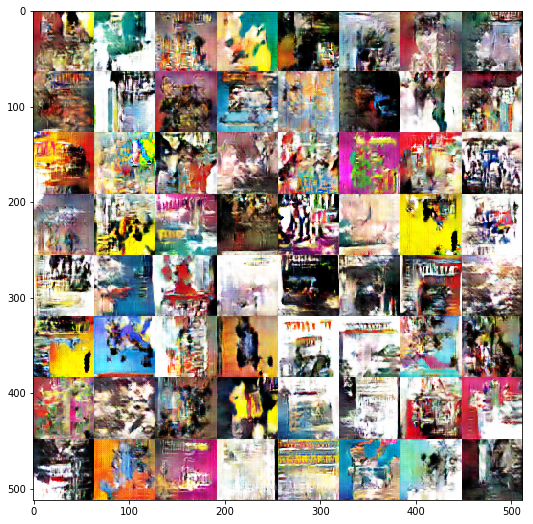

In [50]:
netD.eval(); netG.eval();
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));

In [51]:
dims = 512
cyc = 25000
torch.save(netG.state_dict(), TMP_PATH/f'netG_{dims}_2_{cyc}.h5')
torch.save(netD.state_dict(), TMP_PATH/f'netD_{dims}_2_{cyc}.h5')